In [2]:
# Some standard import statements that are nice for Jupyter

import sys
import os
import logging
import ipynb
import decimal

import numpy as np

from scipy.optimize import curve_fit

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.dpi'] = 200

import time

# importing my model functions for analysis
from psi_transmission.model_functions import *

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# some data loads to be performed right away
start_time_dict = get_start_times()
main_data_dict = load_all_data(start_time_dict['bernhard_p_beam'])

# Checking between Edgard and Bernhard's Data

It appears that Bernhard's data and Edgard's data might be completely different. We can plot both.

In [4]:
# load the proton beam data from Edgard
# here we use bernhard's start time for both for comparison
edgard_p_beam_data = load_p_beam_data(start_time_dict['bernhard_p_beam'])

# load the proton beam data from Bernhard 
bernhard_p_beam_data = load_bern_p_beam_data(start_time_dict['bernhard_p_beam'])

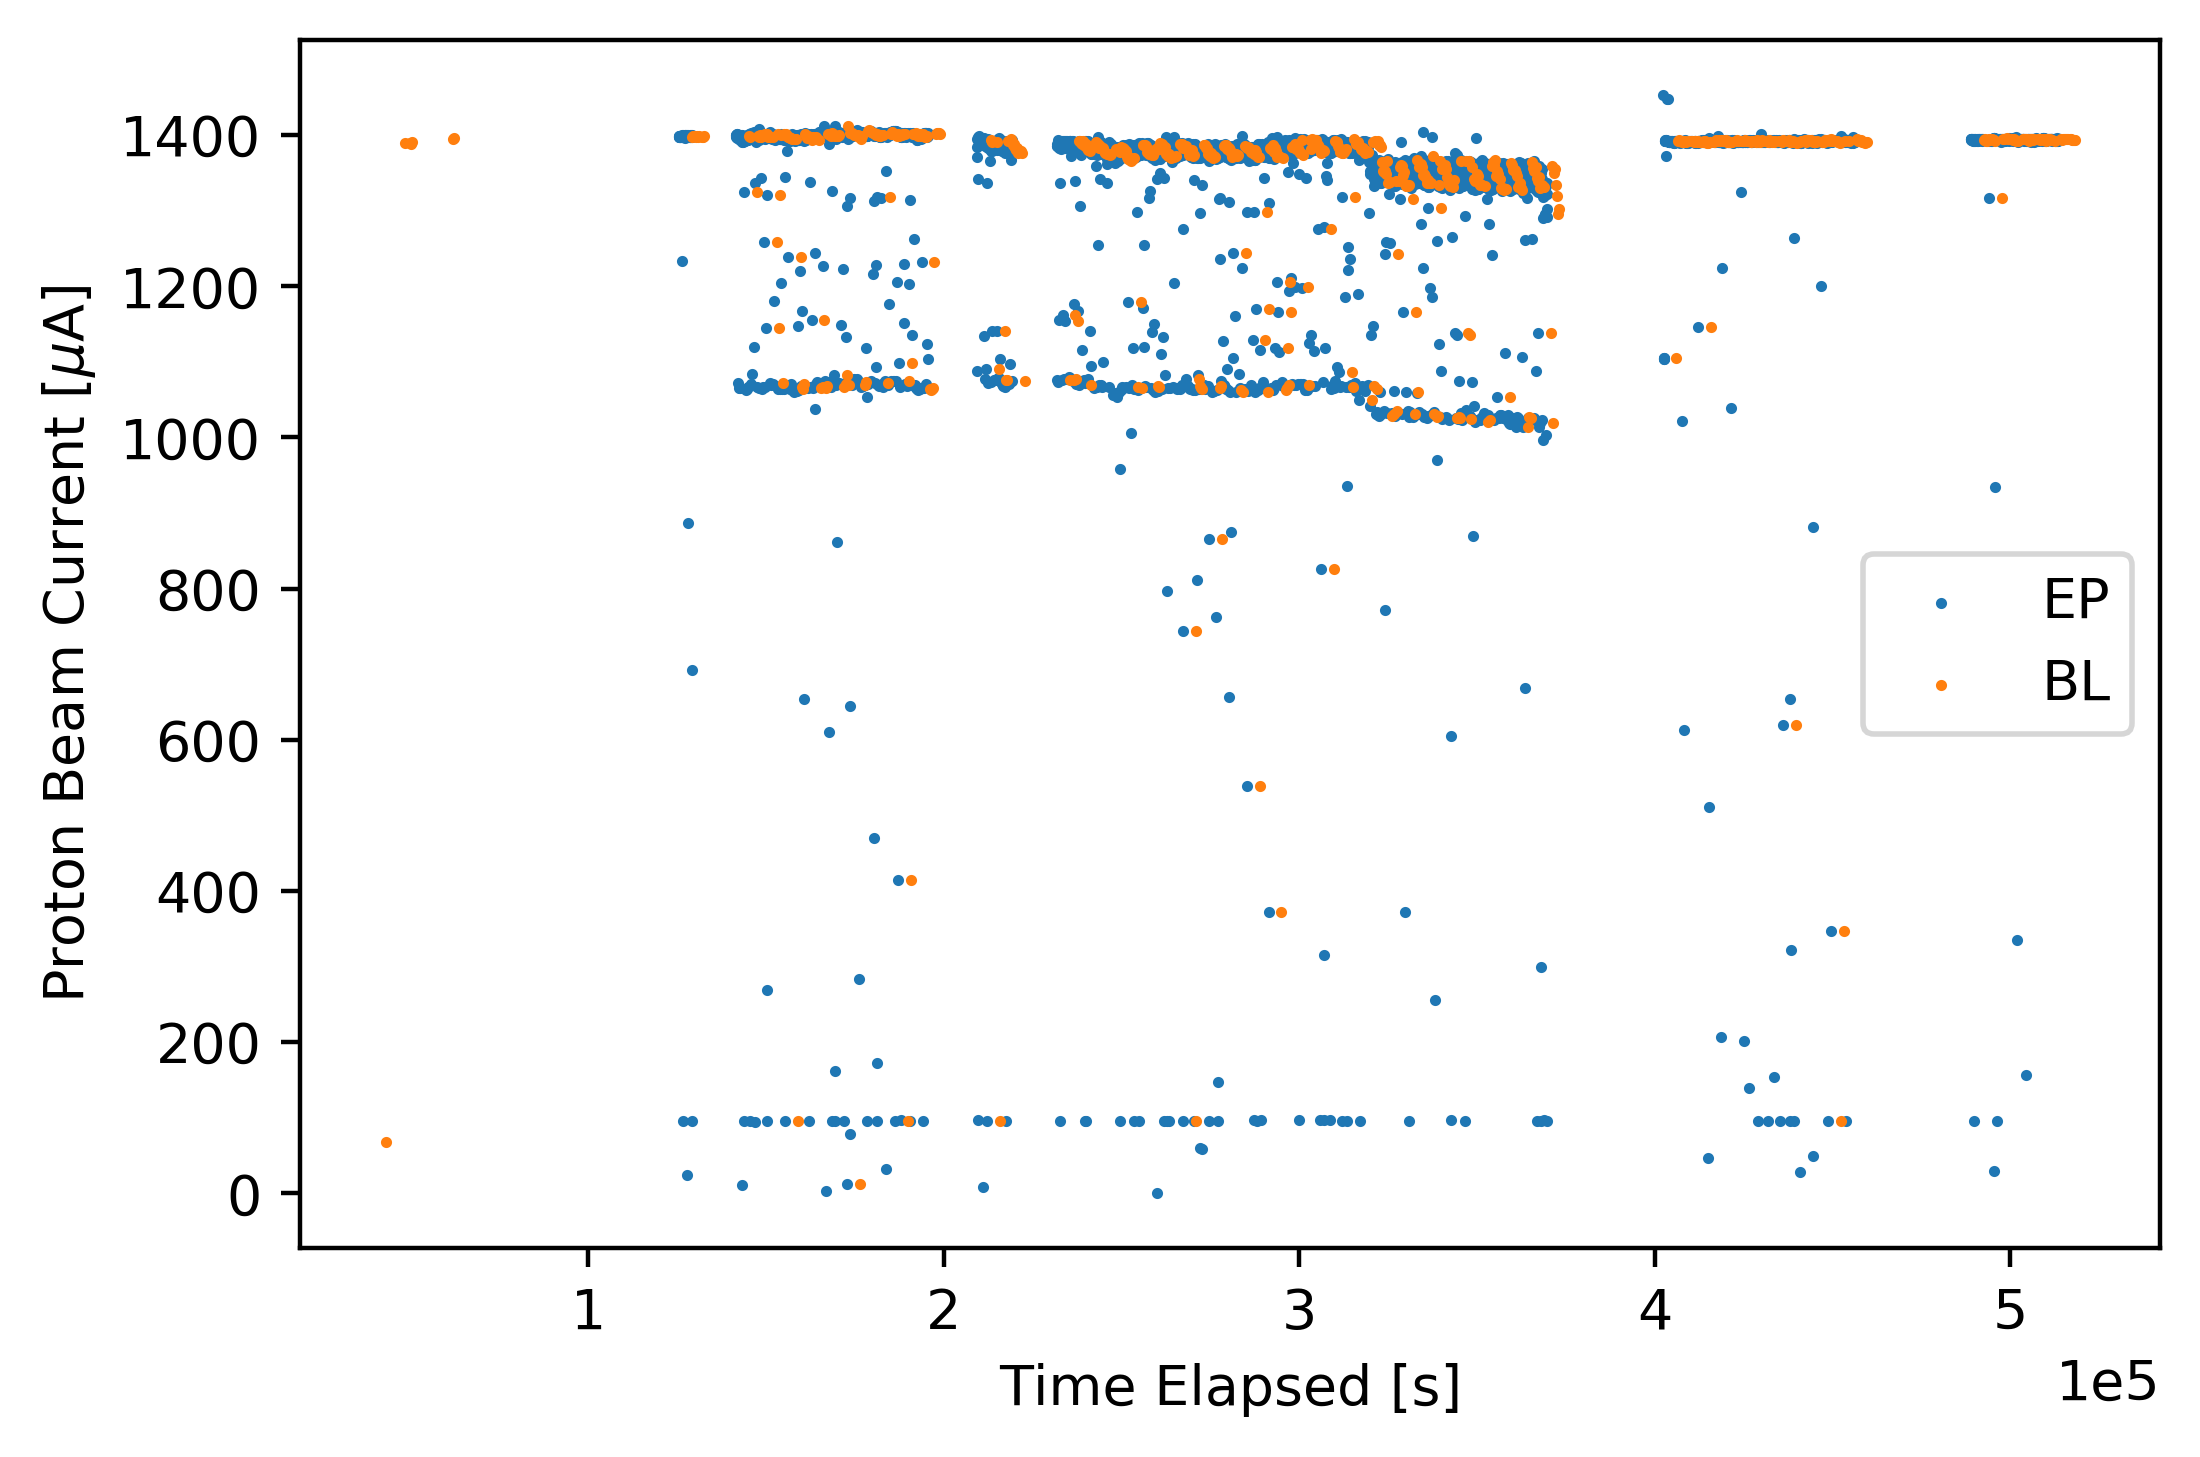

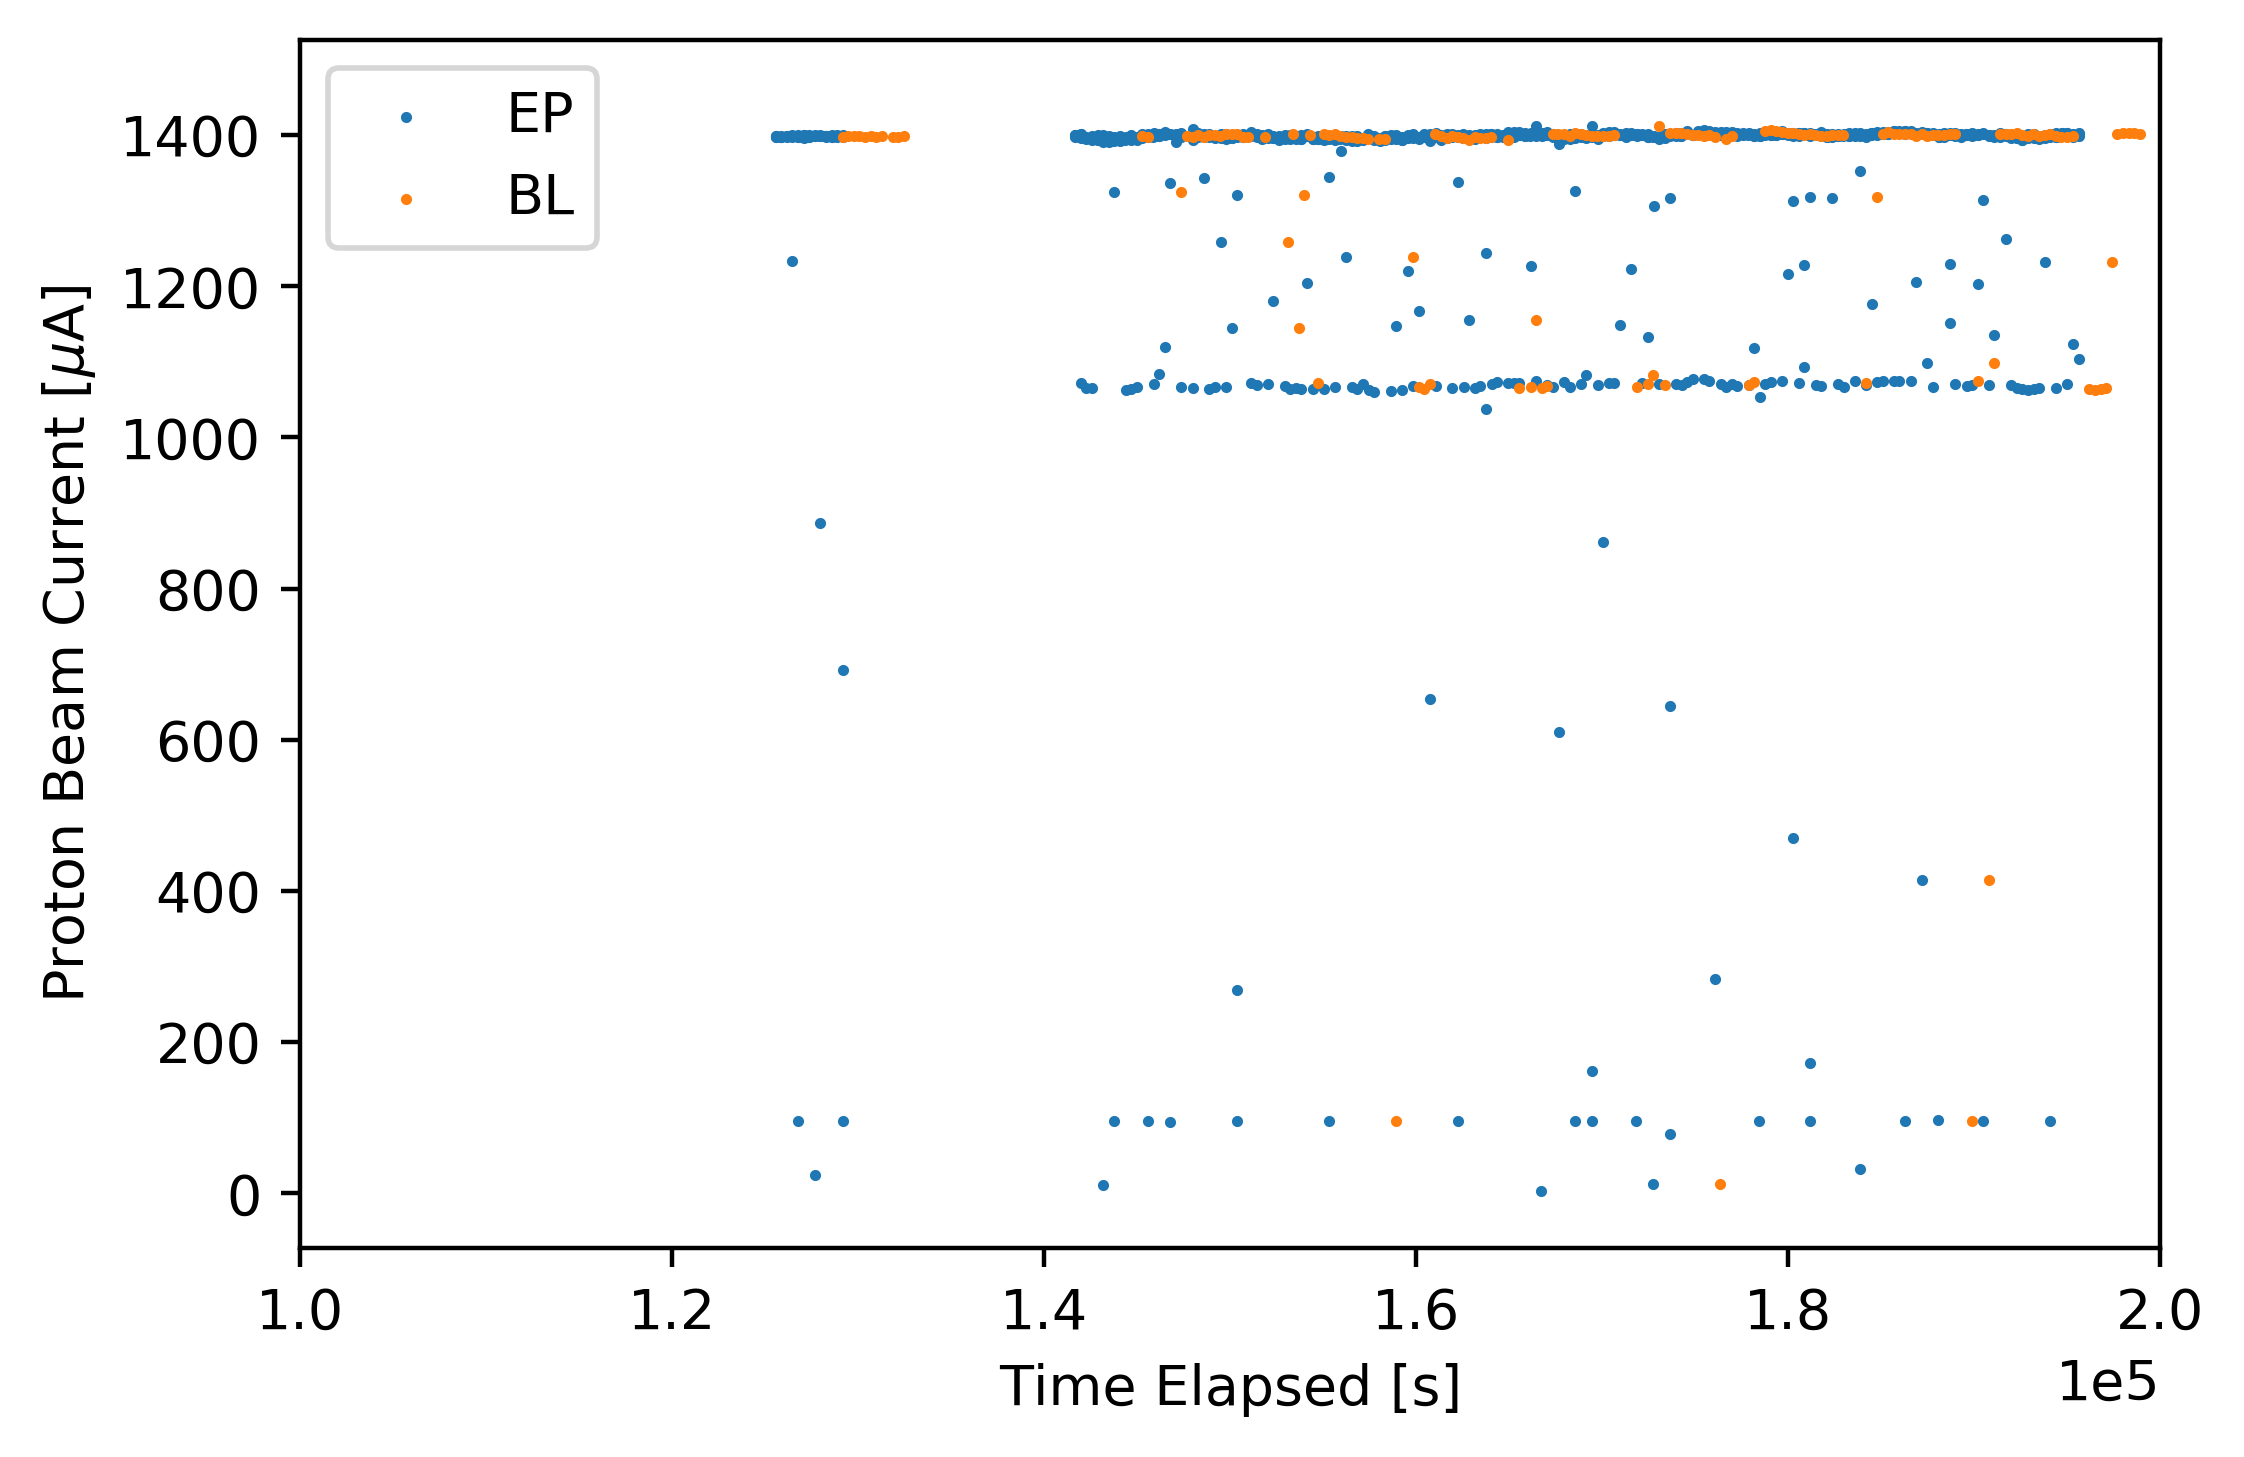

In [5]:
plt.scatter(edgard_p_beam_data[:,0], edgard_p_beam_data[:,1], s=1, label = 'EP');
plt.scatter(bernhard_p_beam_data[:,0], bernhard_p_beam_data[:,2], s=1, label = 'BL');
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('Time Elapsed [s]');
plt.ylabel(r'Proton Beam Current [$\mu$A]');
plt.legend();
plt.show()

plt.clf()
plt.scatter(edgard_p_beam_data[:,0], edgard_p_beam_data[:,1], s=1, label = 'EP');
plt.scatter(bernhard_p_beam_data[:,0], bernhard_p_beam_data[:,2], s=1, label = 'BL');
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('Time Elapsed [s]');
plt.ylabel(r'Proton Beam Current [$\mu$A]');
plt.legend();
plt.xlim([1e5,2e5])
plt.show()

They're not completely different, but there are disagreements. It's not clear what data set Edgard is using. This query will be forwarded to him. 

Assuming there's some issue with Edgard's data, we ought to move forward using Bernhard's since it appears to be a more raw version of the data

# Proton Beam Fluctuations

The plot from Edgard's slides is shown below. I believe he is showing some version of the proton beam timing data, which Bernhard refers to with skepticism in his email:

>2RGQ00CE006   -  this is the proton beam current towards UCN - you can see when pulses appeared<br/>
but you cannot trust the absolute value for various reasons - so do notu se as monitoring detector

![](../misc/p_beam_fluctuate.png)
![](jonahberean/psi_transmission/misc/p_beam_fluctuate.png)

The actual monitoring data from Bernhard is what we will use for the analysis.

>2RGQ00CE004      this is the proton beam current which you can use for monitoring <br/>
this detector measures the proton beam current at the exit of the cyclotron

## Plotting All Proton Beam Data

Below all of the proton beam monitoring data are plotted.

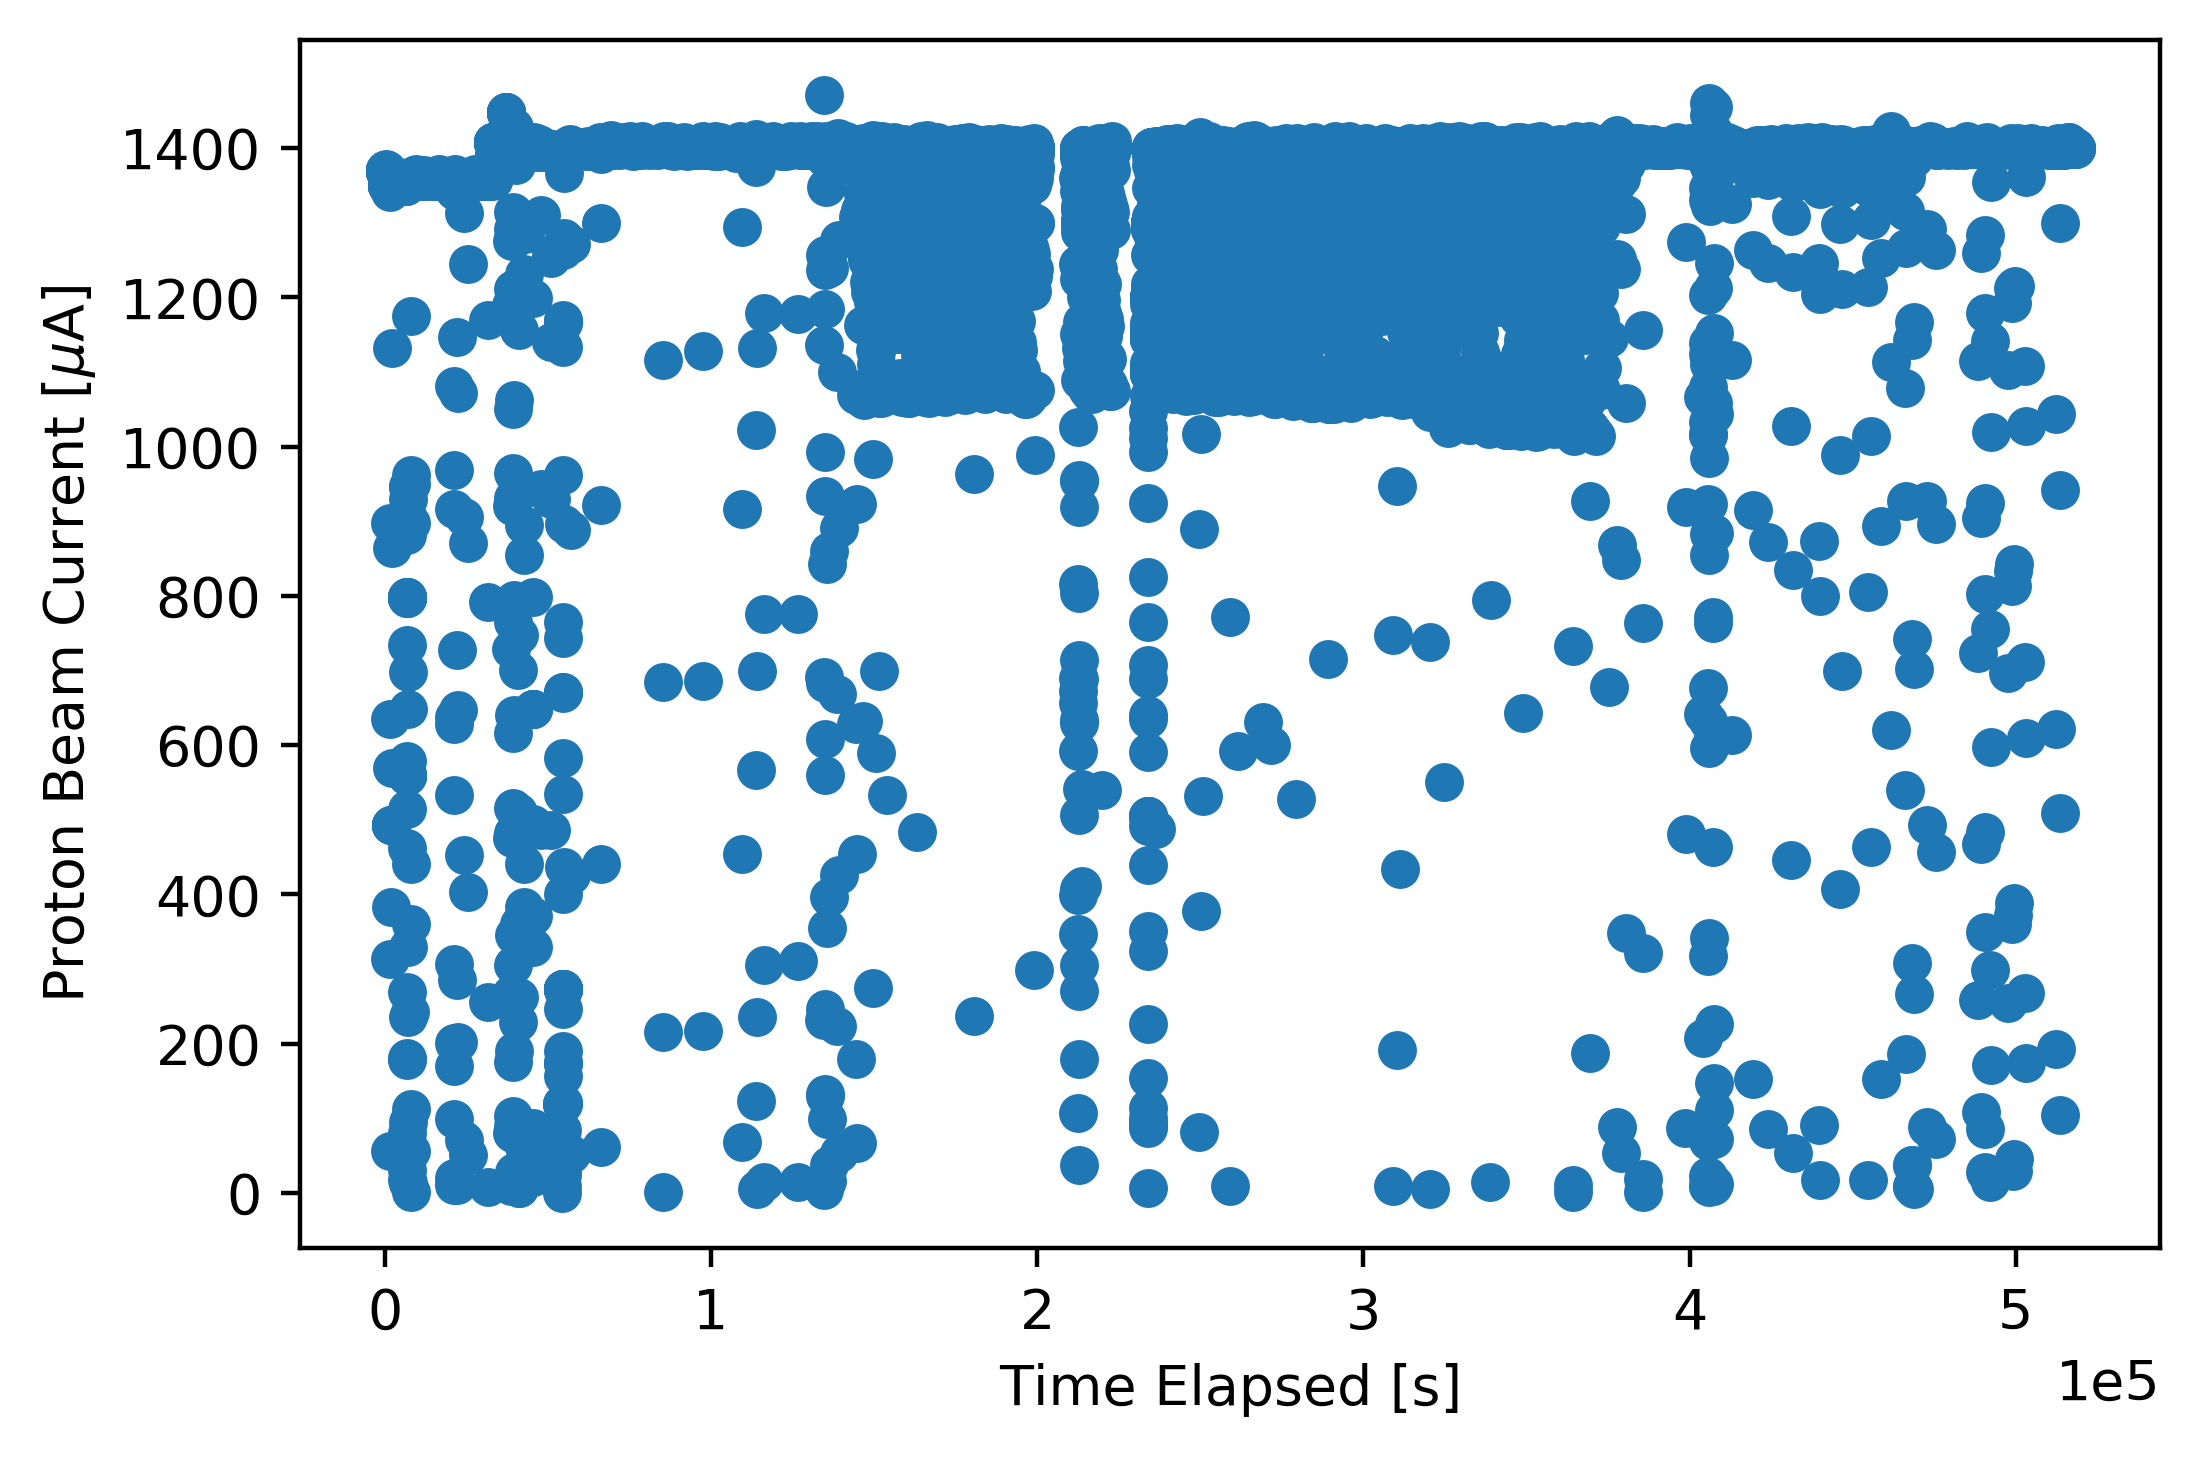

In [6]:
###############################################################################

# we use bernhard's data
arr = bernhard_p_beam_data

# plot all of the monitoring current data
plt.scatter(arr[:,0], arr[:,1])
plt.xlabel('Time Elapsed [s]');
plt.ylabel(r'Proton Beam Current [$\mu$A]');
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
# plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

###############################################################################

Nothing to parse just yet, but that's the full data set.

## Cross-Referencing the Proton Beam Current Data with Absolute UCN Detected Counts

The main detector run data files that we got from Edgard largely match what we see in the elog, meaning that his selection of runs based on cyclotron fluctuations was probably predictable during the beam time. Here we will be looking for large fluctuations of the neutron counts from individual runs, and we want to see those fluctuations in the context of fluctuating proton beam currents. 

We're expecting neutron transmission values through the guides of ~0.5-0.9, so for a preliminary analysis we can go ahead and look at the counts without any configuration-dependent re-normalization of the total count rates. However, a re-normalization of all the data according to time elapsed - since the first experimental run - will be performed to account for the decline in absolute UCN counts over time. 

Here are the preliminary results for transmission from Edgard, as justification for my rough approach:

![](../misc/triumf_guide_transmission.png)
![](jonahberean/psi_transmission/misc/triumf_guide_transmission.png)

![](../misc/jp_guide_transmission.png)
![](jonahberean/psi_transmission/misc/jp_guide_transmission.png)

### Plotting every Main Detector Run with the Proton Beam Current Data

Next we can take the main detector data from every run, and plot it alongside the proton beam current data. To start, we'll use only those runs that were accepted by Edgard (even less than this really, as I also made some cuts from what was available after reviewing the elog). I'm ignoring the normalization to any absolute UCN yield changes, for now.

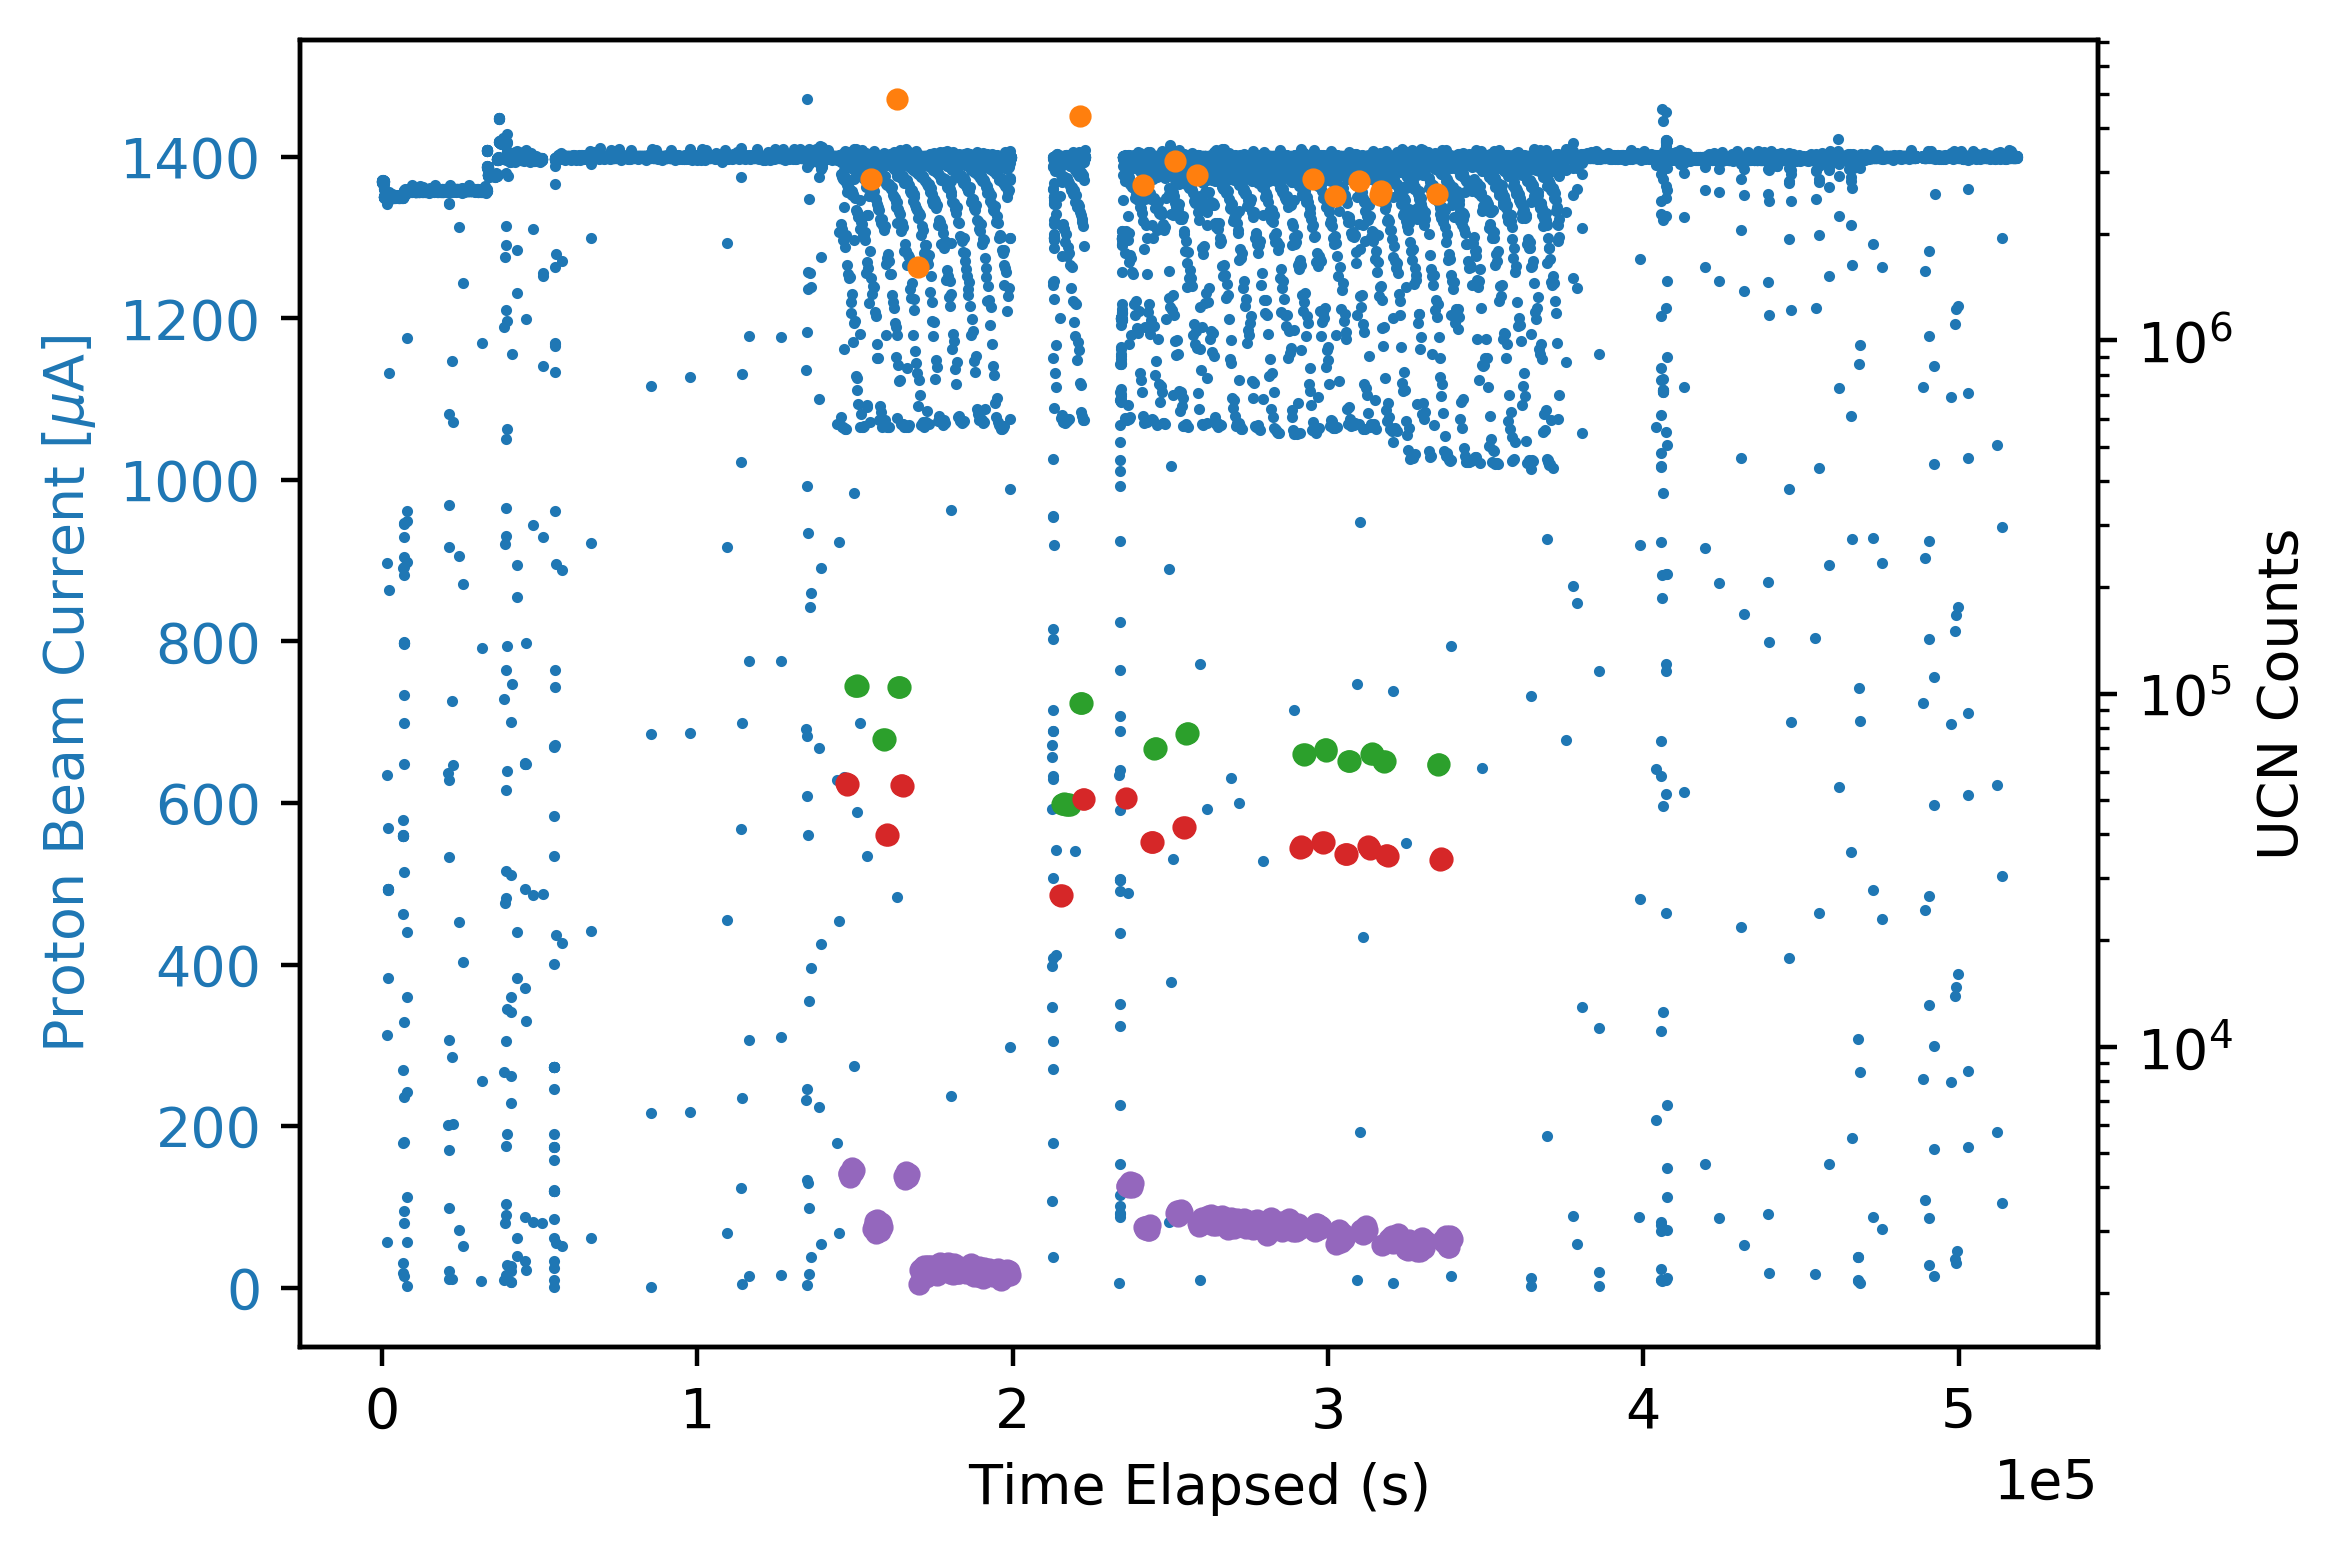

In [7]:
###############################################################################
# instantiate the subplots 
fig, ax1 = plt.subplots()

# for colour consistency in plotting
ax = plt.gca()

# for colour consistency in plotting
color = next(ax._get_lines.prop_cycler)['color']

ax1.set_xlabel('Time Elapsed (s)')

# narrow the x range to where our main detector run data are
# ax1.set_xlim([0.5e5,1e5])

ax1.set_ylabel(r'Proton Beam Current [$\mu$A]', color=color)

# plot all of bernhard's monitoring data
arr = bernhard_p_beam_data
ax1.scatter(arr[:,0], arr[:,1], s=1)

ax1.tick_params(axis='y', labelcolor=color)
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  

for run_type in ['s000', 's005', 's020', 's100']:
    
    # for colour consistency in plotting
    color = next(ax._get_lines.prop_cycler)['color']
    
    # plot every run of data, no normalization
    arr = main_data_dict['all', run_type]
    
    ax2.errorbar(arr[:,0], arr[:,2], yerr = arr[:,3], fmt = '.', color = color)

# we already handled the x-label with ax1
ax2.set_ylabel('UCN Counts')  
ax2.set_yscale('log')

# otherwise the right y-label is slightly clipped
fig.tight_layout()  
###############################################################################

To get a more granular look at this data, we will plot only proton beam current data points that are within a 1 minute range of our run start times.

!!! Does the weirdness in the middle coincide with the weirdness we saw with the monitor count data?

Here I'm plotting any proton beam current measurement that occurs within a 10 second time window of the start of a run.

The methodology here is on the right track, but I need to interrupt this progress in order to look at a new set of data provided by Edgard and Bernhard. 

## New 0.5 Hz Data from Edgard via Bernhard

This data set for proton beam current is the original set sent to Edgard in 2017 by Bernhard. 

In [12]:
p_beam_data_3 = load_p_beam_data_3(start_time_dict['bernhard_p_beam'])

/ucn/orithyia_data/jberean2/psi_transmission/src/psi_transmission/model_functions.py:626: UserWarning: loadtxt: Empty input file: "../data_p_beam_3/.~lock.self_create_ucn_strom_20171208.csv#"
  usecols=(1));


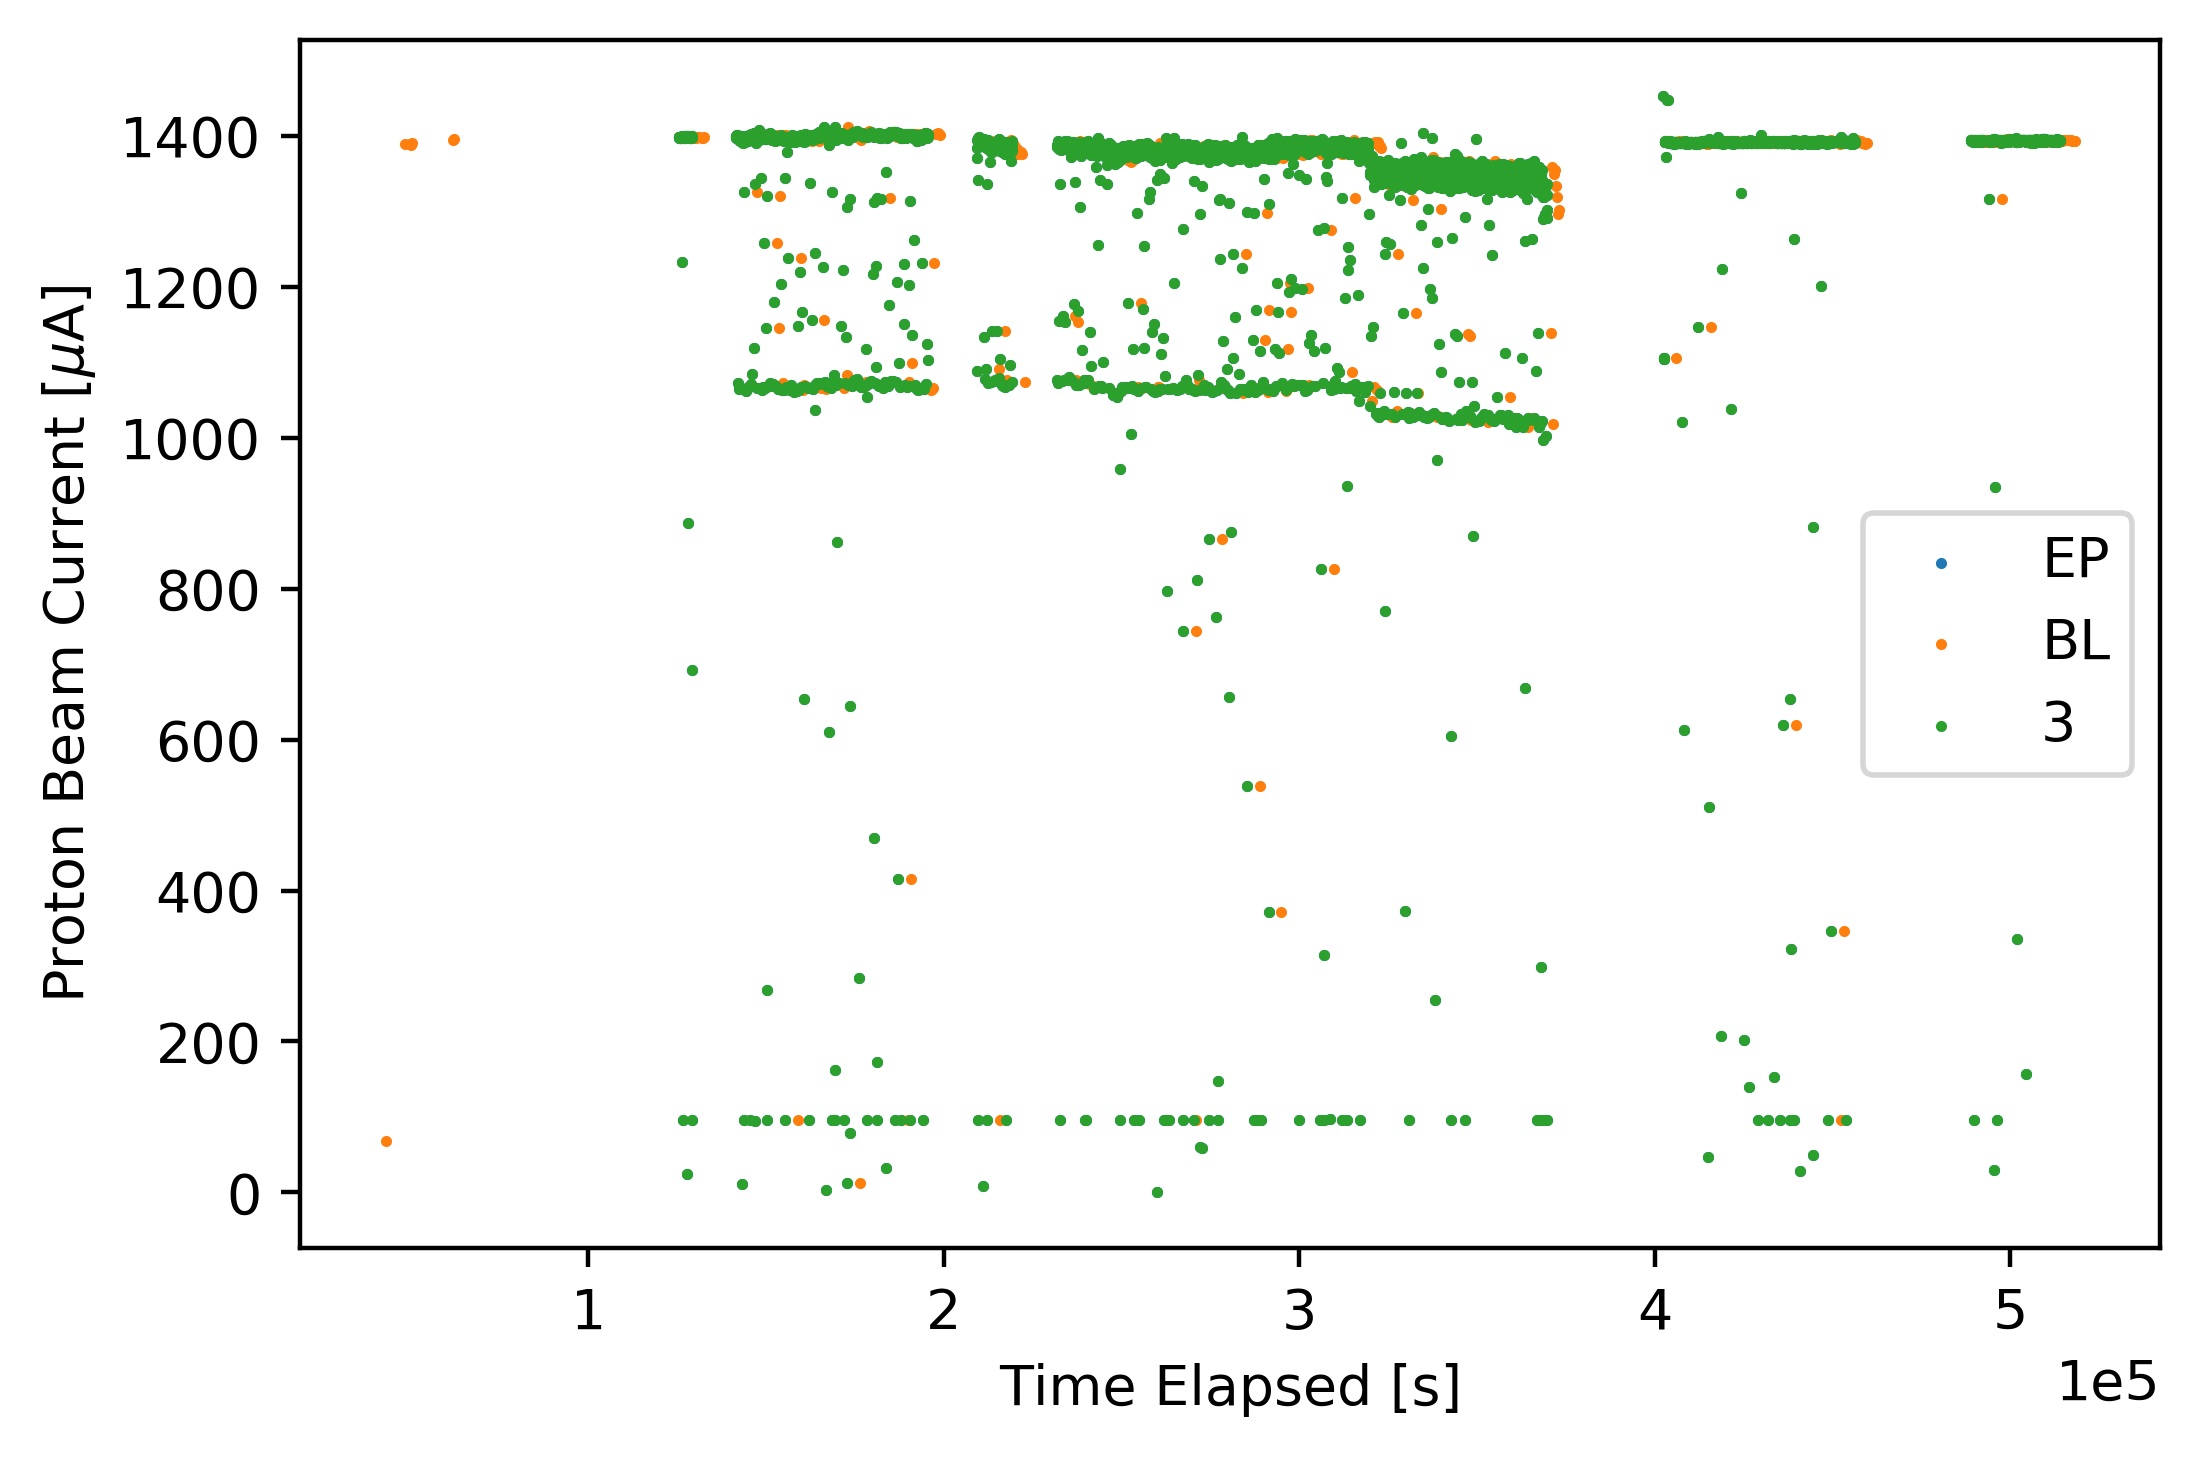

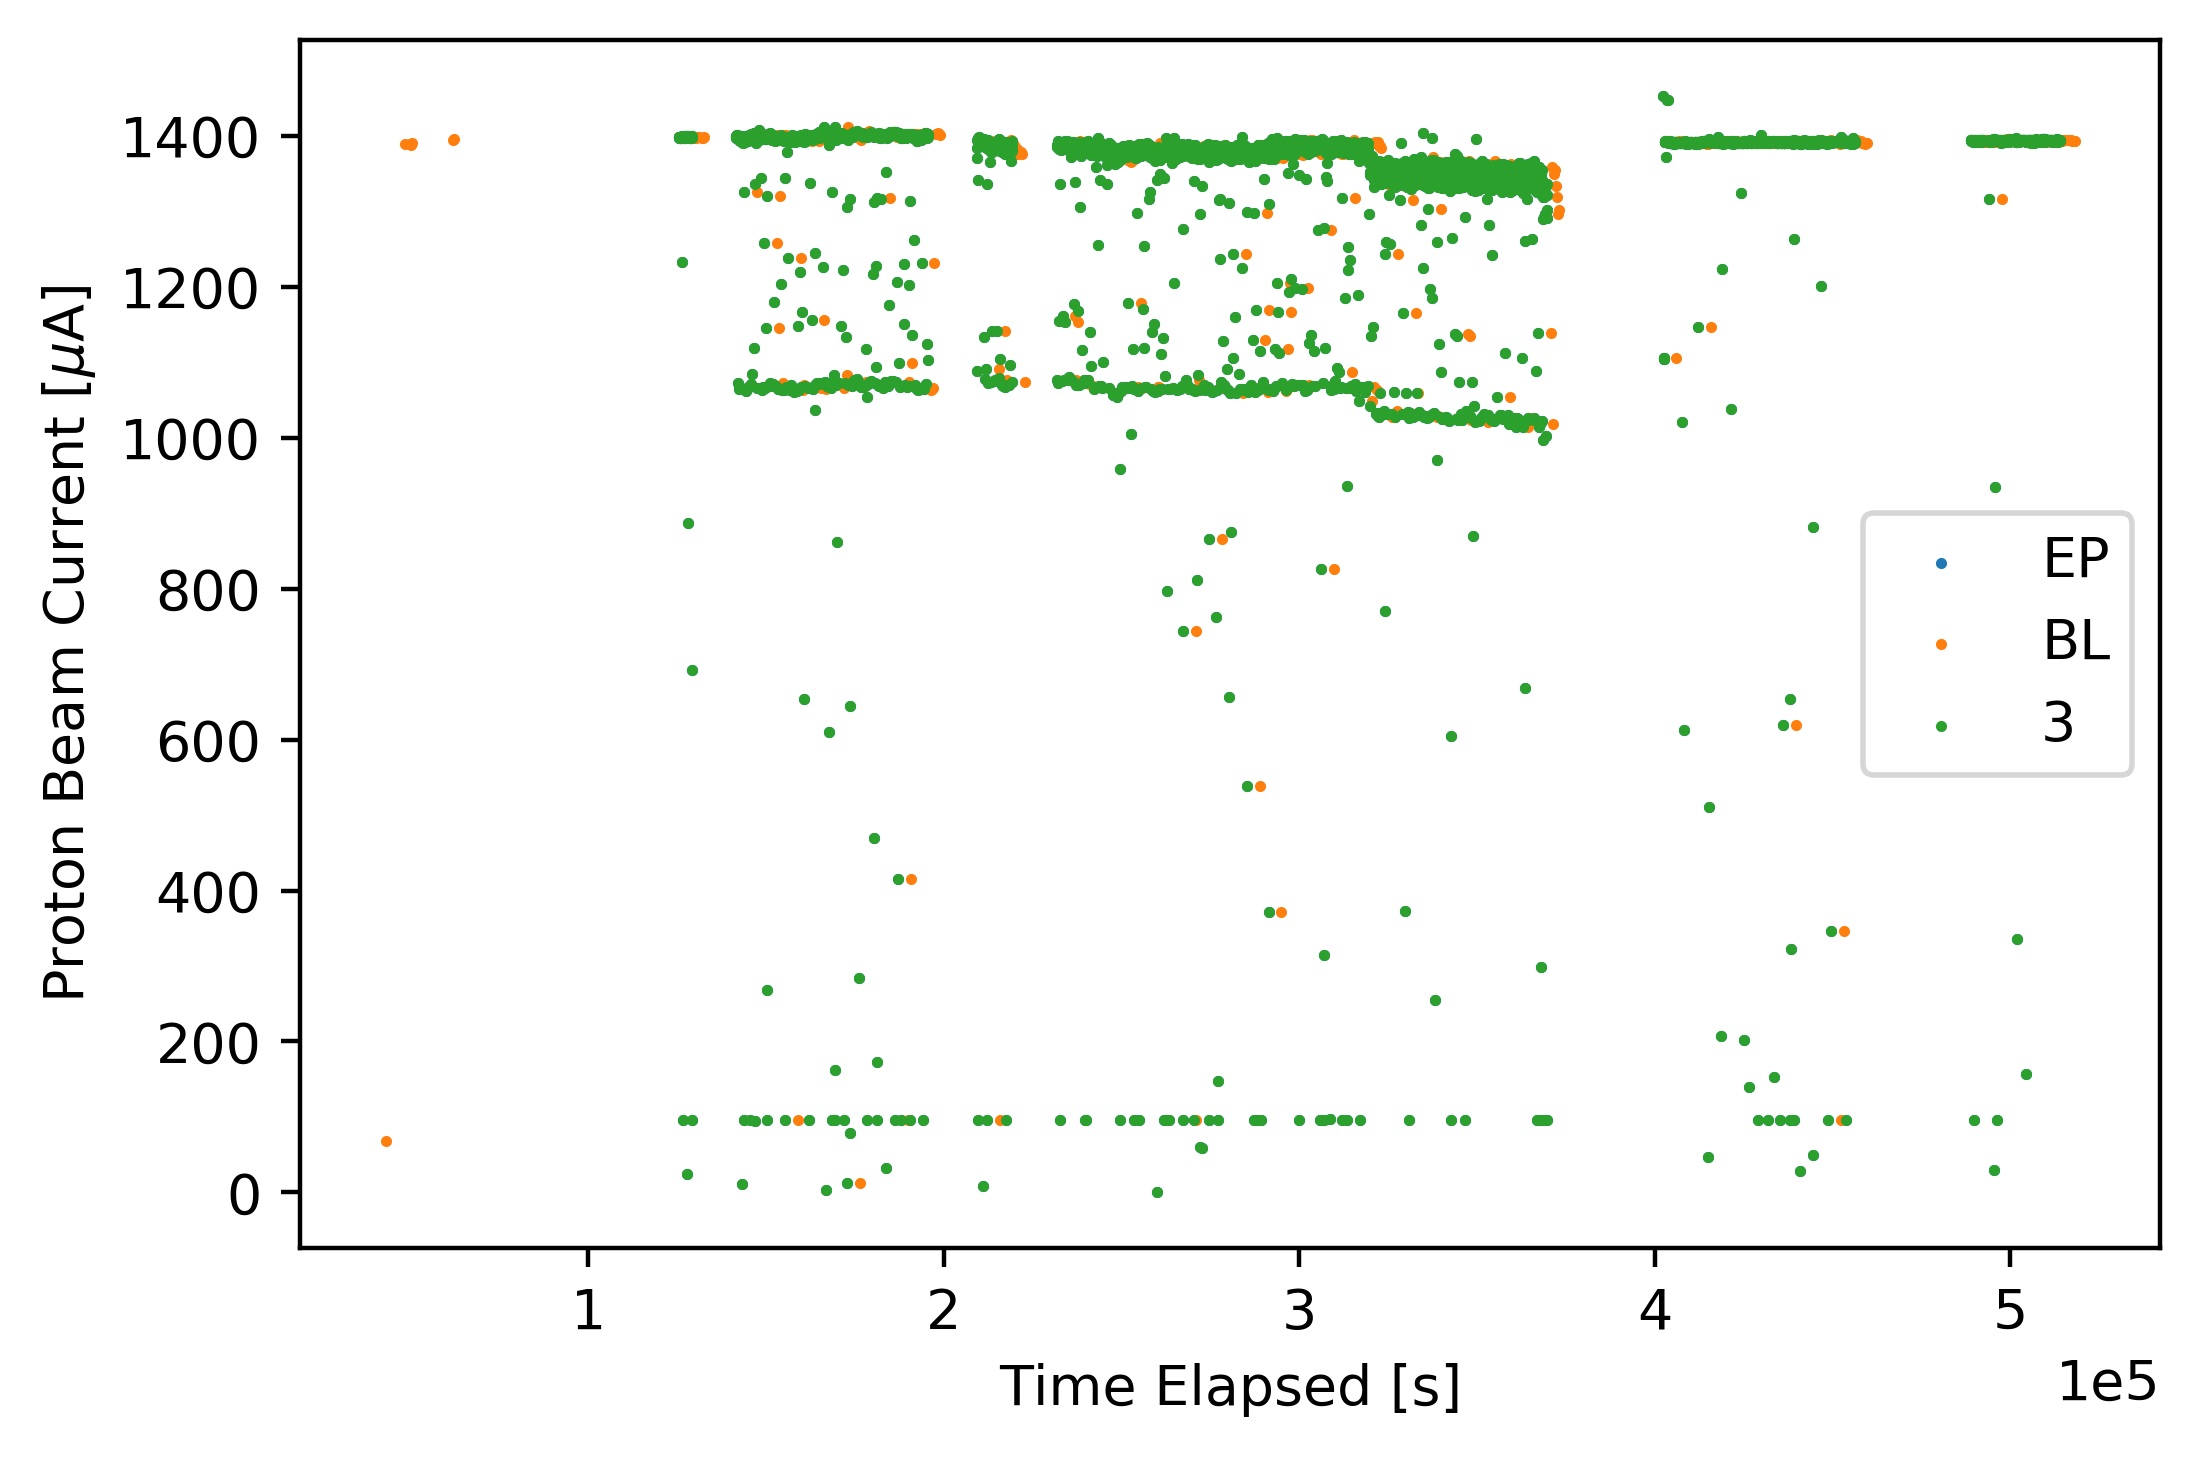

In [13]:
plt.scatter(edgard_p_beam_data[:,0], edgard_p_beam_data[:,1], s=1, label = 'EP');
plt.scatter(bernhard_p_beam_data[:,0], bernhard_p_beam_data[:,2], s=1, label = 'BL');
plt.scatter(p_beam_data_3[:,0], p_beam_data_3[:,1], s=1, label = '3');
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('Time Elapsed [s]');
plt.ylabel(r'Proton Beam Current [$\mu$A]');
plt.legend();
plt.show()

plt.clf()
plt.scatter(edgard_p_beam_data[:,0], edgard_p_beam_data[:,1], s=1, label = 'EP');
plt.scatter(bernhard_p_beam_data[:,0], bernhard_p_beam_data[:,2], s=1, label = 'BL');
plt.scatter(p_beam_data_3[:,0], p_beam_data_3[:,1], s=1, label = '3');
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.xlabel('Time Elapsed [s]');
plt.ylabel(r'Proton Beam Current [$\mu$A]');
plt.legend();
plt.show()

Clearly this new data set, the original 0.5 Hz data set sent from Bernhard to Edgard in 2017, is the same as what Edgard originally sent me. This is the data set to use. As Ruediger suggested, it is likely that this data was available during the beam time, due to active monitoring of the cyclotron for the experimentalists. The 0.1 Hz data that Bernhard had access to was just the cyclotron history data, a constant monitoring that occurs constantly in the background. 

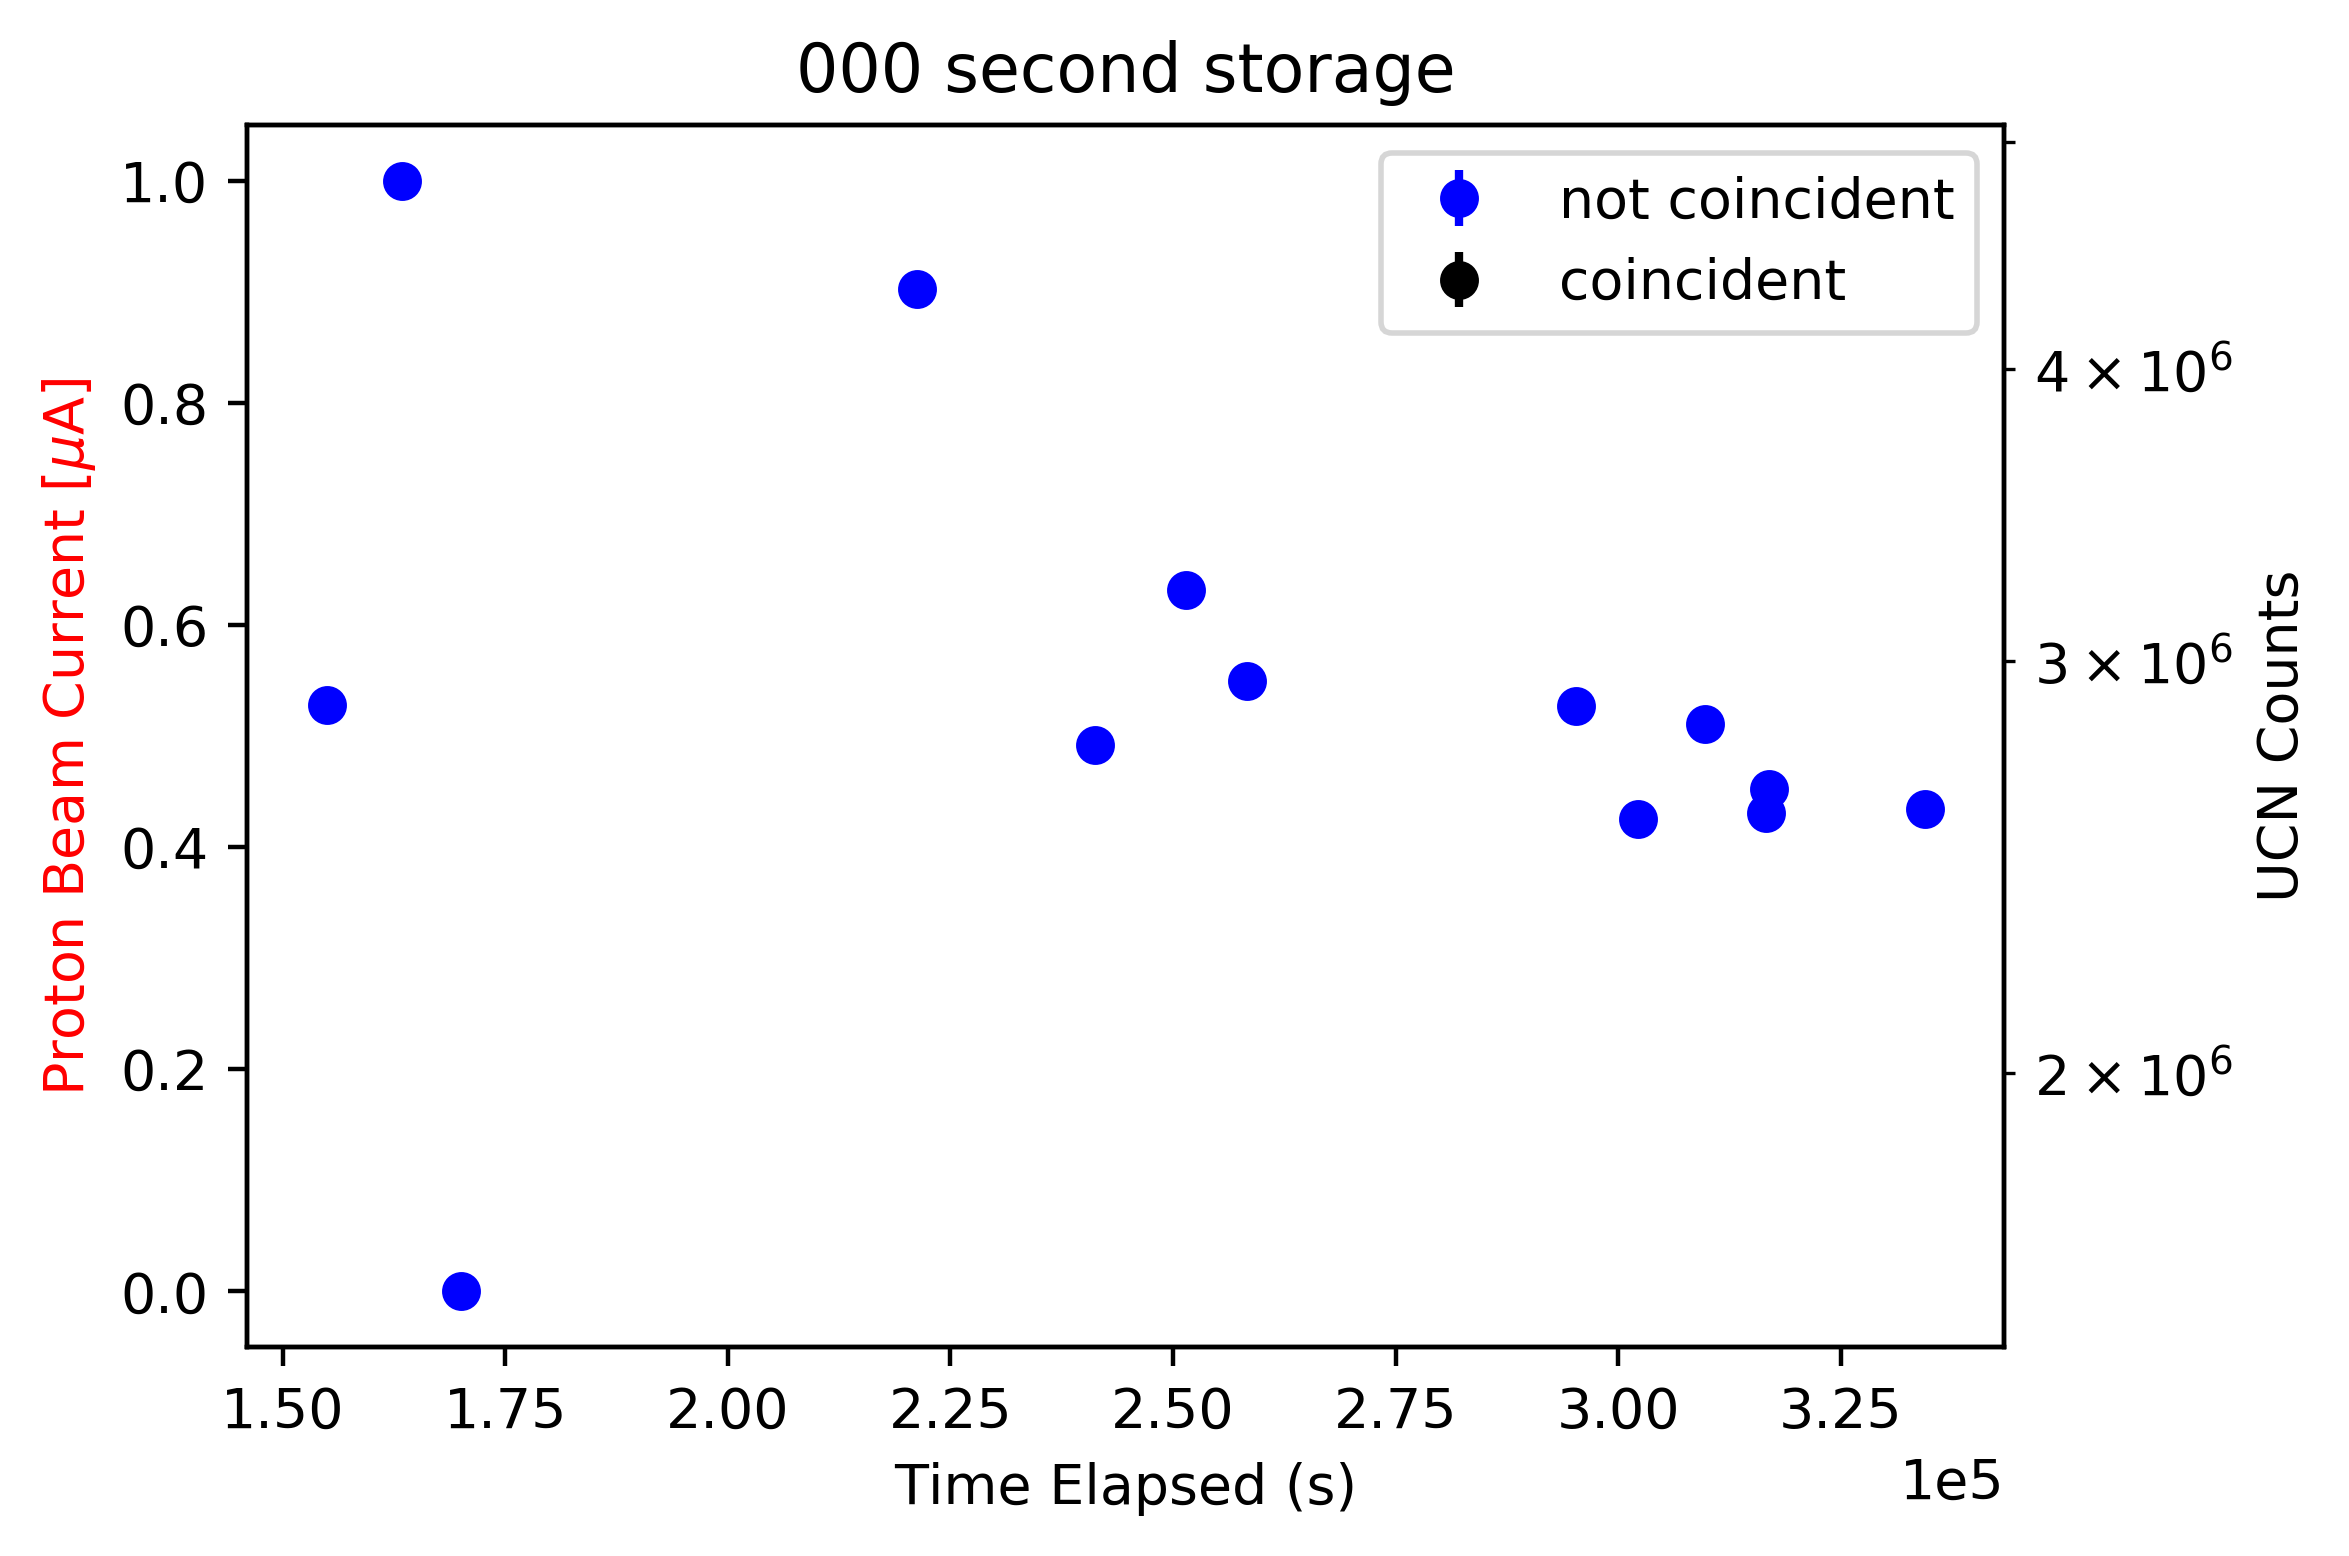

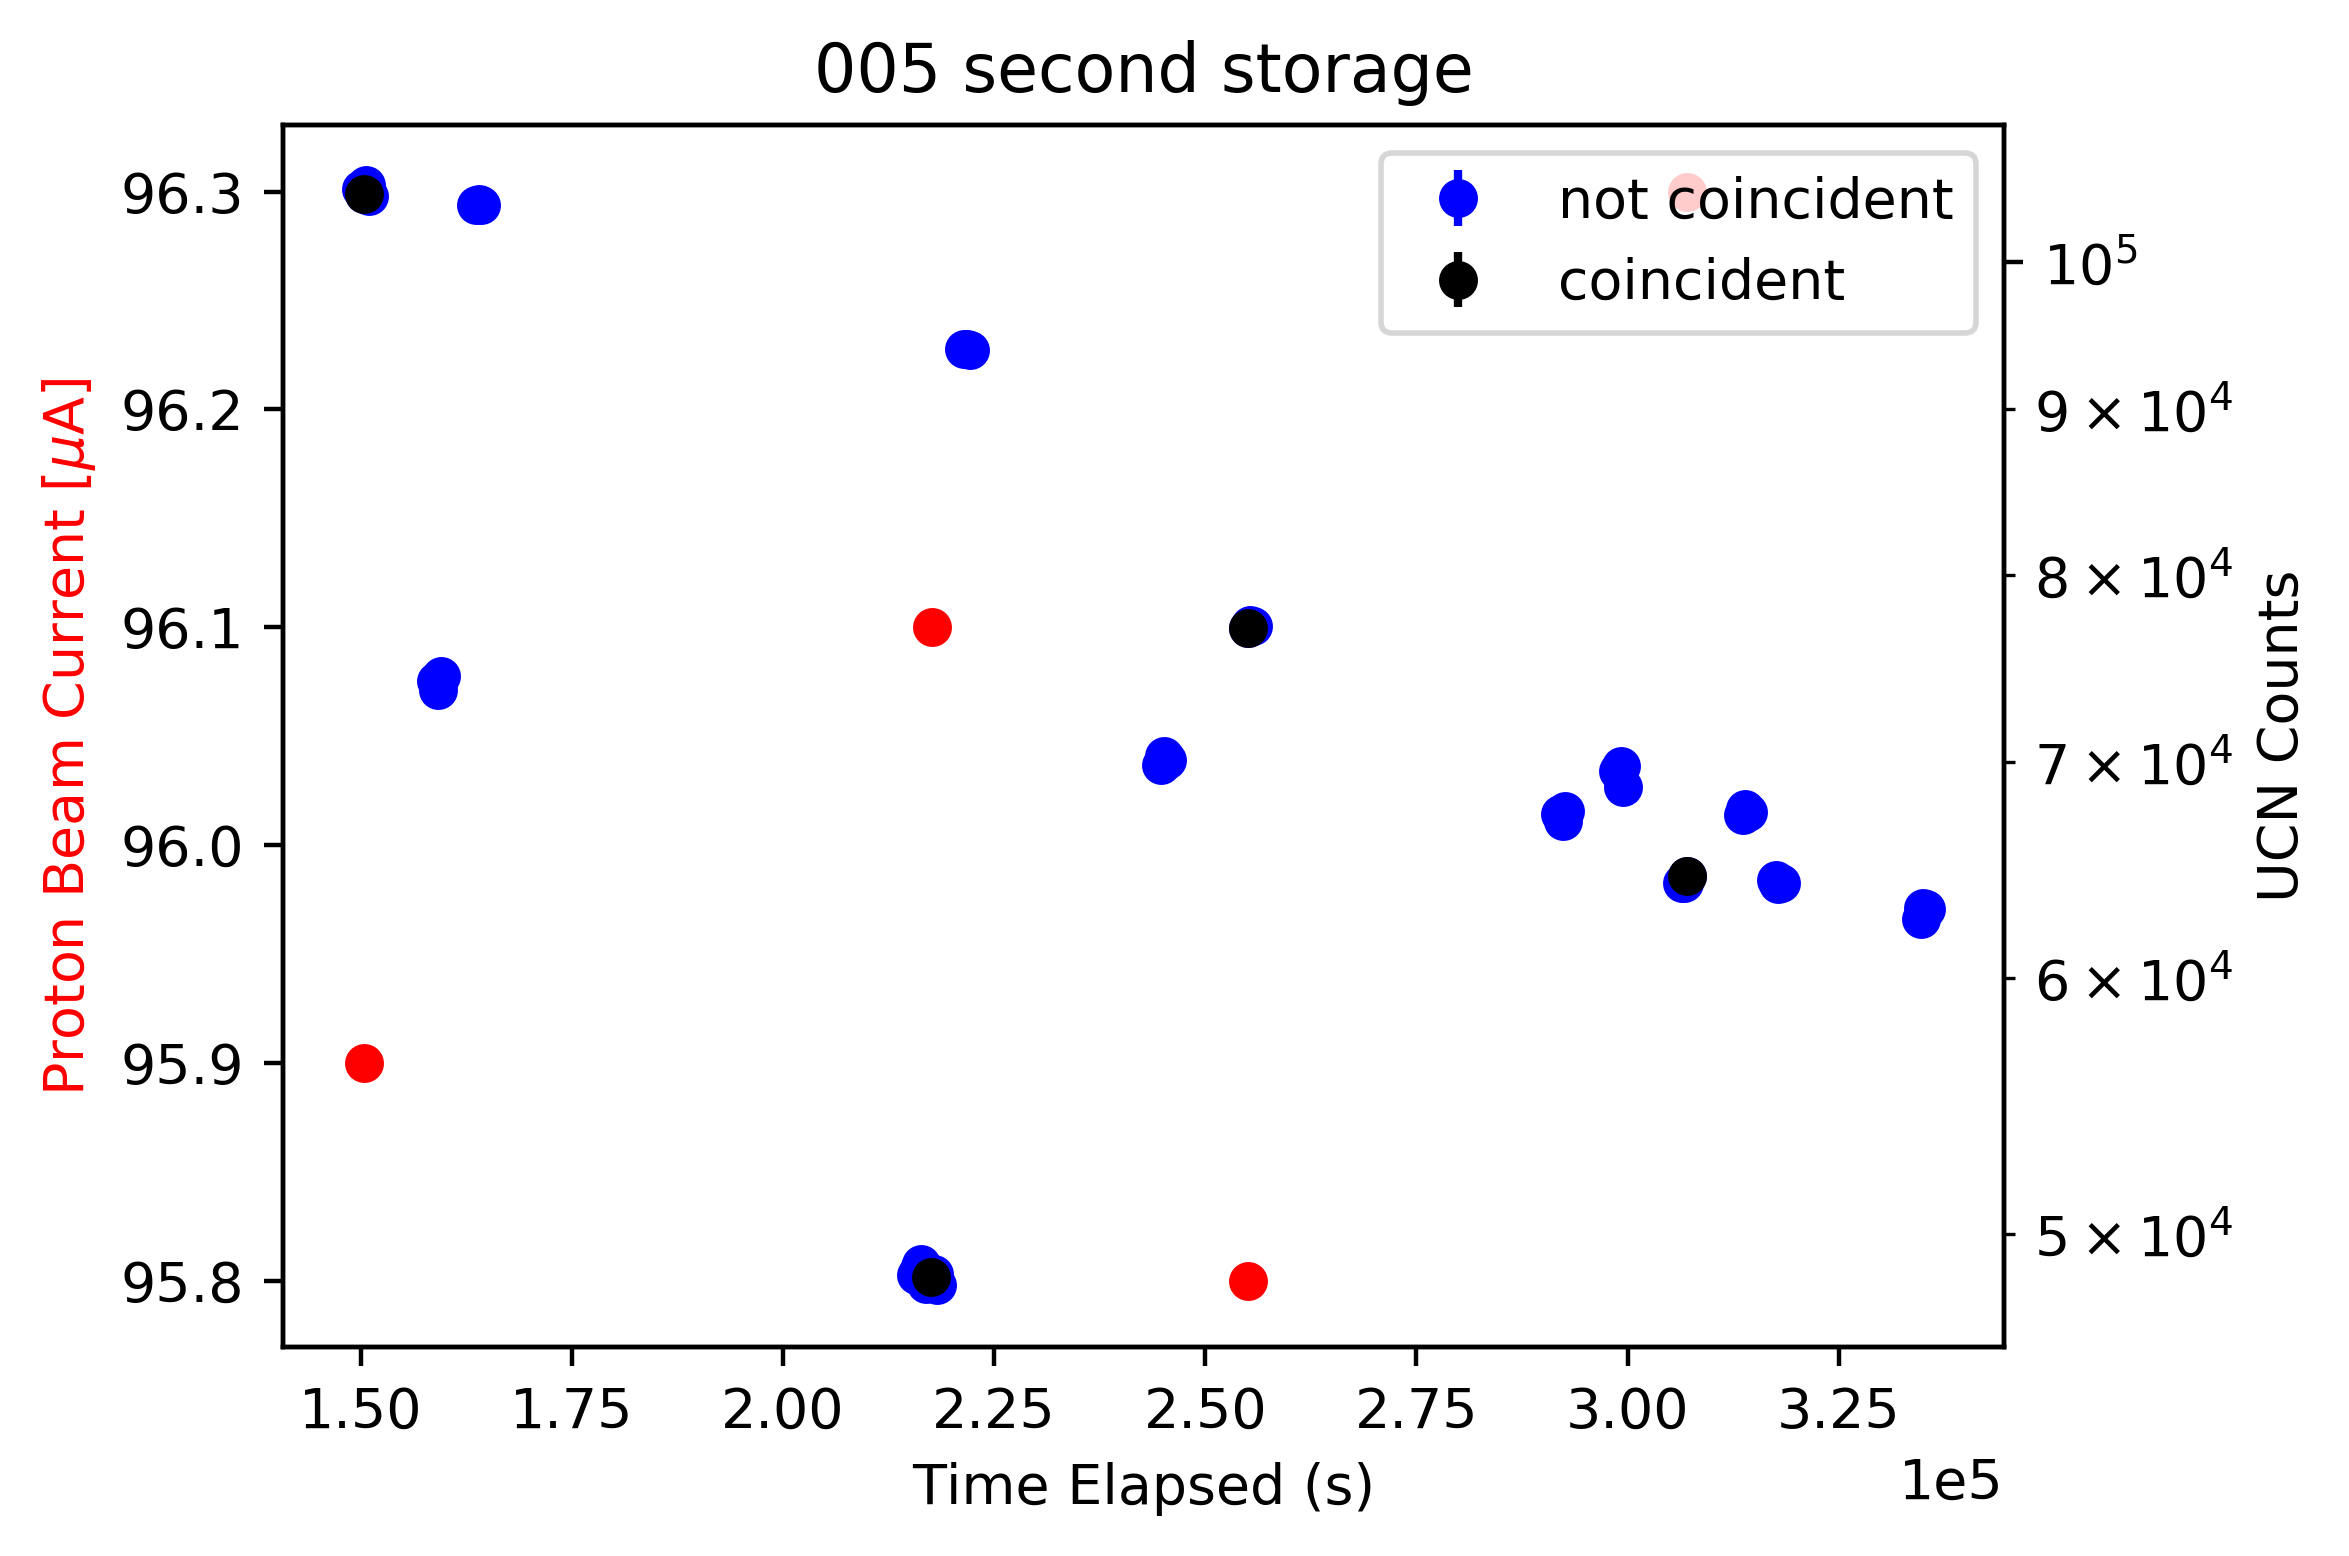

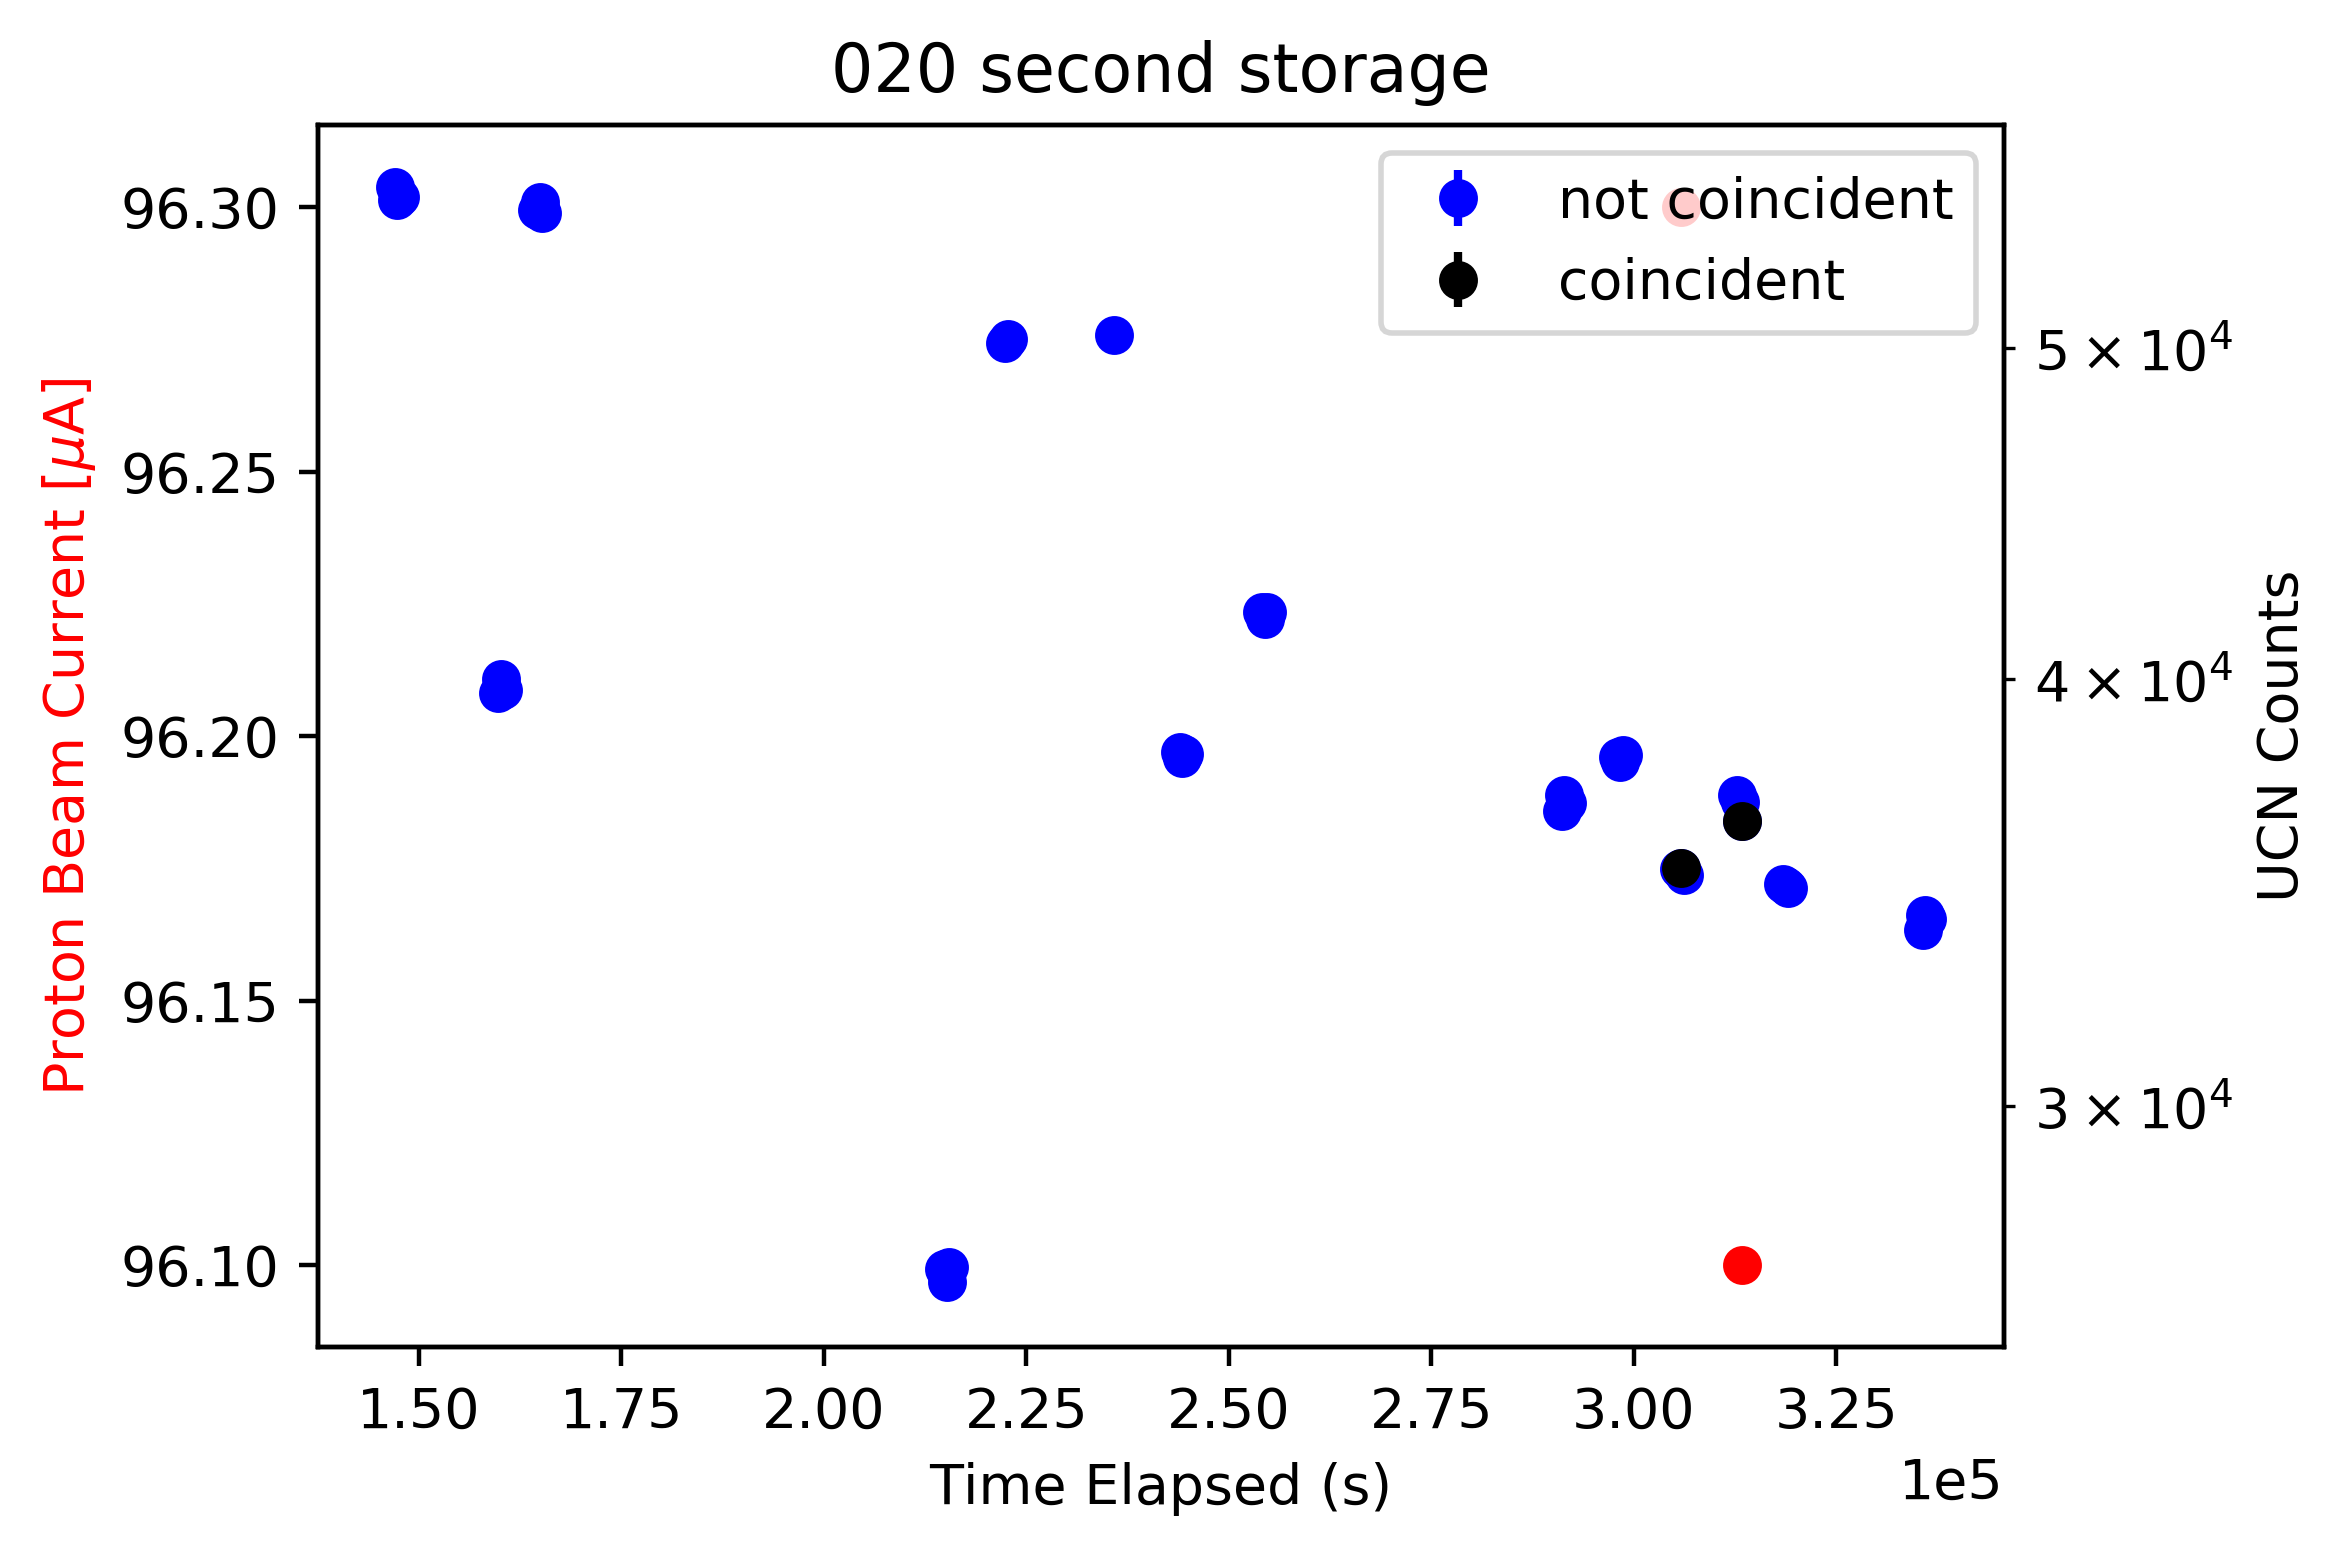

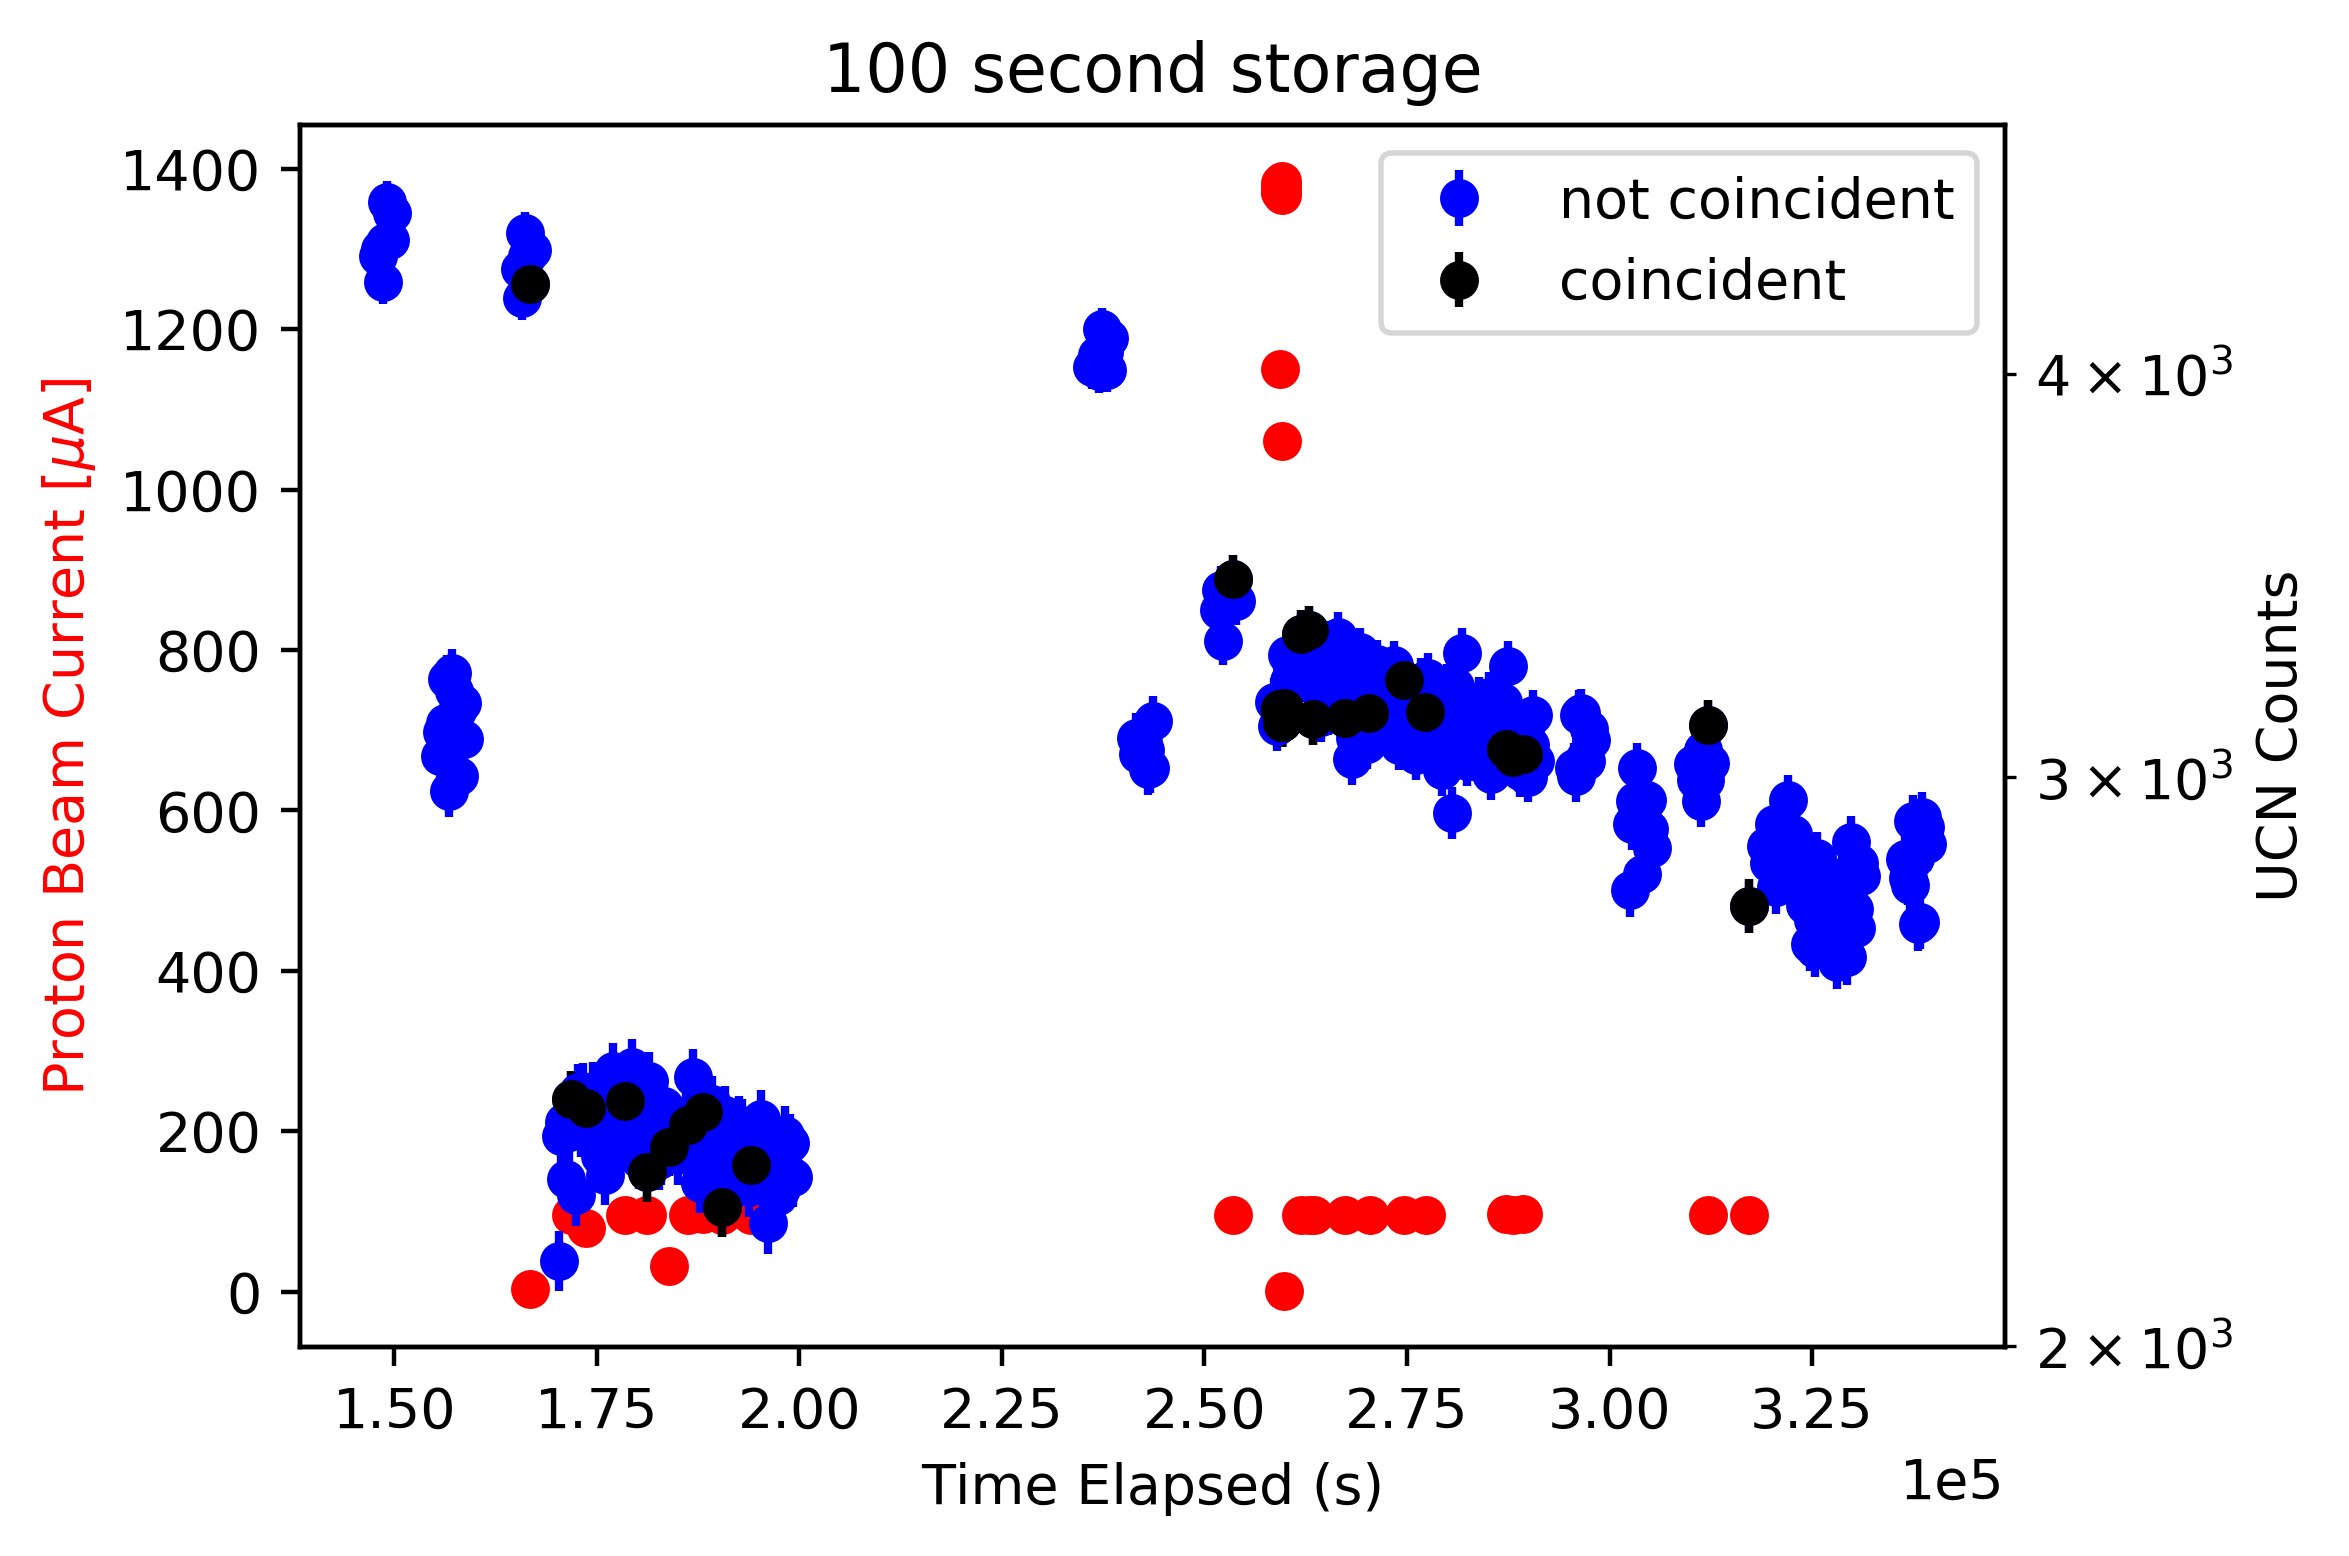

In [20]:
red_arr = find_coincidences(p_beam_data_3, main_data_dict, 20, plotting_flag = True)

How is it possible that there are no proton current measurements that are coincident with the 0 second storage measurement run times. My previous understanding was that there would always be a kick measurement from irradiation, for every run. This doesn't make any sense. 

For example, the 48th run on the 8th of December; the elog entry:

>[Fri, Dec 08, 2017, 19:08:42 ]  open shutter 1, in order to get 1 measurement with no storage. <br/>
tof.48 = 2872300

The timing information from the txt file:

>Start Time   : 19:10:58<br/>
Nominal Time : 23:50:50<br/>
Real Time    : 00:04:59<br/>
Stop Time    : 19:15:58<br/>

And the proton beam current measurements from the original, 0.5 Hz data set:

2017-12-08 19:06:16 --- 0<br/>
2017-12-08 19:06:18 --- 0<br/>
2017-12-08 19:06:20 --- 0<br/>
2017-12-08 19:06:22 --- 1395.4<br/>
2017-12-08 19:06:24 --- 1394.7<br/>
2017-12-08 19:06:26 --- 1397.4<br/>
2017-12-08 19:06:28 --- 1398.7<br/>
2017-12-08 19:06:30 --- 0<br/>
2017-12-08 19:06:32 --- 0<br/>
2017-12-08 19:06:34 --- 0<br/>
.<br/>
.<br/>
.<br/>
2017-12-08 19:11:18 --- 0<br/>
2017-12-08 19:11:20 --- 0<br/>
2017-12-08 19:11:22 --- 0<br/>
2017-12-08 19:11:24 --- 1393.6<br/>
2017-12-08 19:11:26 --- 1397<br/>
2017-12-08 19:11:28 --- 1398.7<br/>
2017-12-08 19:11:30 --- 1063.5<br/>
2017-12-08 19:11:32 --- 0<br/>
2017-12-08 19:11:34 --- 0<br/>
2017-12-08 19:11:36 --- 0<br/>
.<br/>
.<br/>
.

Every single time in this data set must be off sync. Let's see if it is a consistent offset. This measurement appears to be off by ~26 seconds, that is, the proton beam current times stamp is ~26 seconds later than it should be. 


Here's run 198 on Dec. 09:

>[Sat, Dec 09, 2017, 23:50:59 ] UGD01 installed, ready to get measurement in direct. Open shutter 1, in order to get 1 measurement with no storage.<br/>
tof.198 = 2942550

From the txt:

>Start Time   : 23:53:21<br/>
Nominal Time : 23:50:50<br/>
Real Time    : 00:04:59<br/>
Stop Time    : 23:58:20<br/>


Then from the beam current data:
>.<br/>
.<br/>
.<br/>
2017-12-09 23:53:42 --- 0<br/>
2017-12-09 23:53:44 --- 0<br/>
2017-12-09 23:53:46 --- 0<br/>
2017-12-09 23:53:48 --- 1376.7<br/>
2017-12-09 23:53:50 --- 1383.1<br/>
2017-12-09 23:53:52 --- 1387.1<br/>
2017-12-09 23:53:54 --- 1064.9<br/>
2017-12-09 23:53:56 --- 0<br/>
2017-12-09 23:53:58 --- 0<br/>
2017-12-09 23:54:00 --- 0<br/>
2017-12-09 23:54:02 --- 0<br/>
.<br/>
.<br/>
.

Which amounts to a lateness of ~27 s. It could be the previous current measurement that is the one corresponding to this run. The exact periodicity of the run timing provides some extra ambiguity here. 

One thing we know for certain is that the cyclotron did experience a major outtage during the experiment. If we can tie the runs from the start and end of that outtage to specific current measurements, then we should have more of a justification of the exact offset were observing here. 

We can look at the following section of the elog:

>[Sat, Dec 09, 2017, 20:05:40 ]  storage 5 s <br/>
tof.157 = 70610<br/>
tof.158 = 71058<br/>
tof.159 = 70822<br/>
[Sat, Dec 09, 2017, 20:23:47 ]  prepare to break vacuum in order to install the two flanges (normally connected to TRIUMF guides) in order to perform a normalization measurement.<br/>
[Sat, Dec 09, 2017, 21:19:39 ]  two flanges installed (tapped and clamped...), ready to get measurement in direct. Open shutter 1, in order to get 1 measurement with no storage.<br/>
[Sat, Dec 09, 2017, 21:23:39 ] beam stopped. Pretty annoying... Close shutter 1 for the moment, in order to avoid possible vacuum problem.<br/>
[Sat, Dec 09, 2017, 21:58:48 ]  seems the cyclotron can deliver a stable beam again. Open shutter 1, in order to get 1 measurement with no storage.<br/>
tof.175 = 3218500

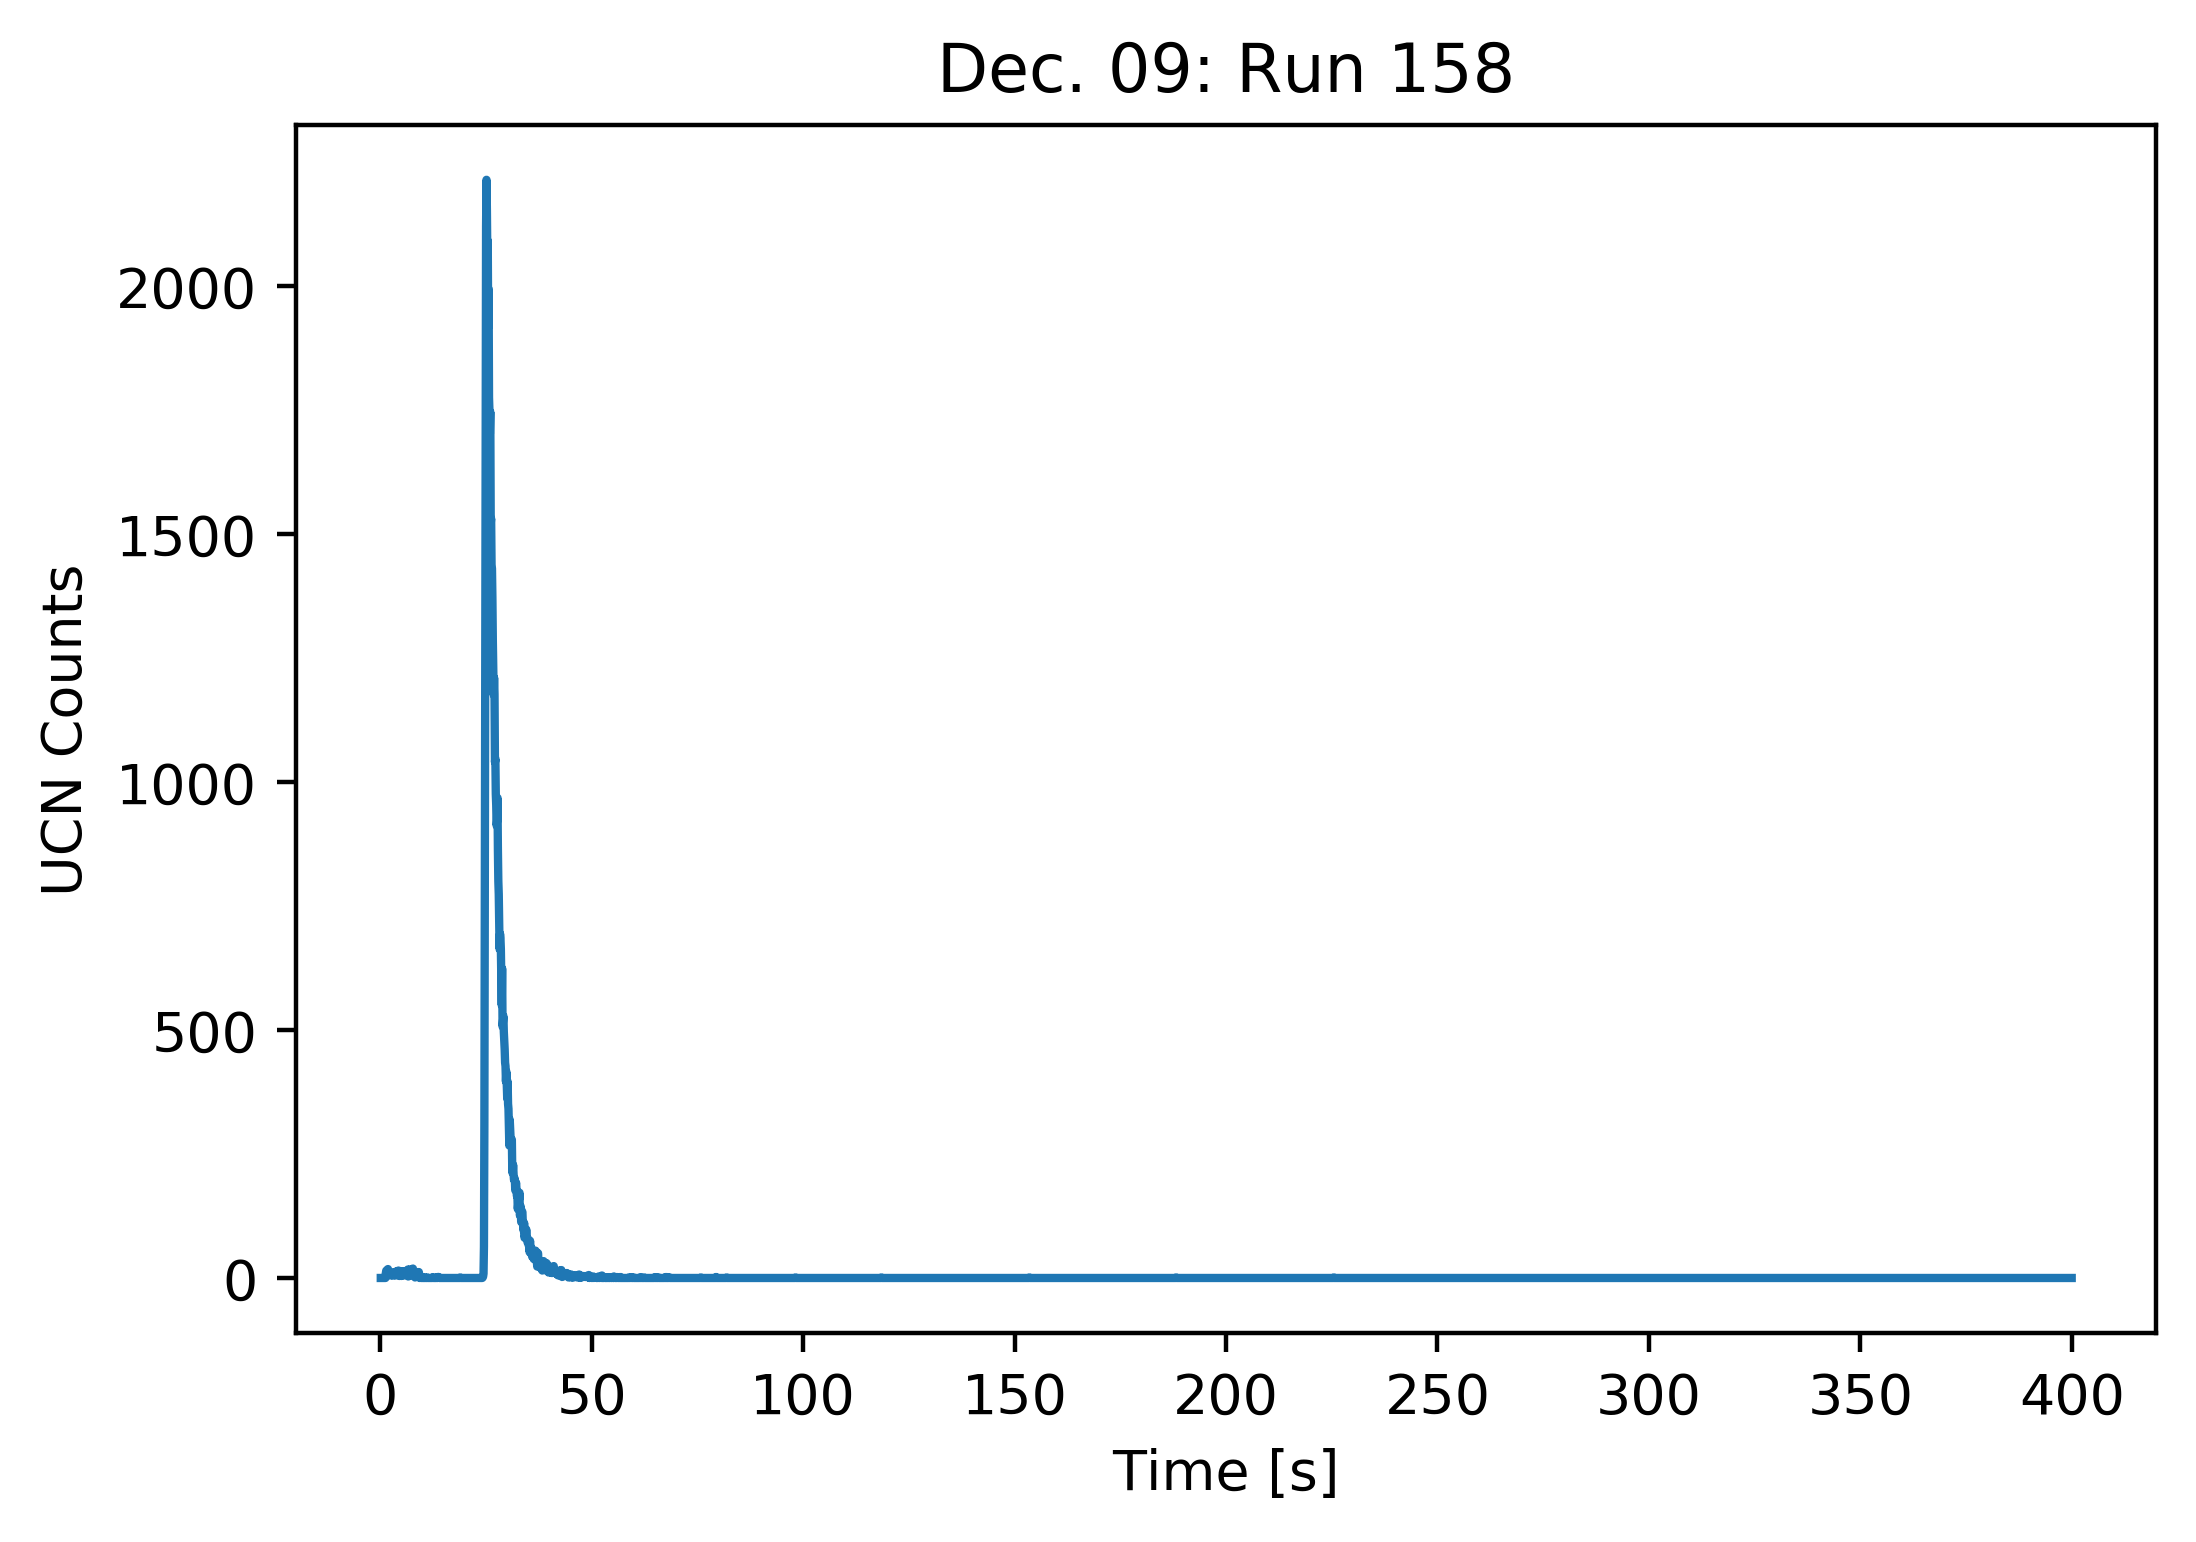

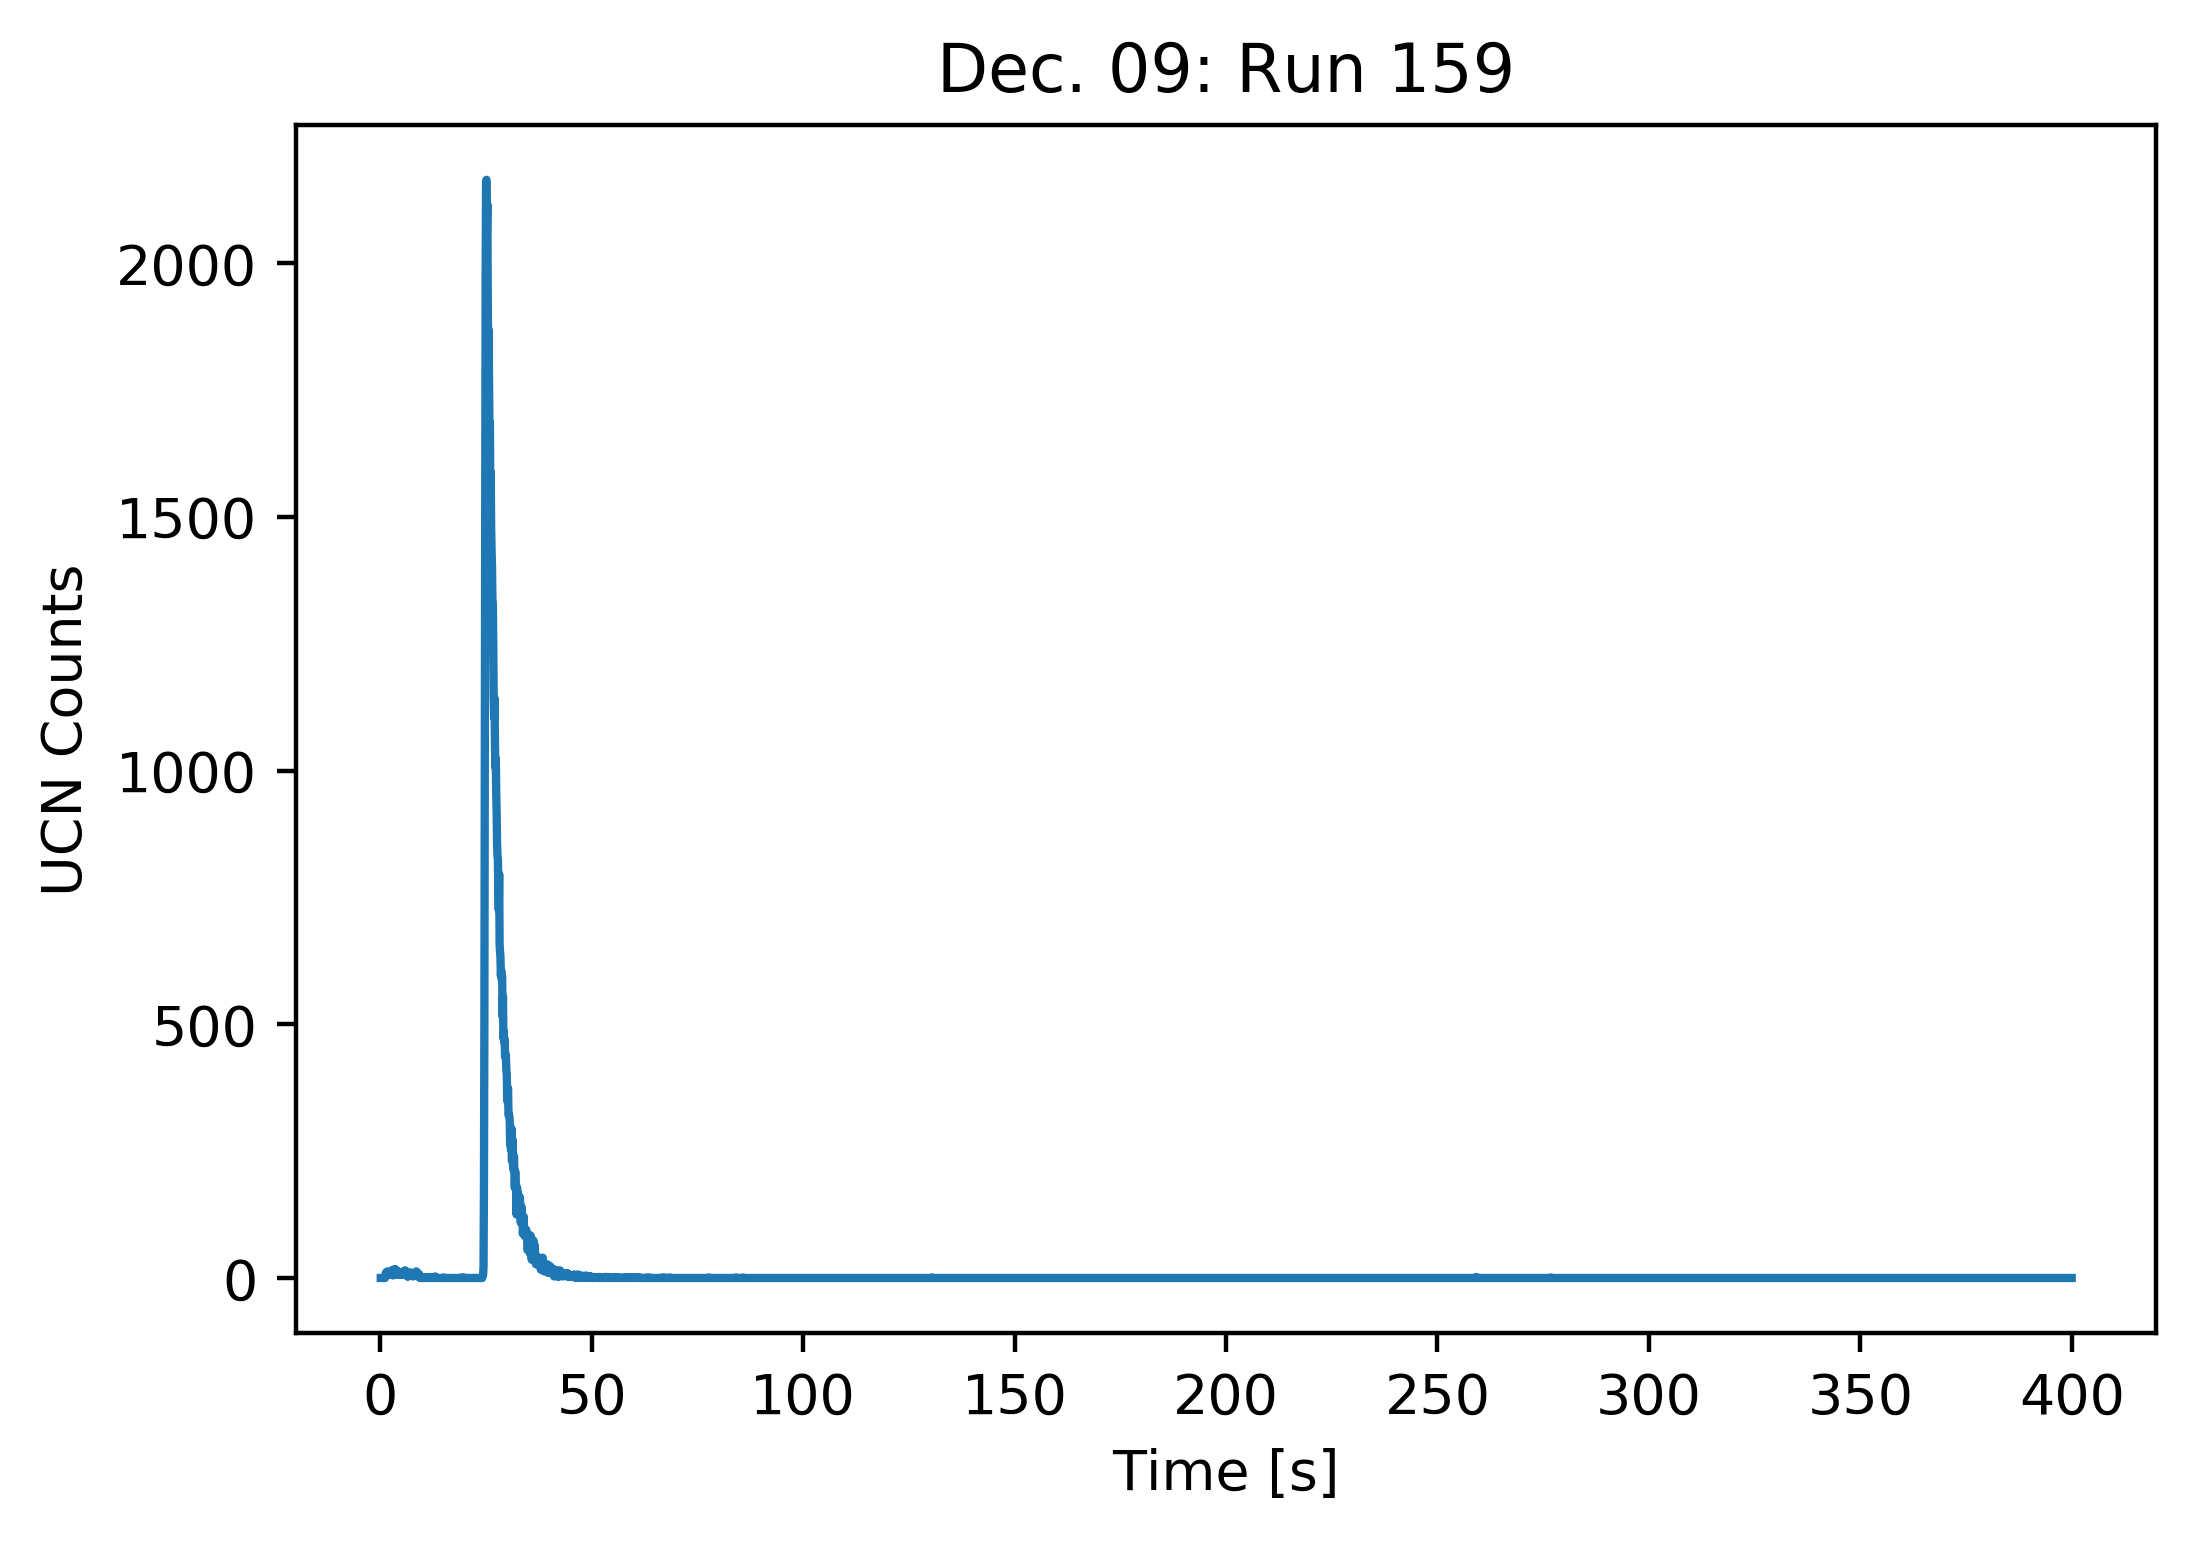

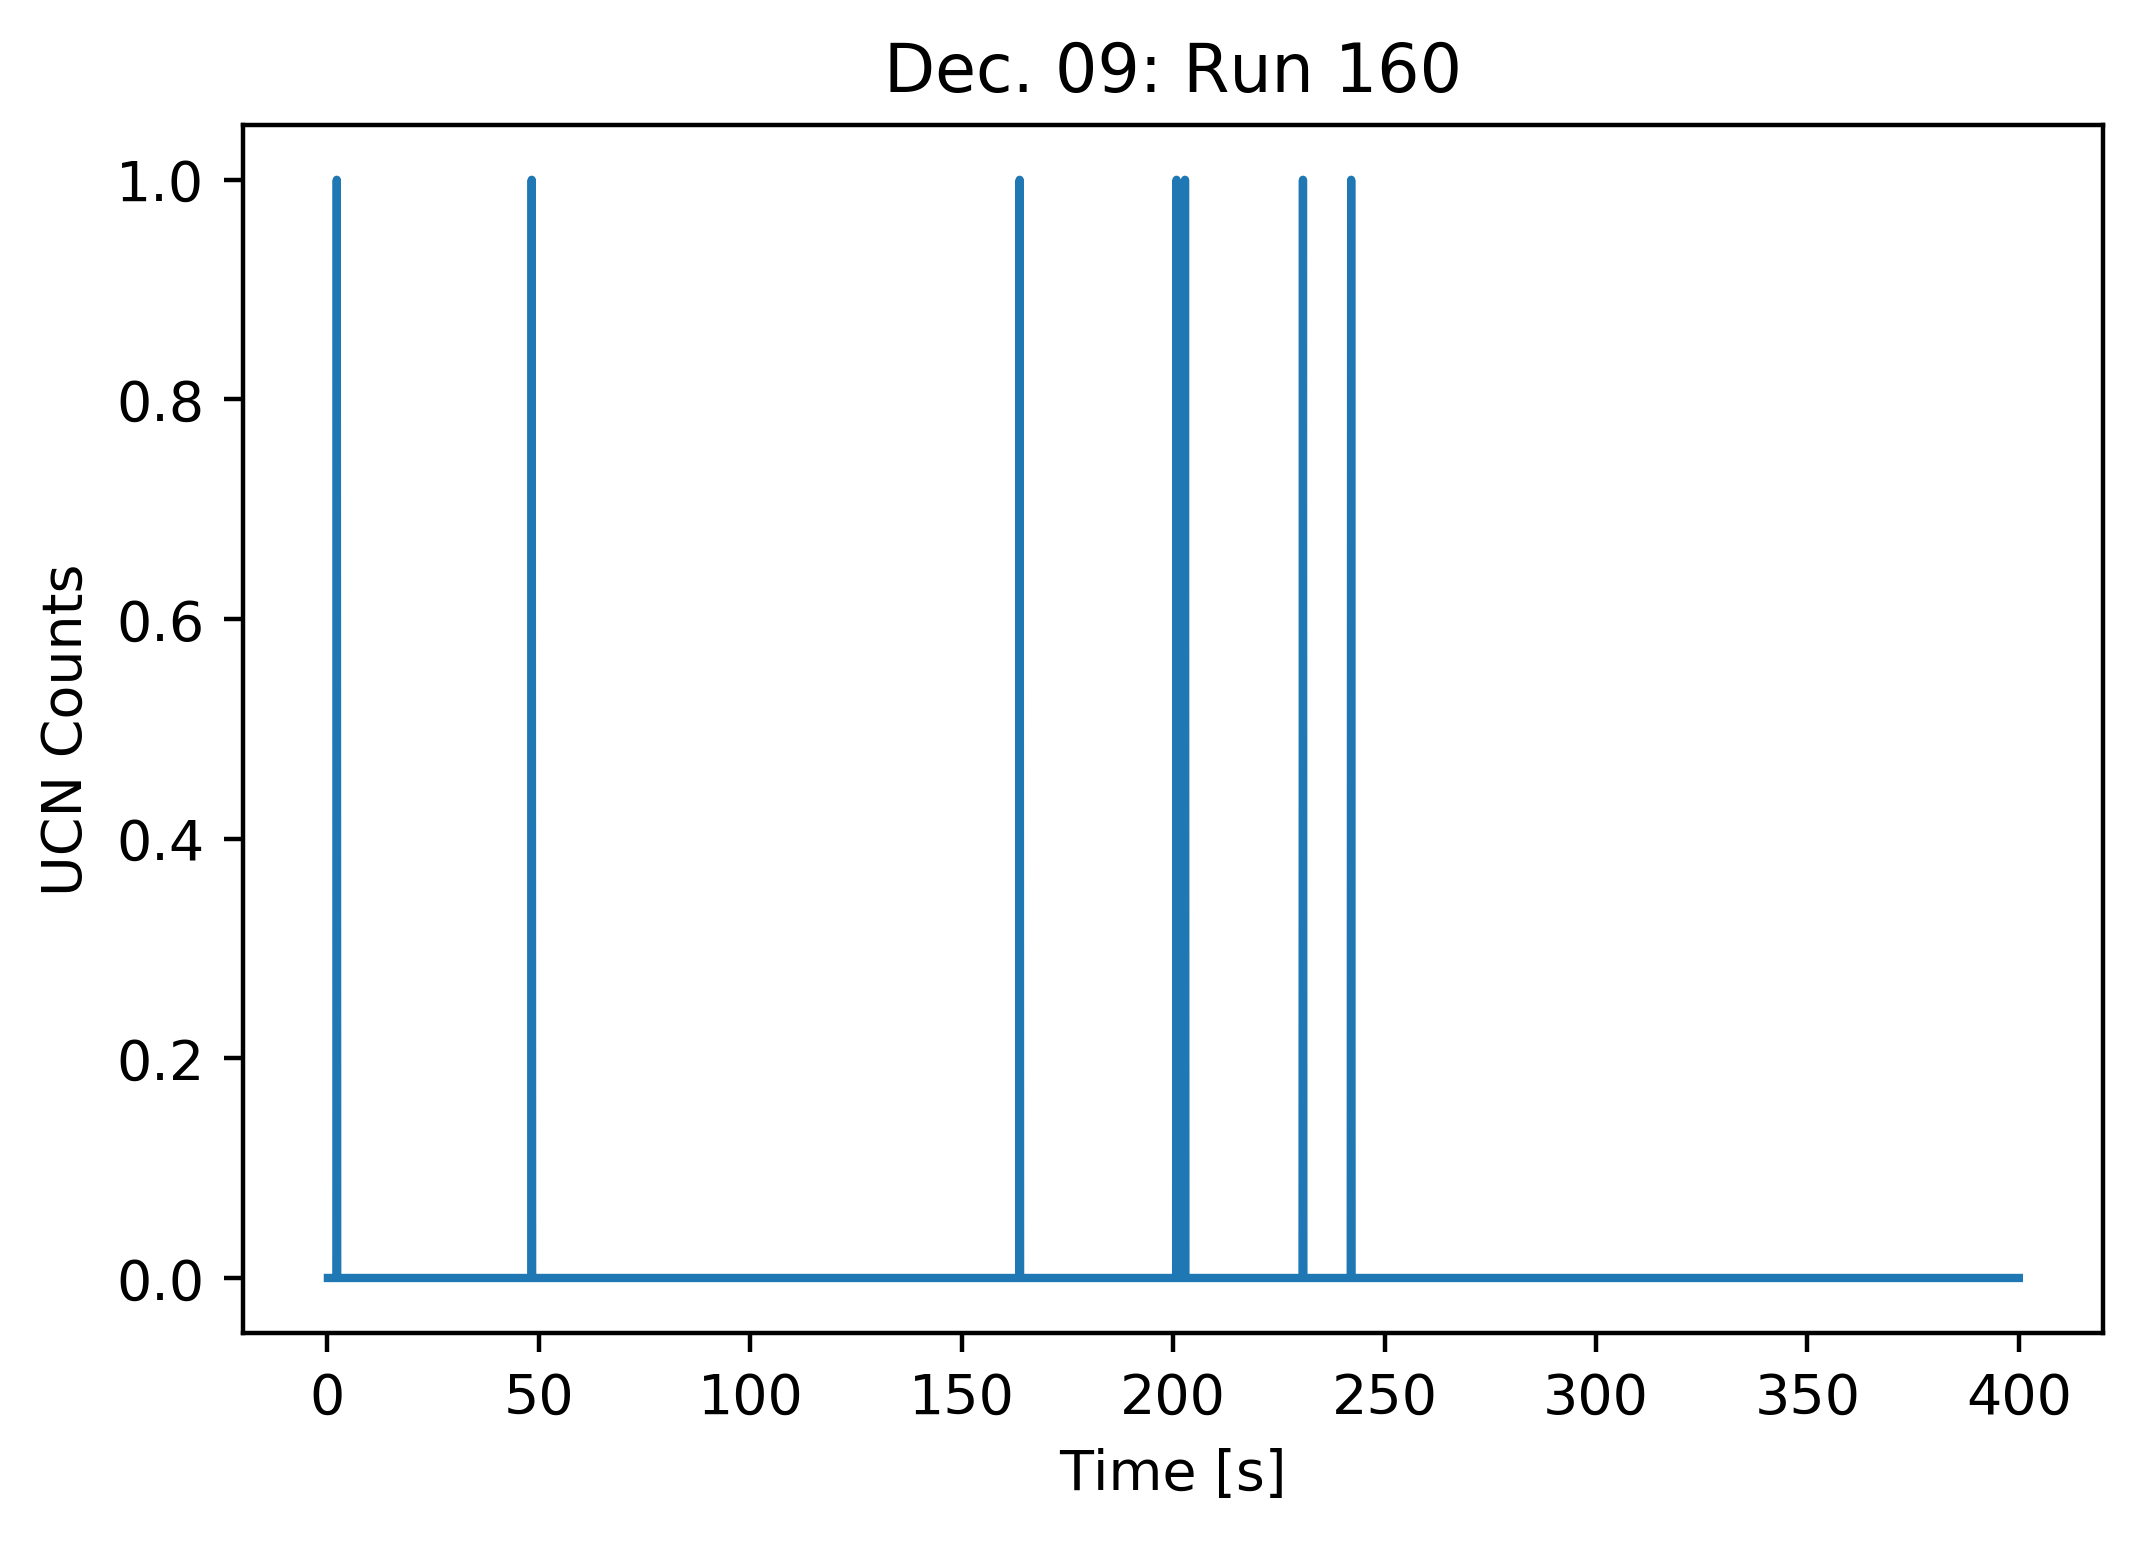

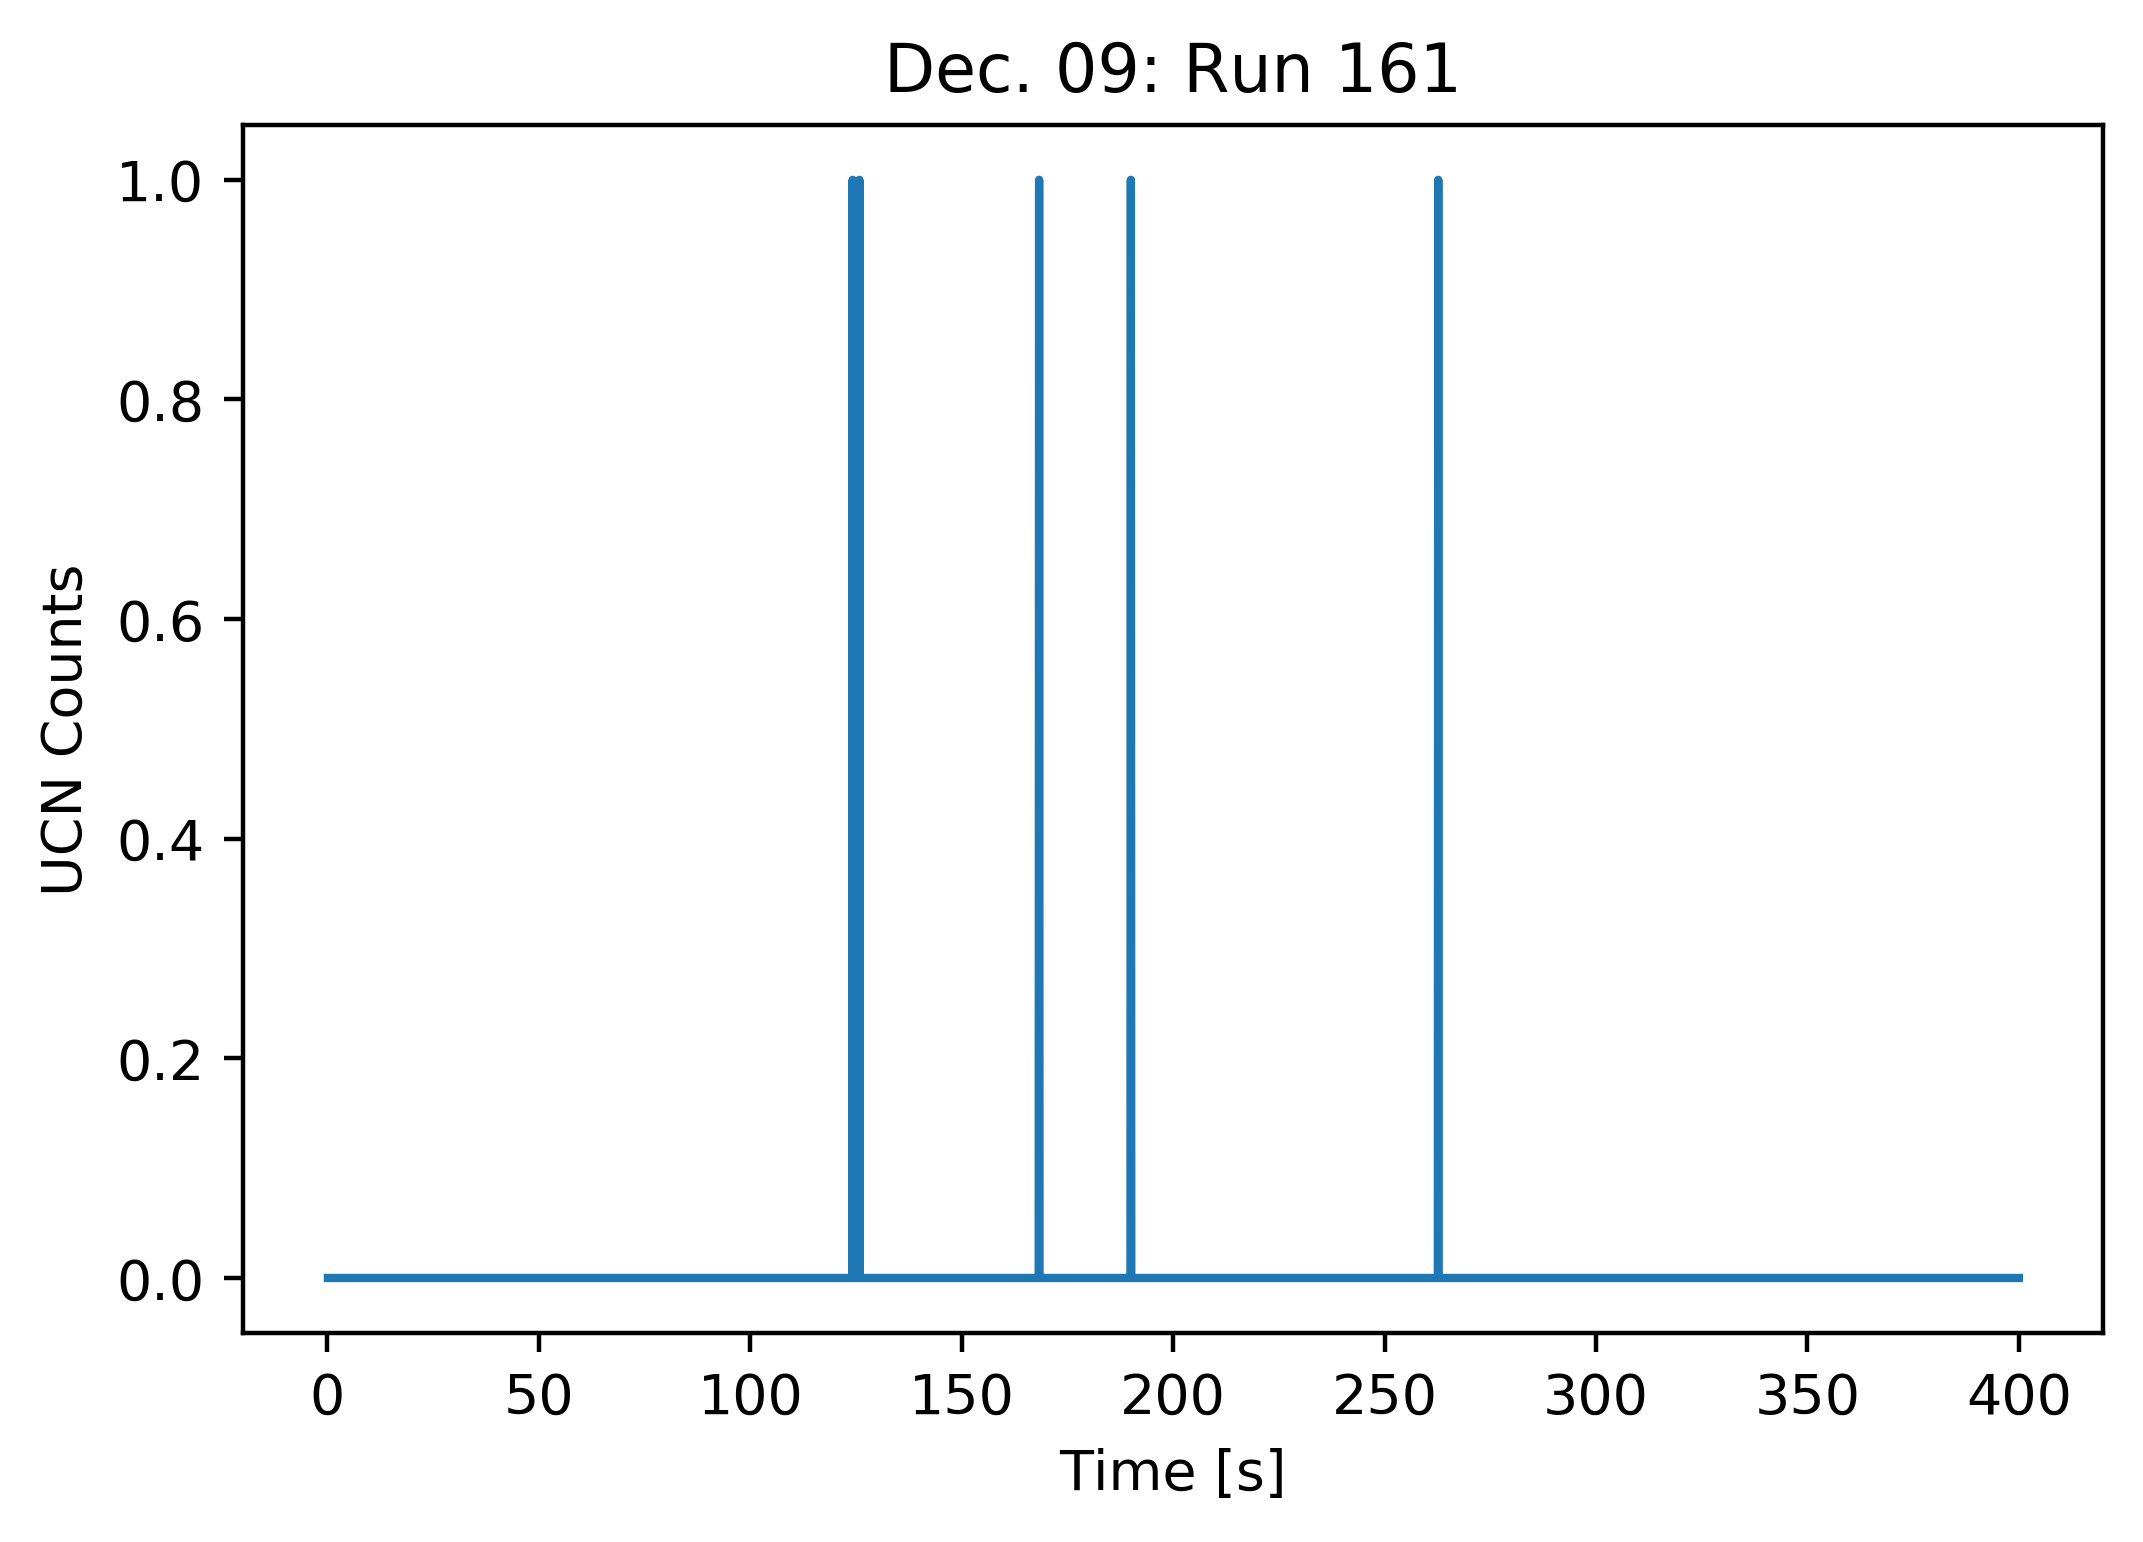

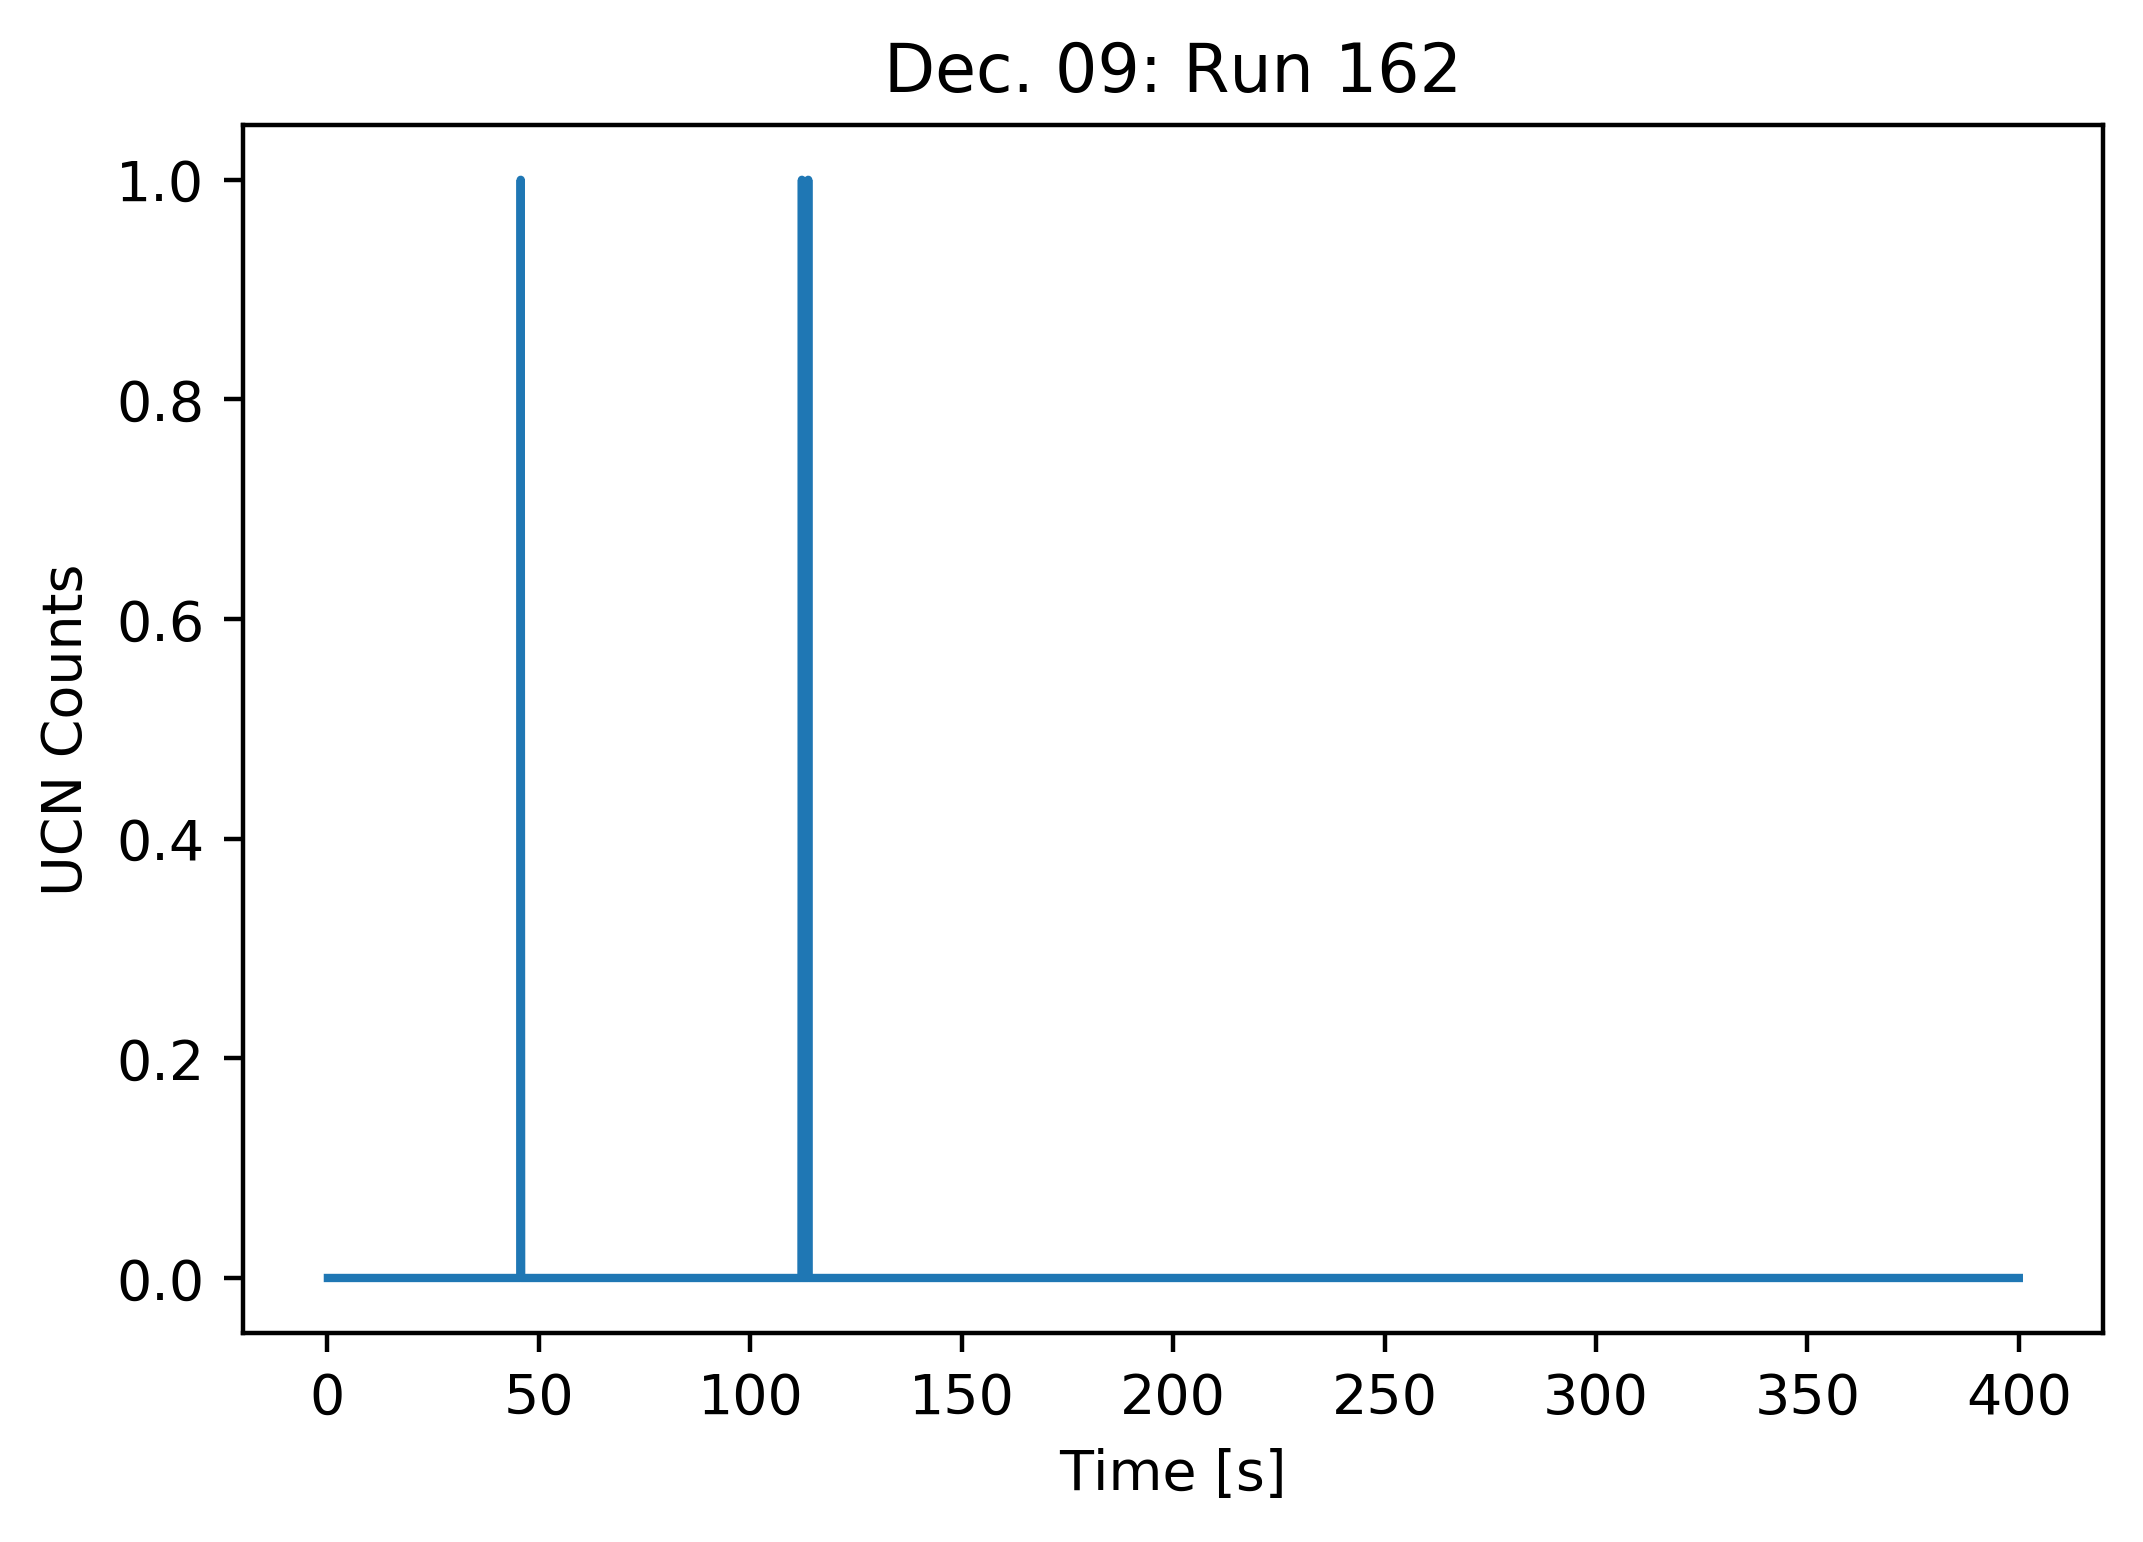

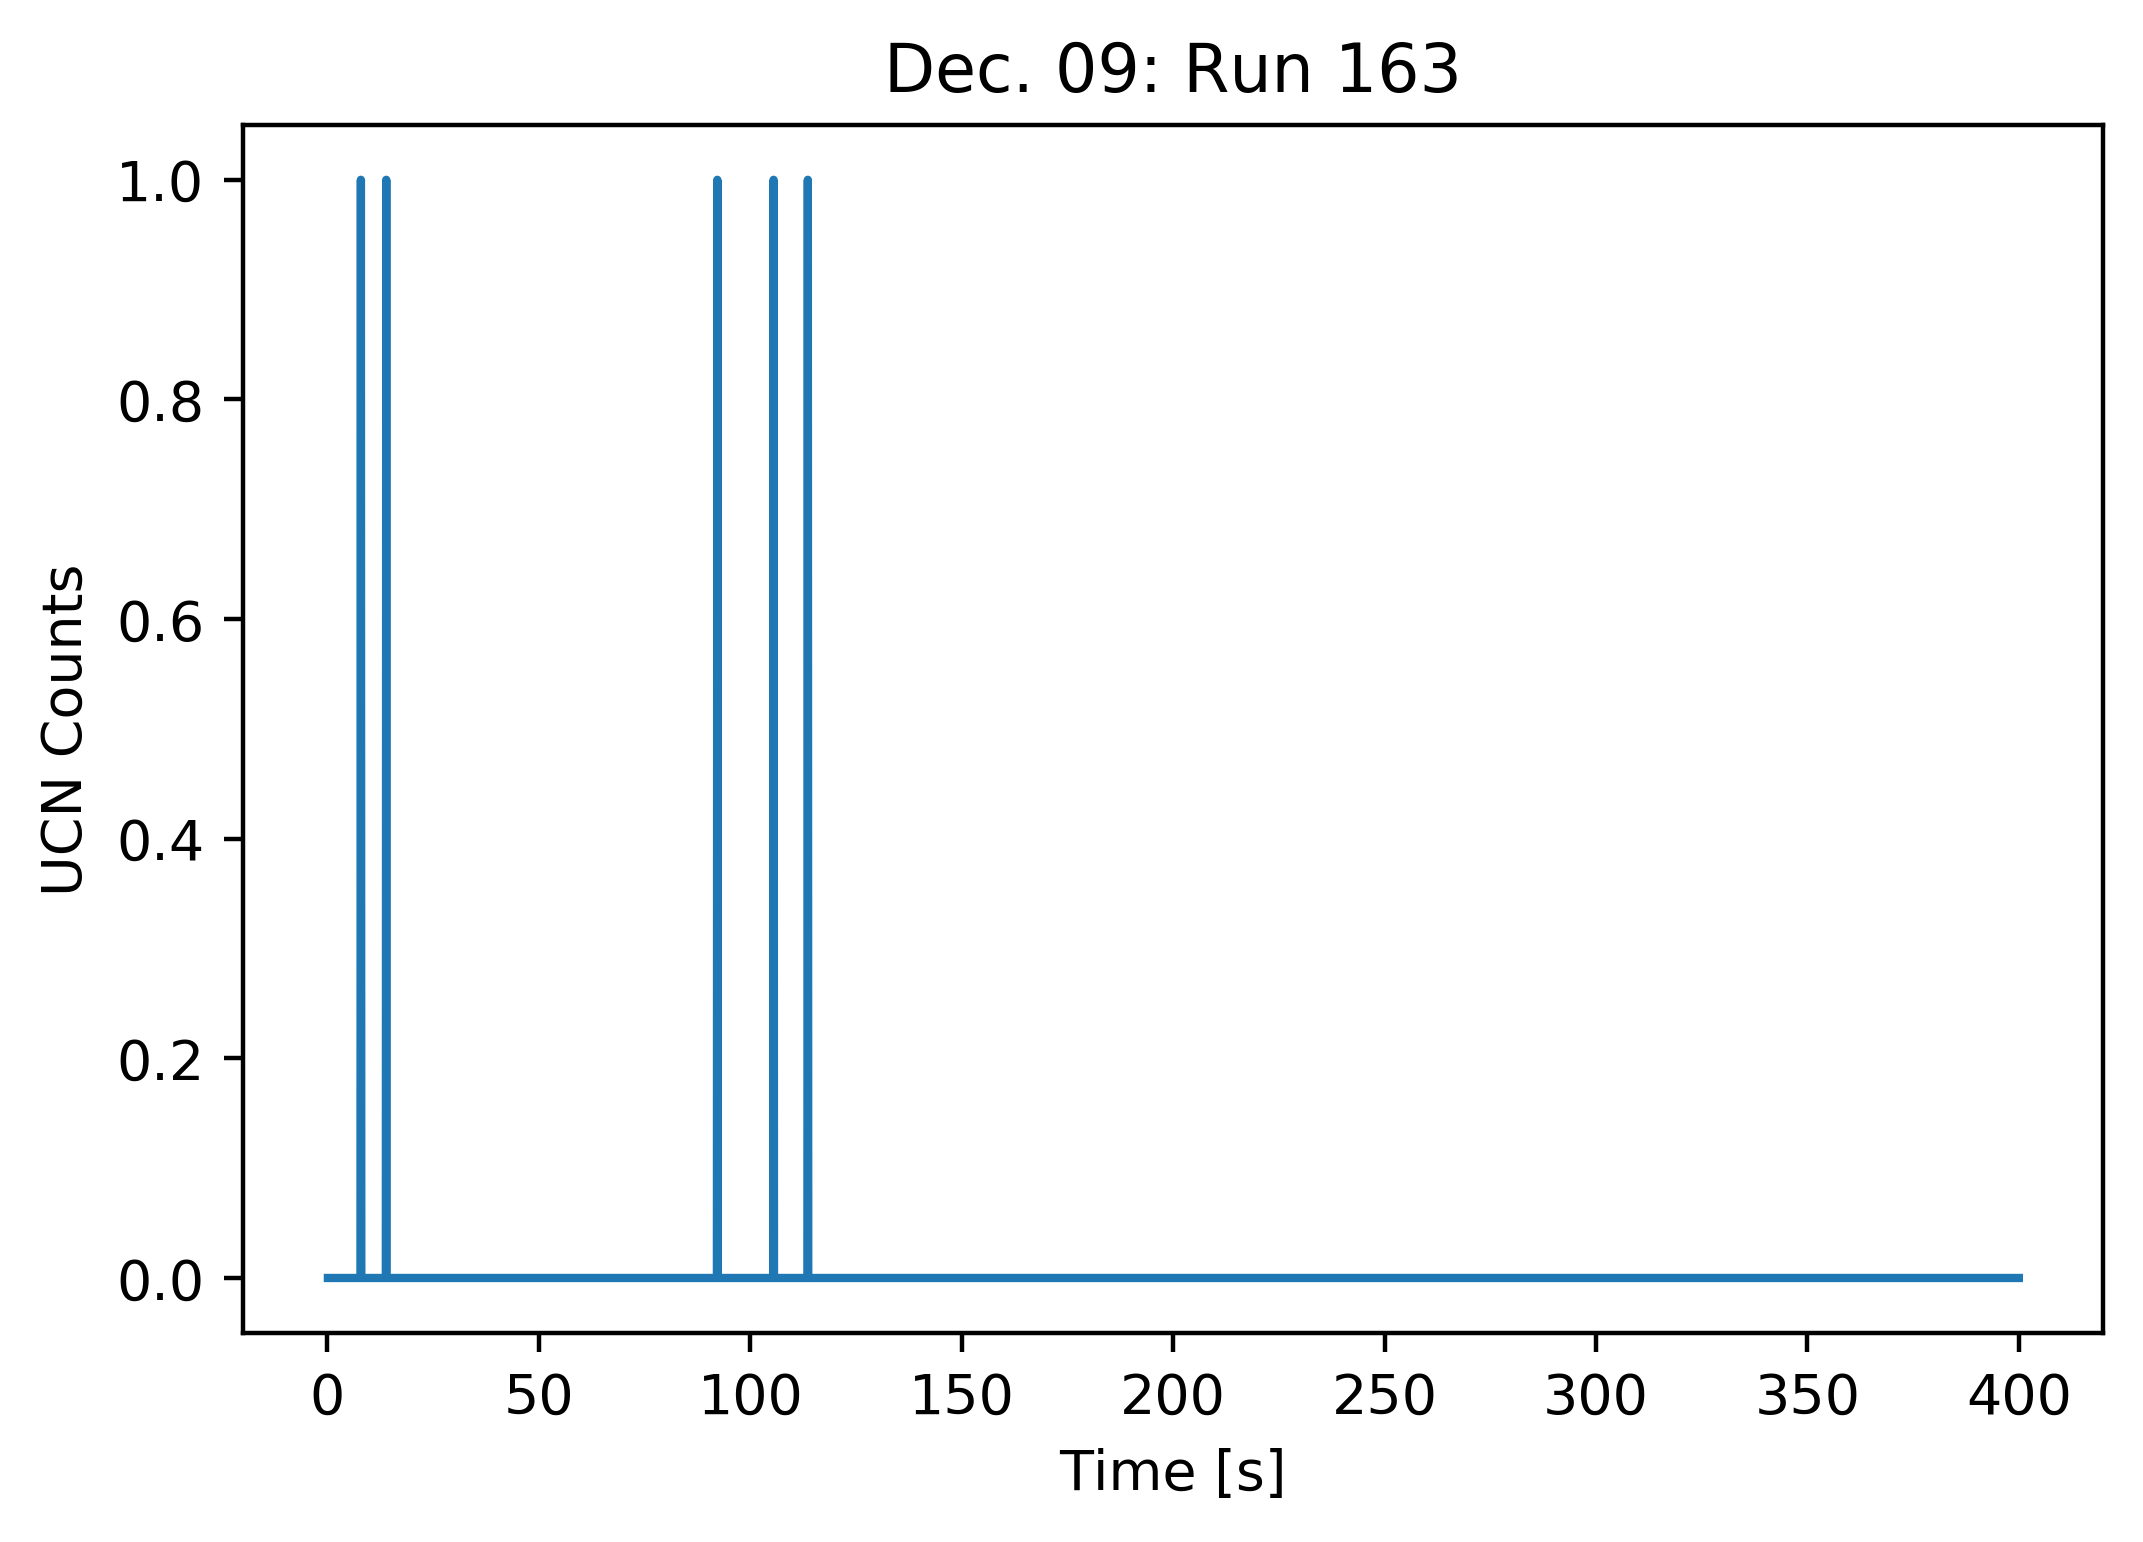

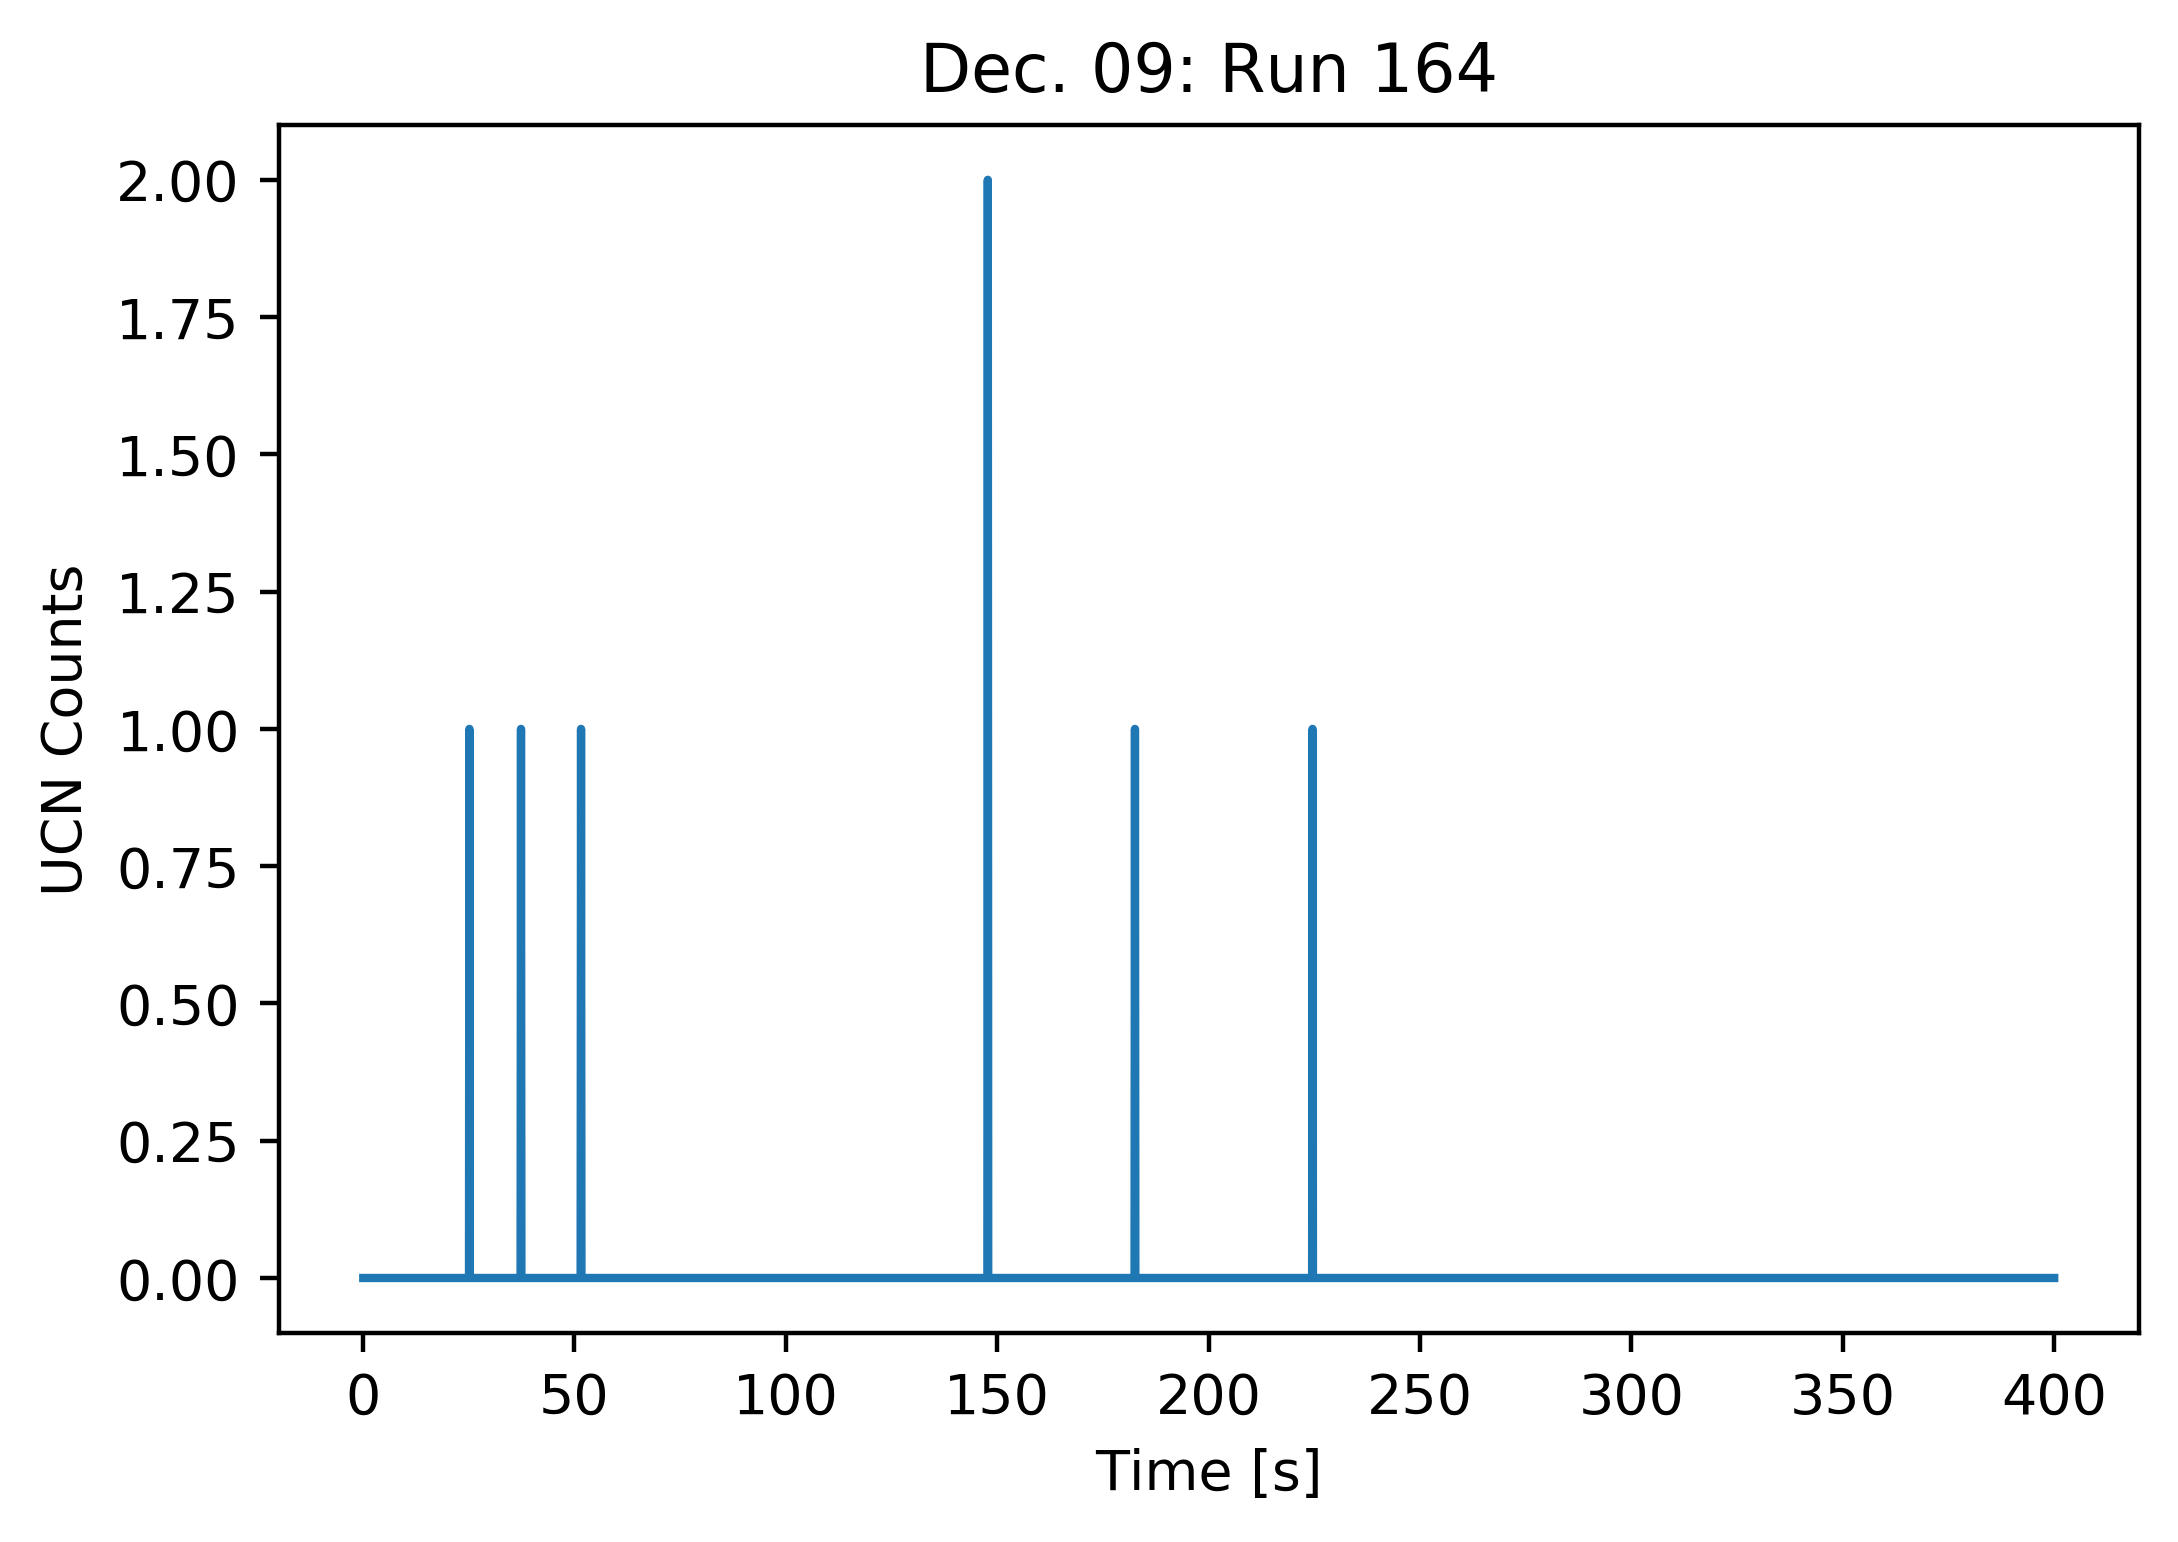

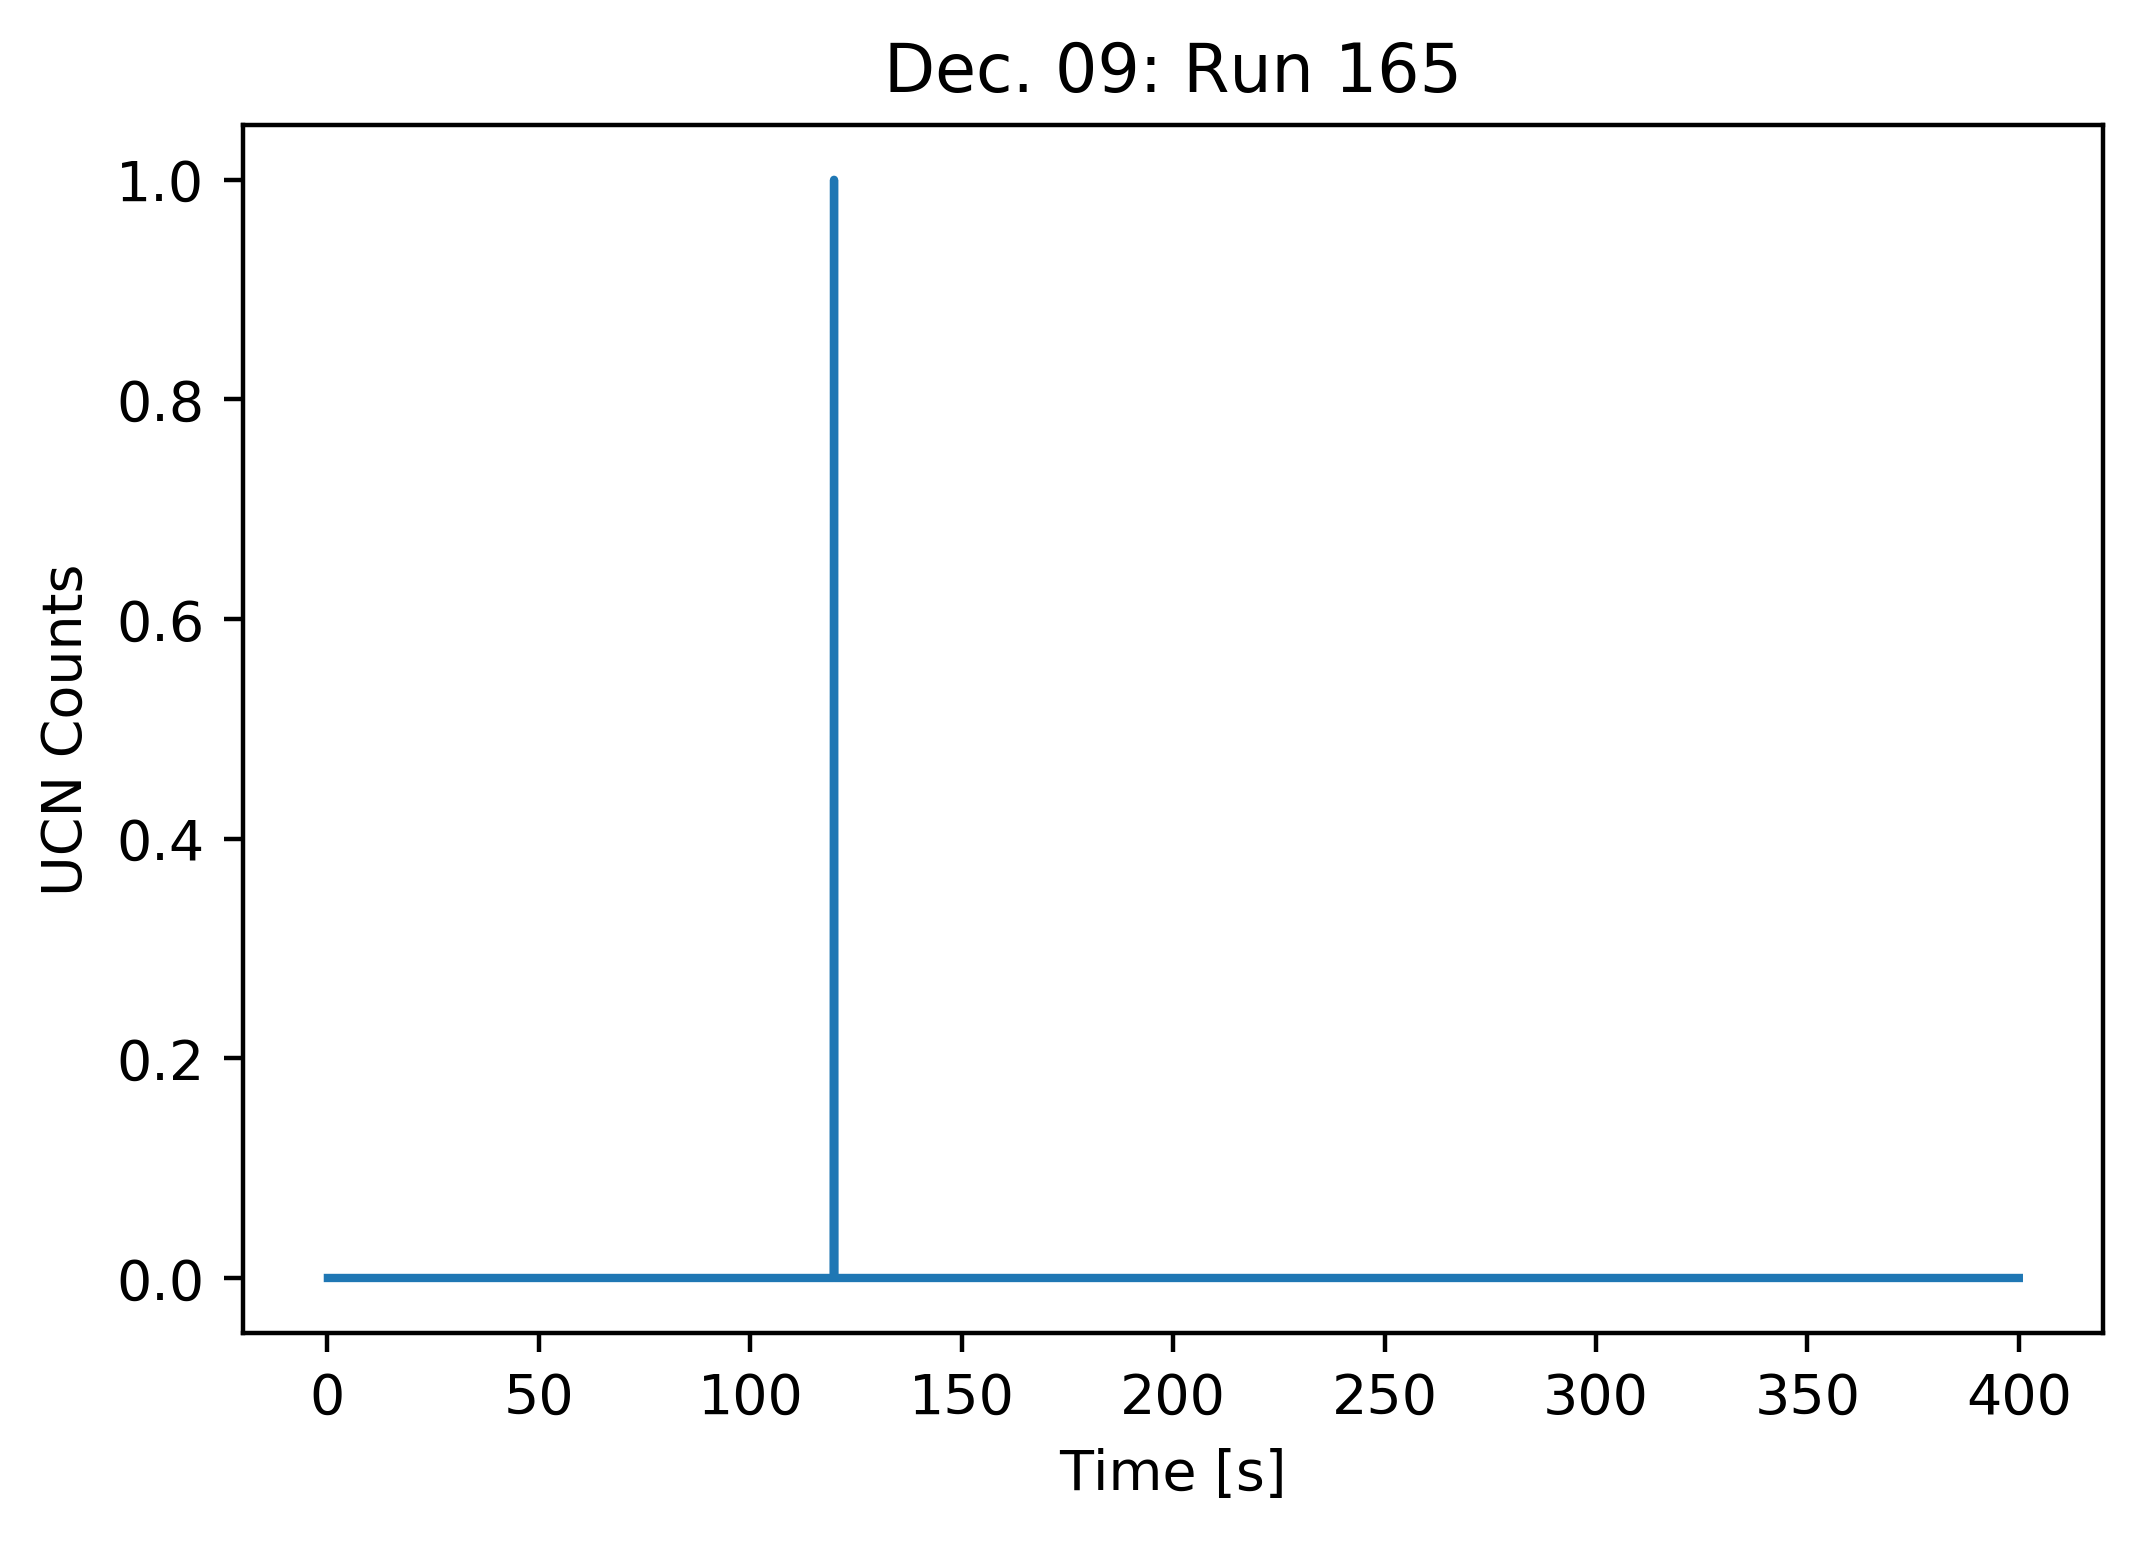

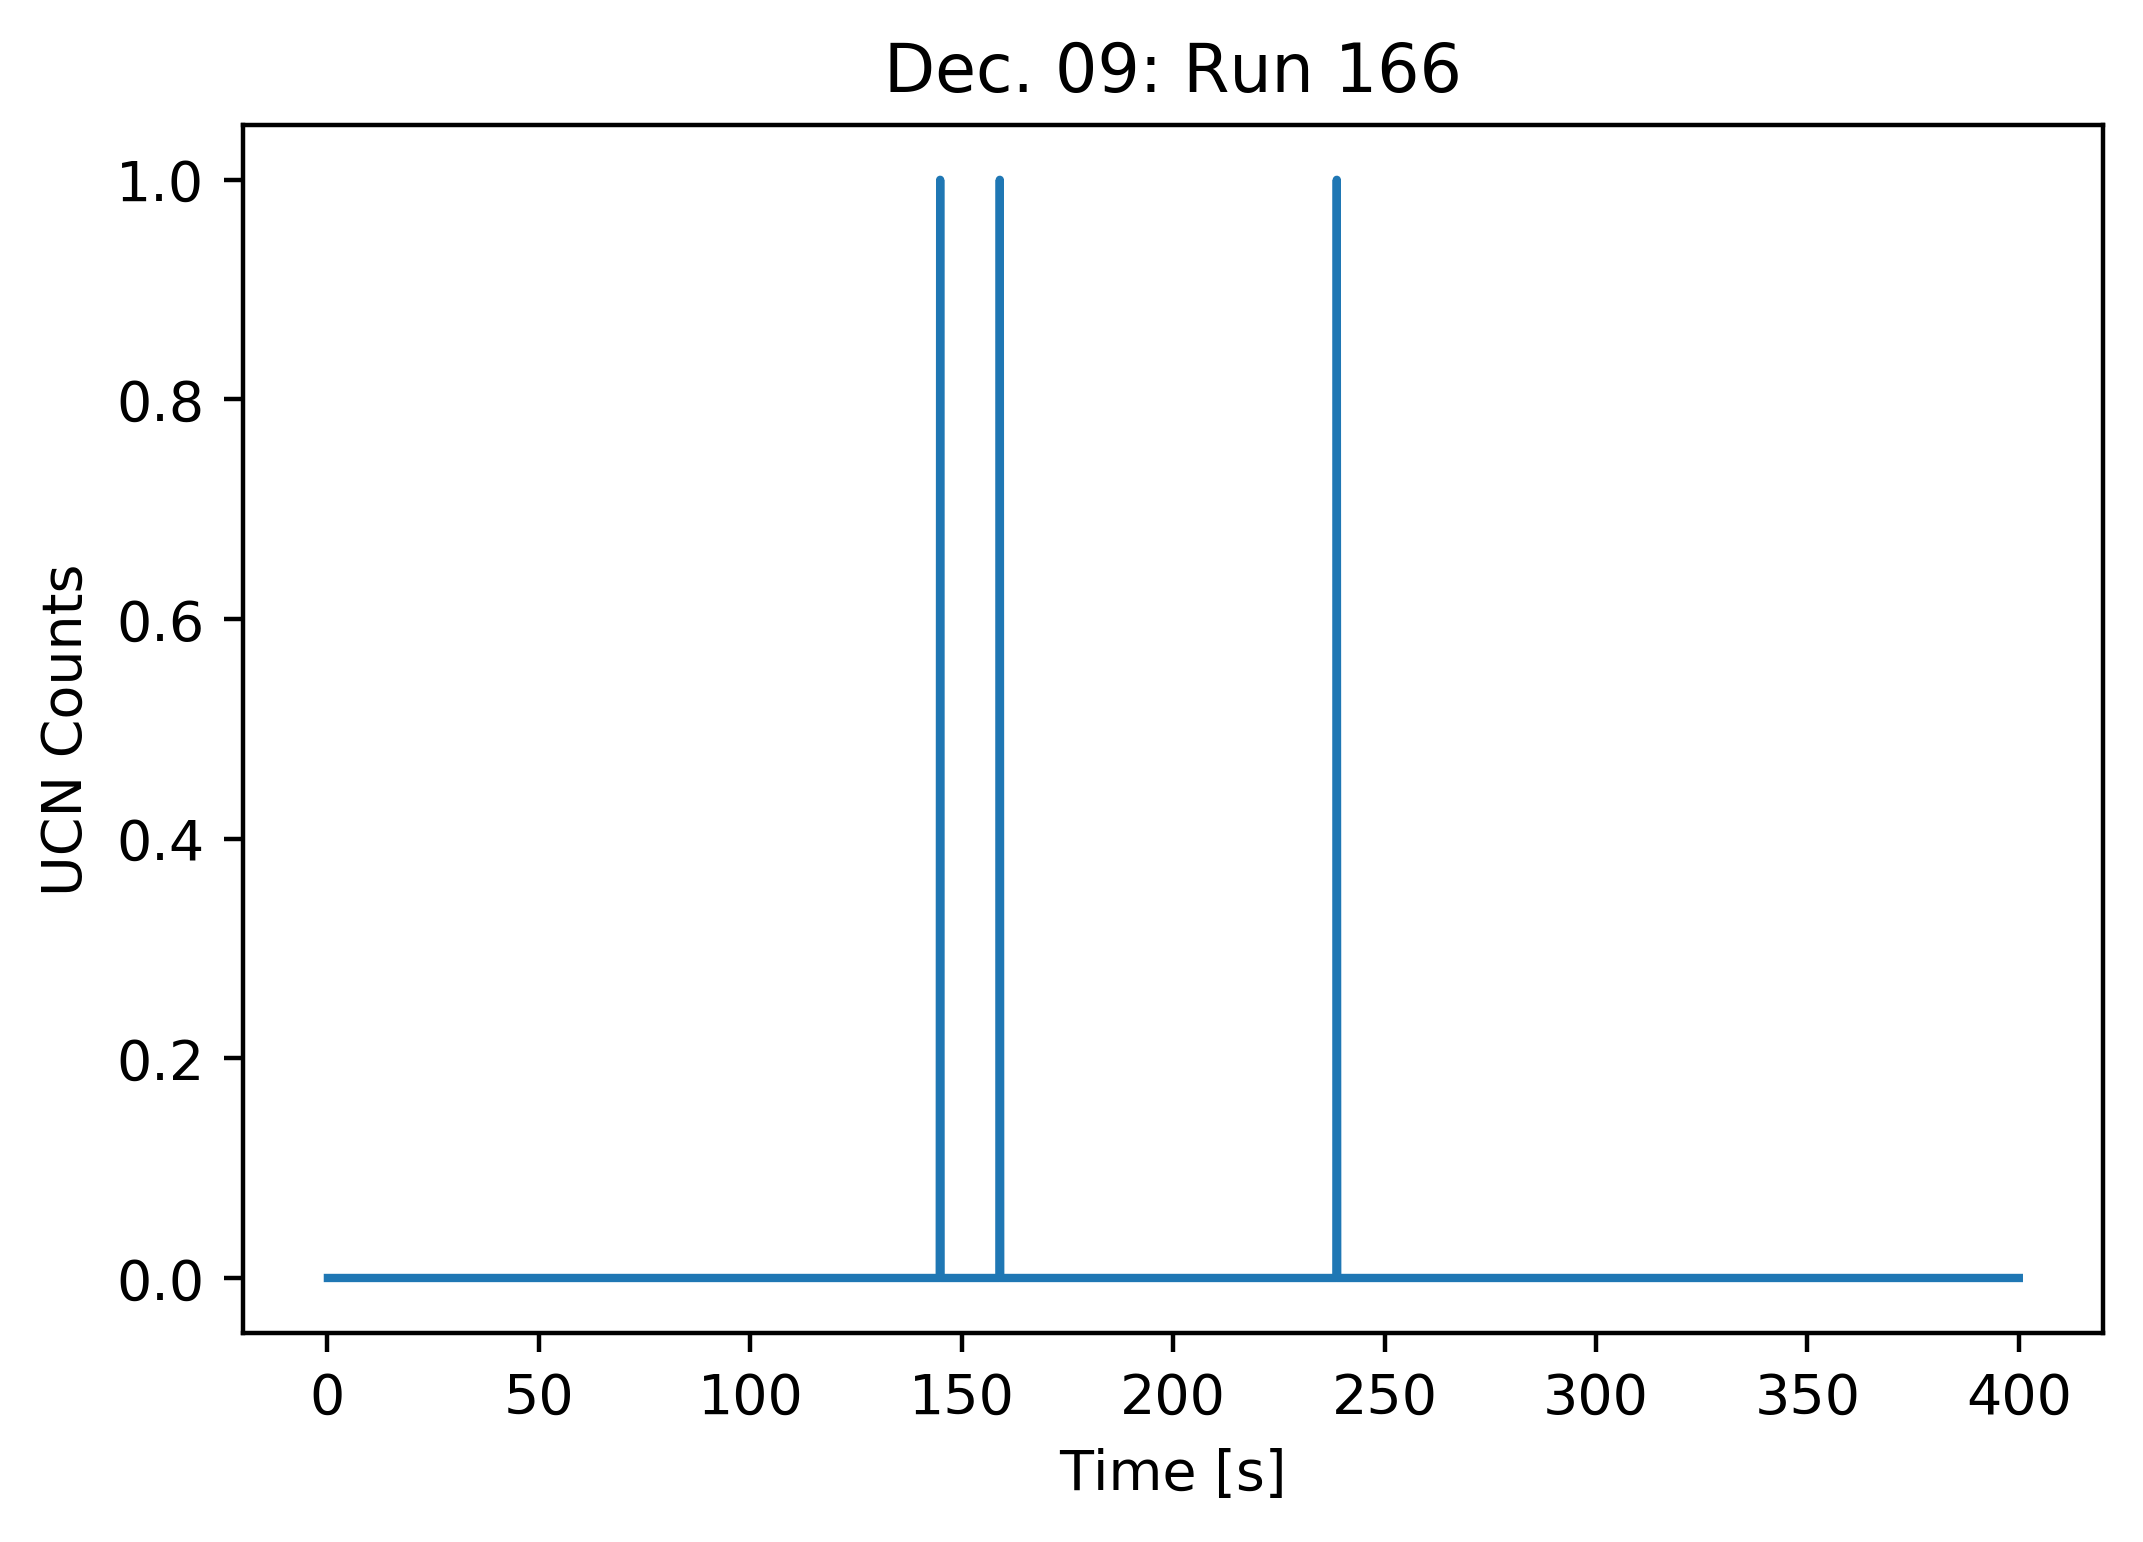

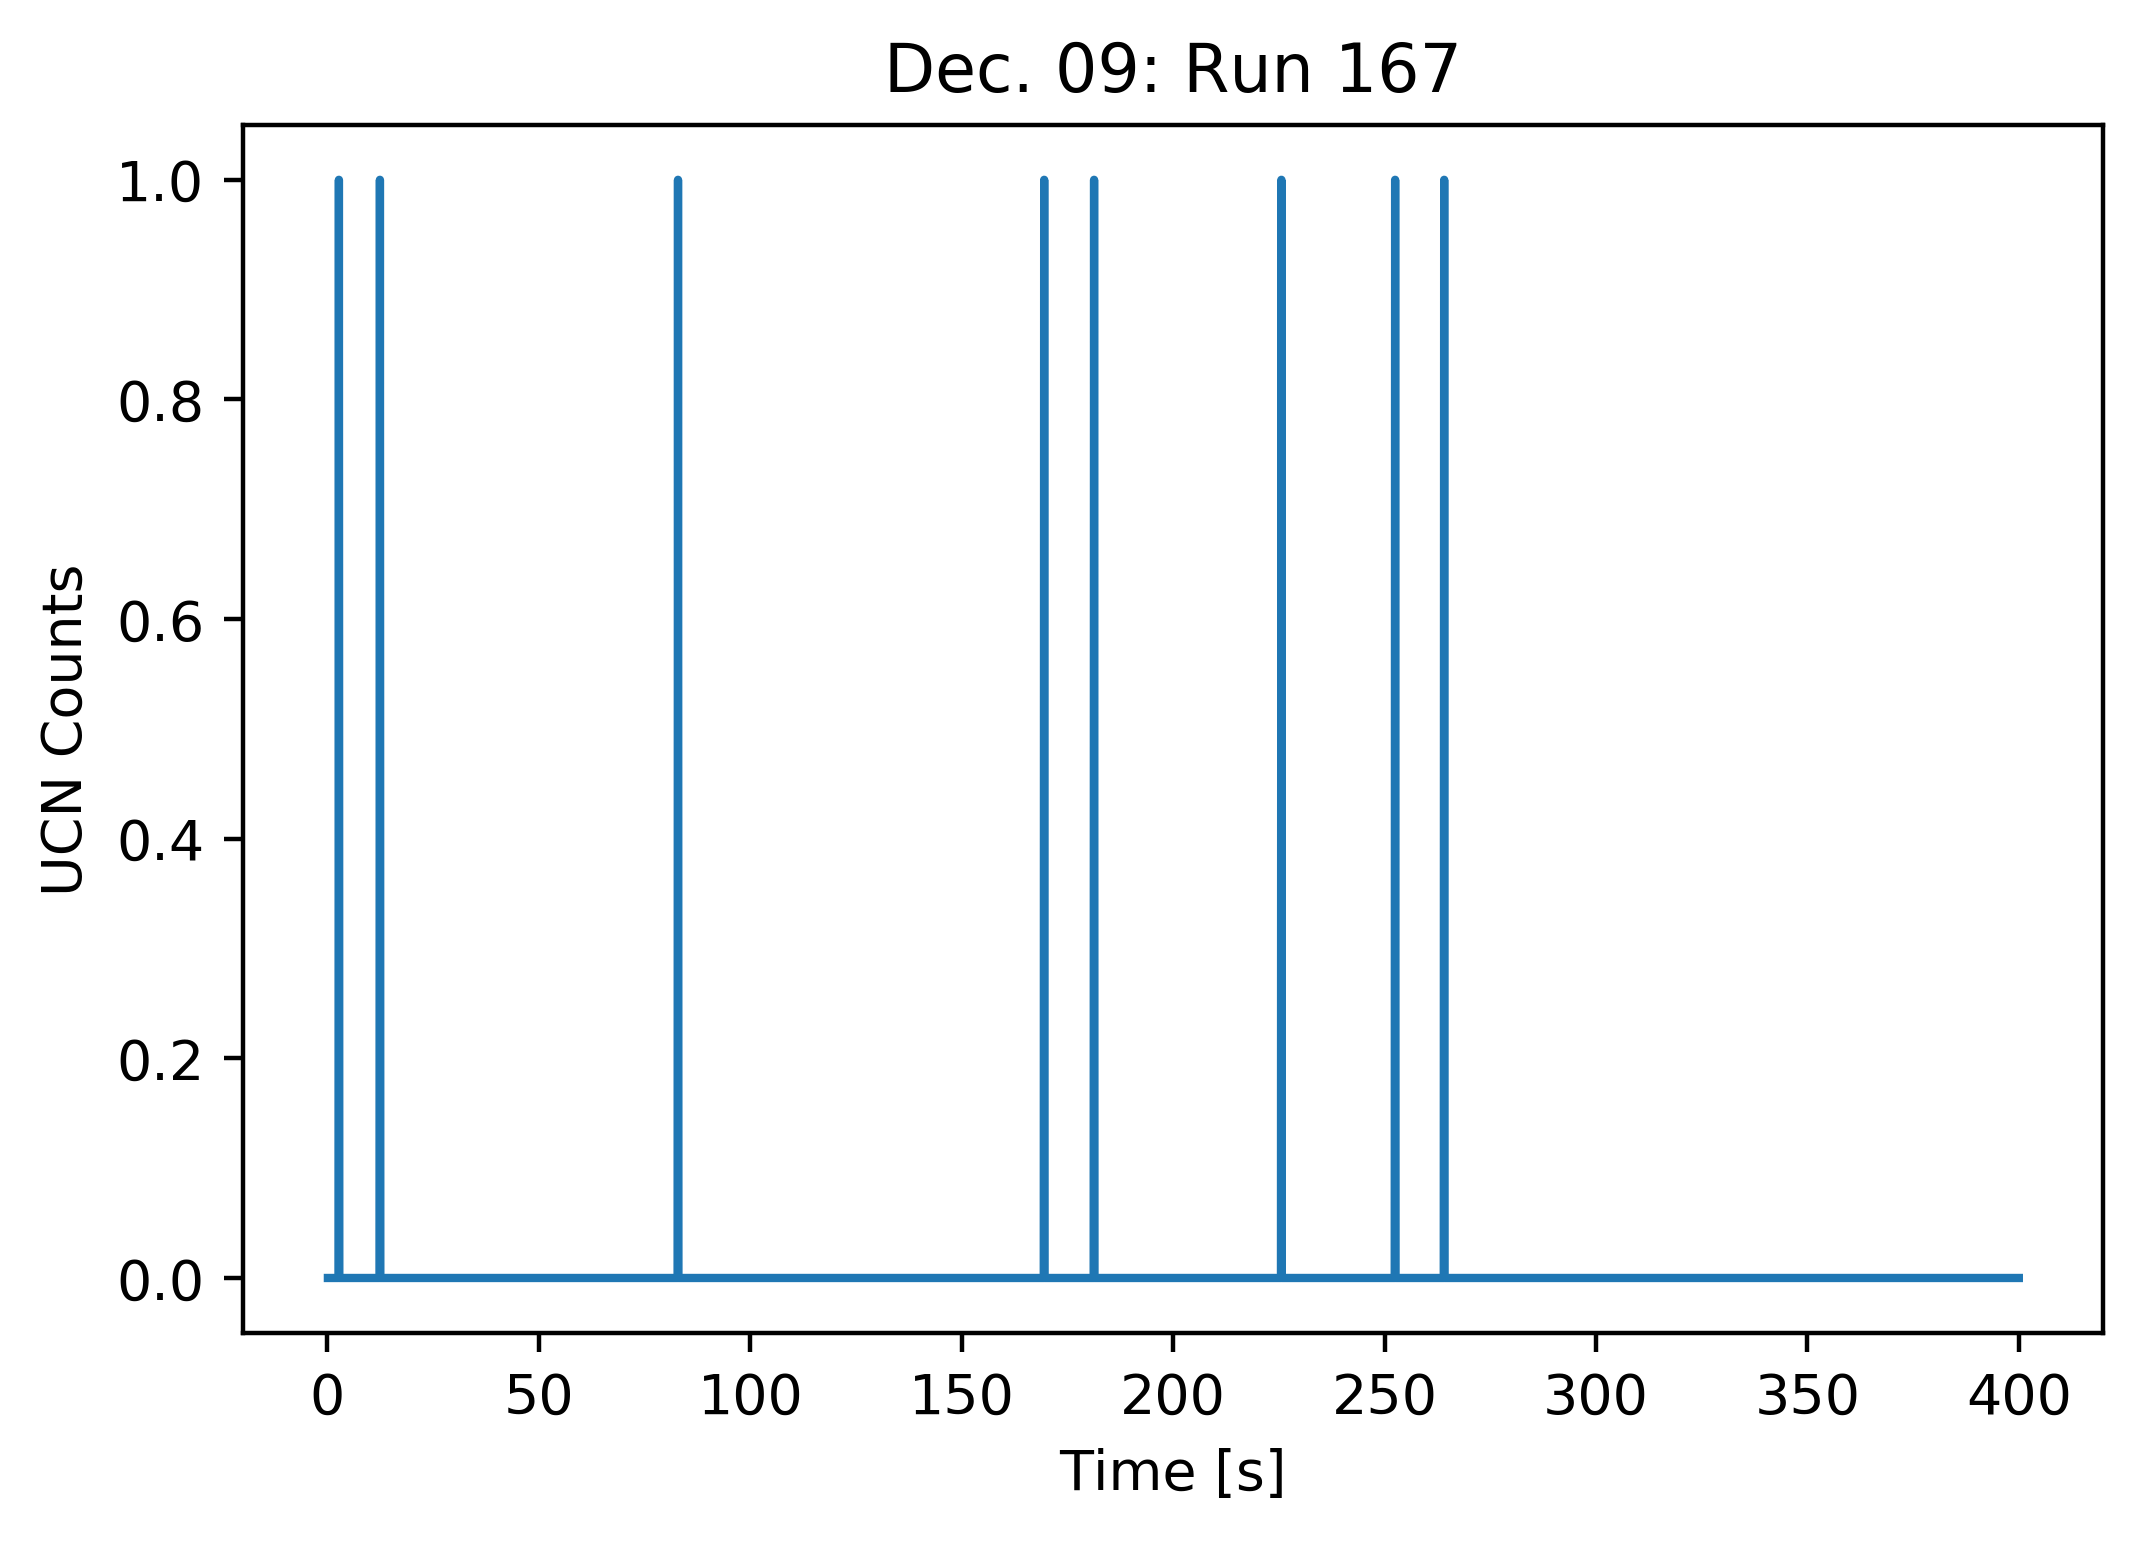

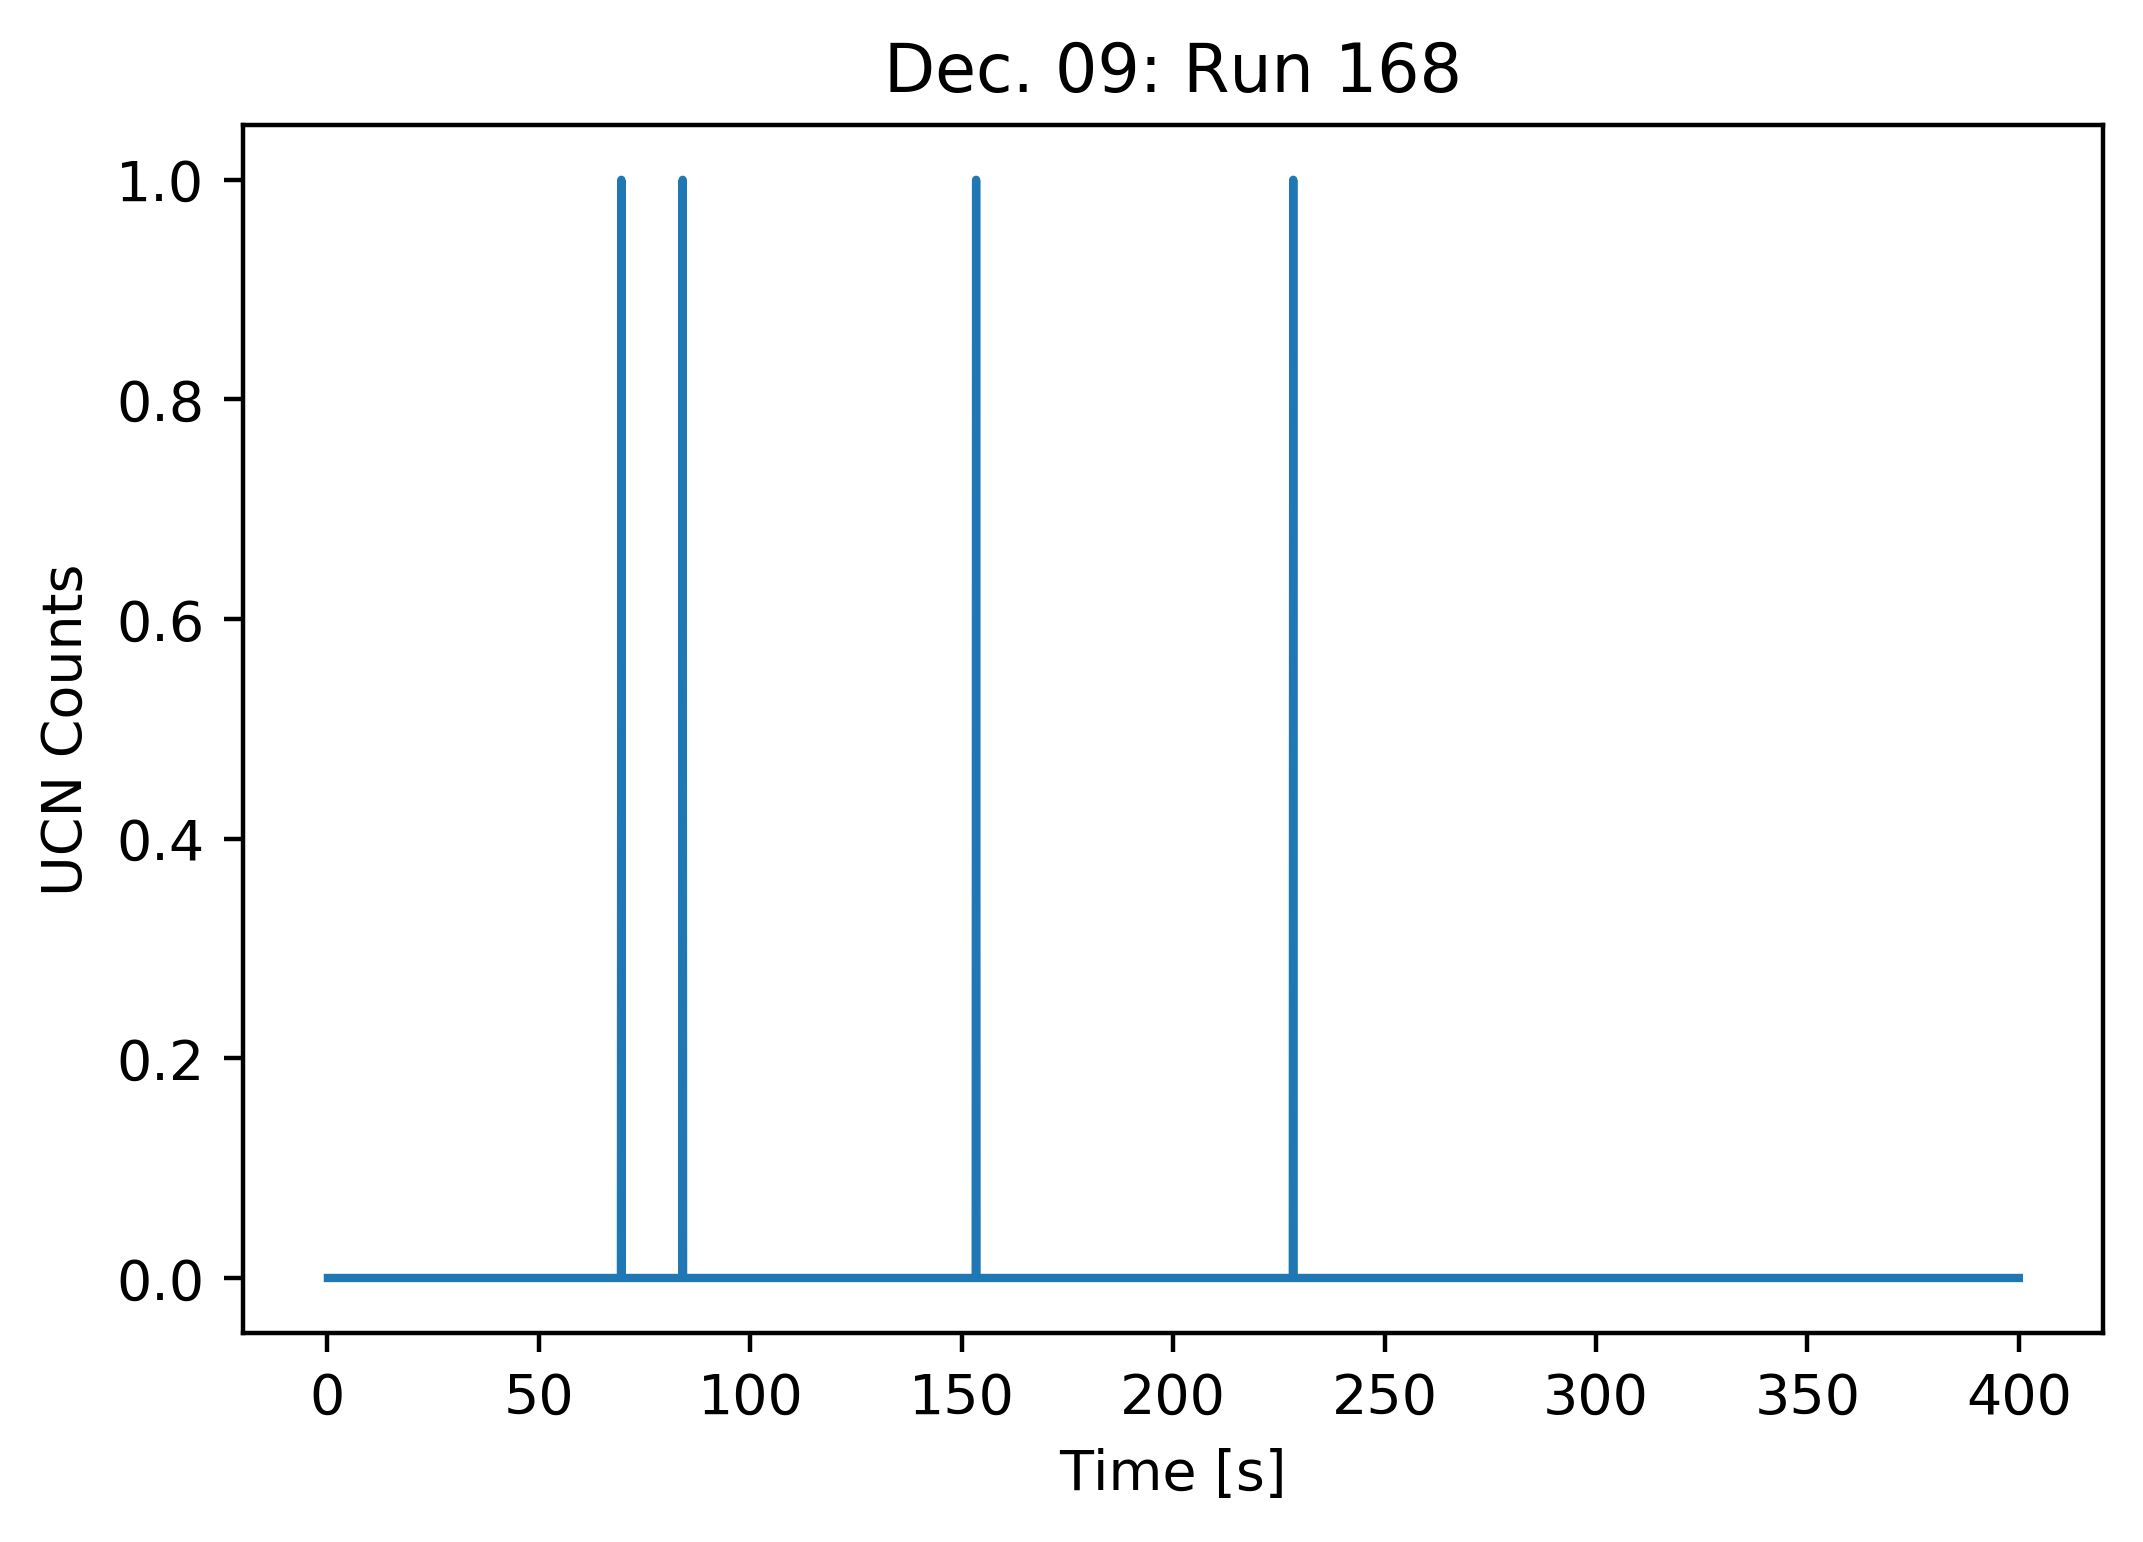

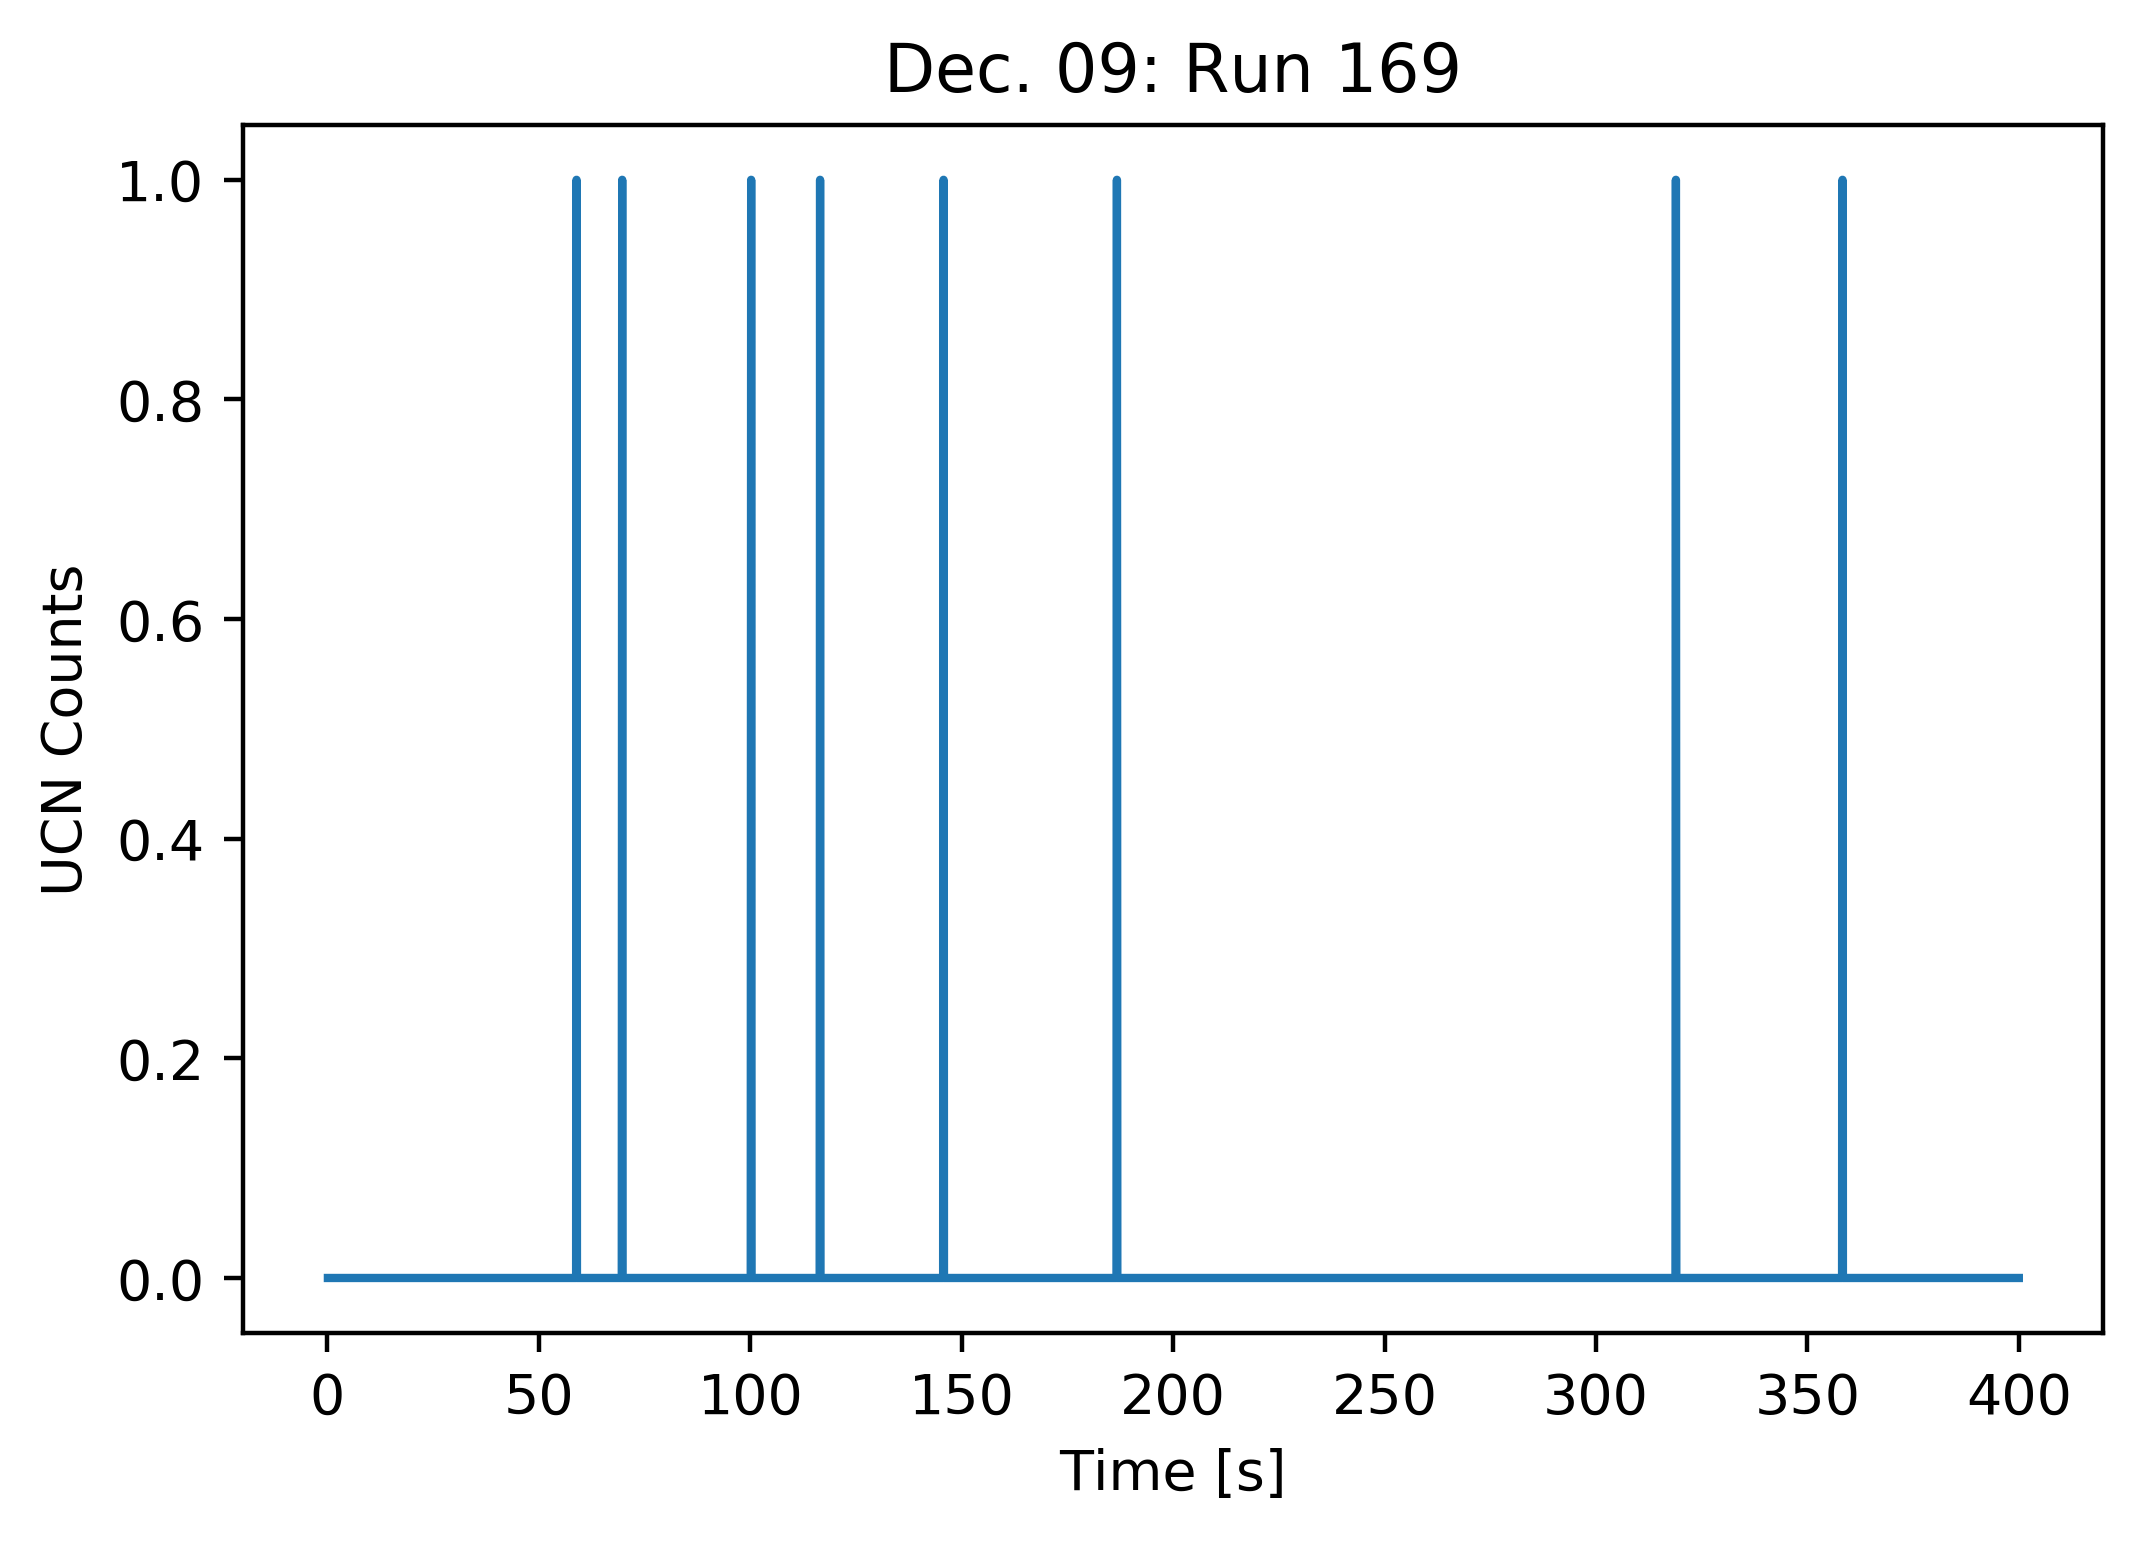

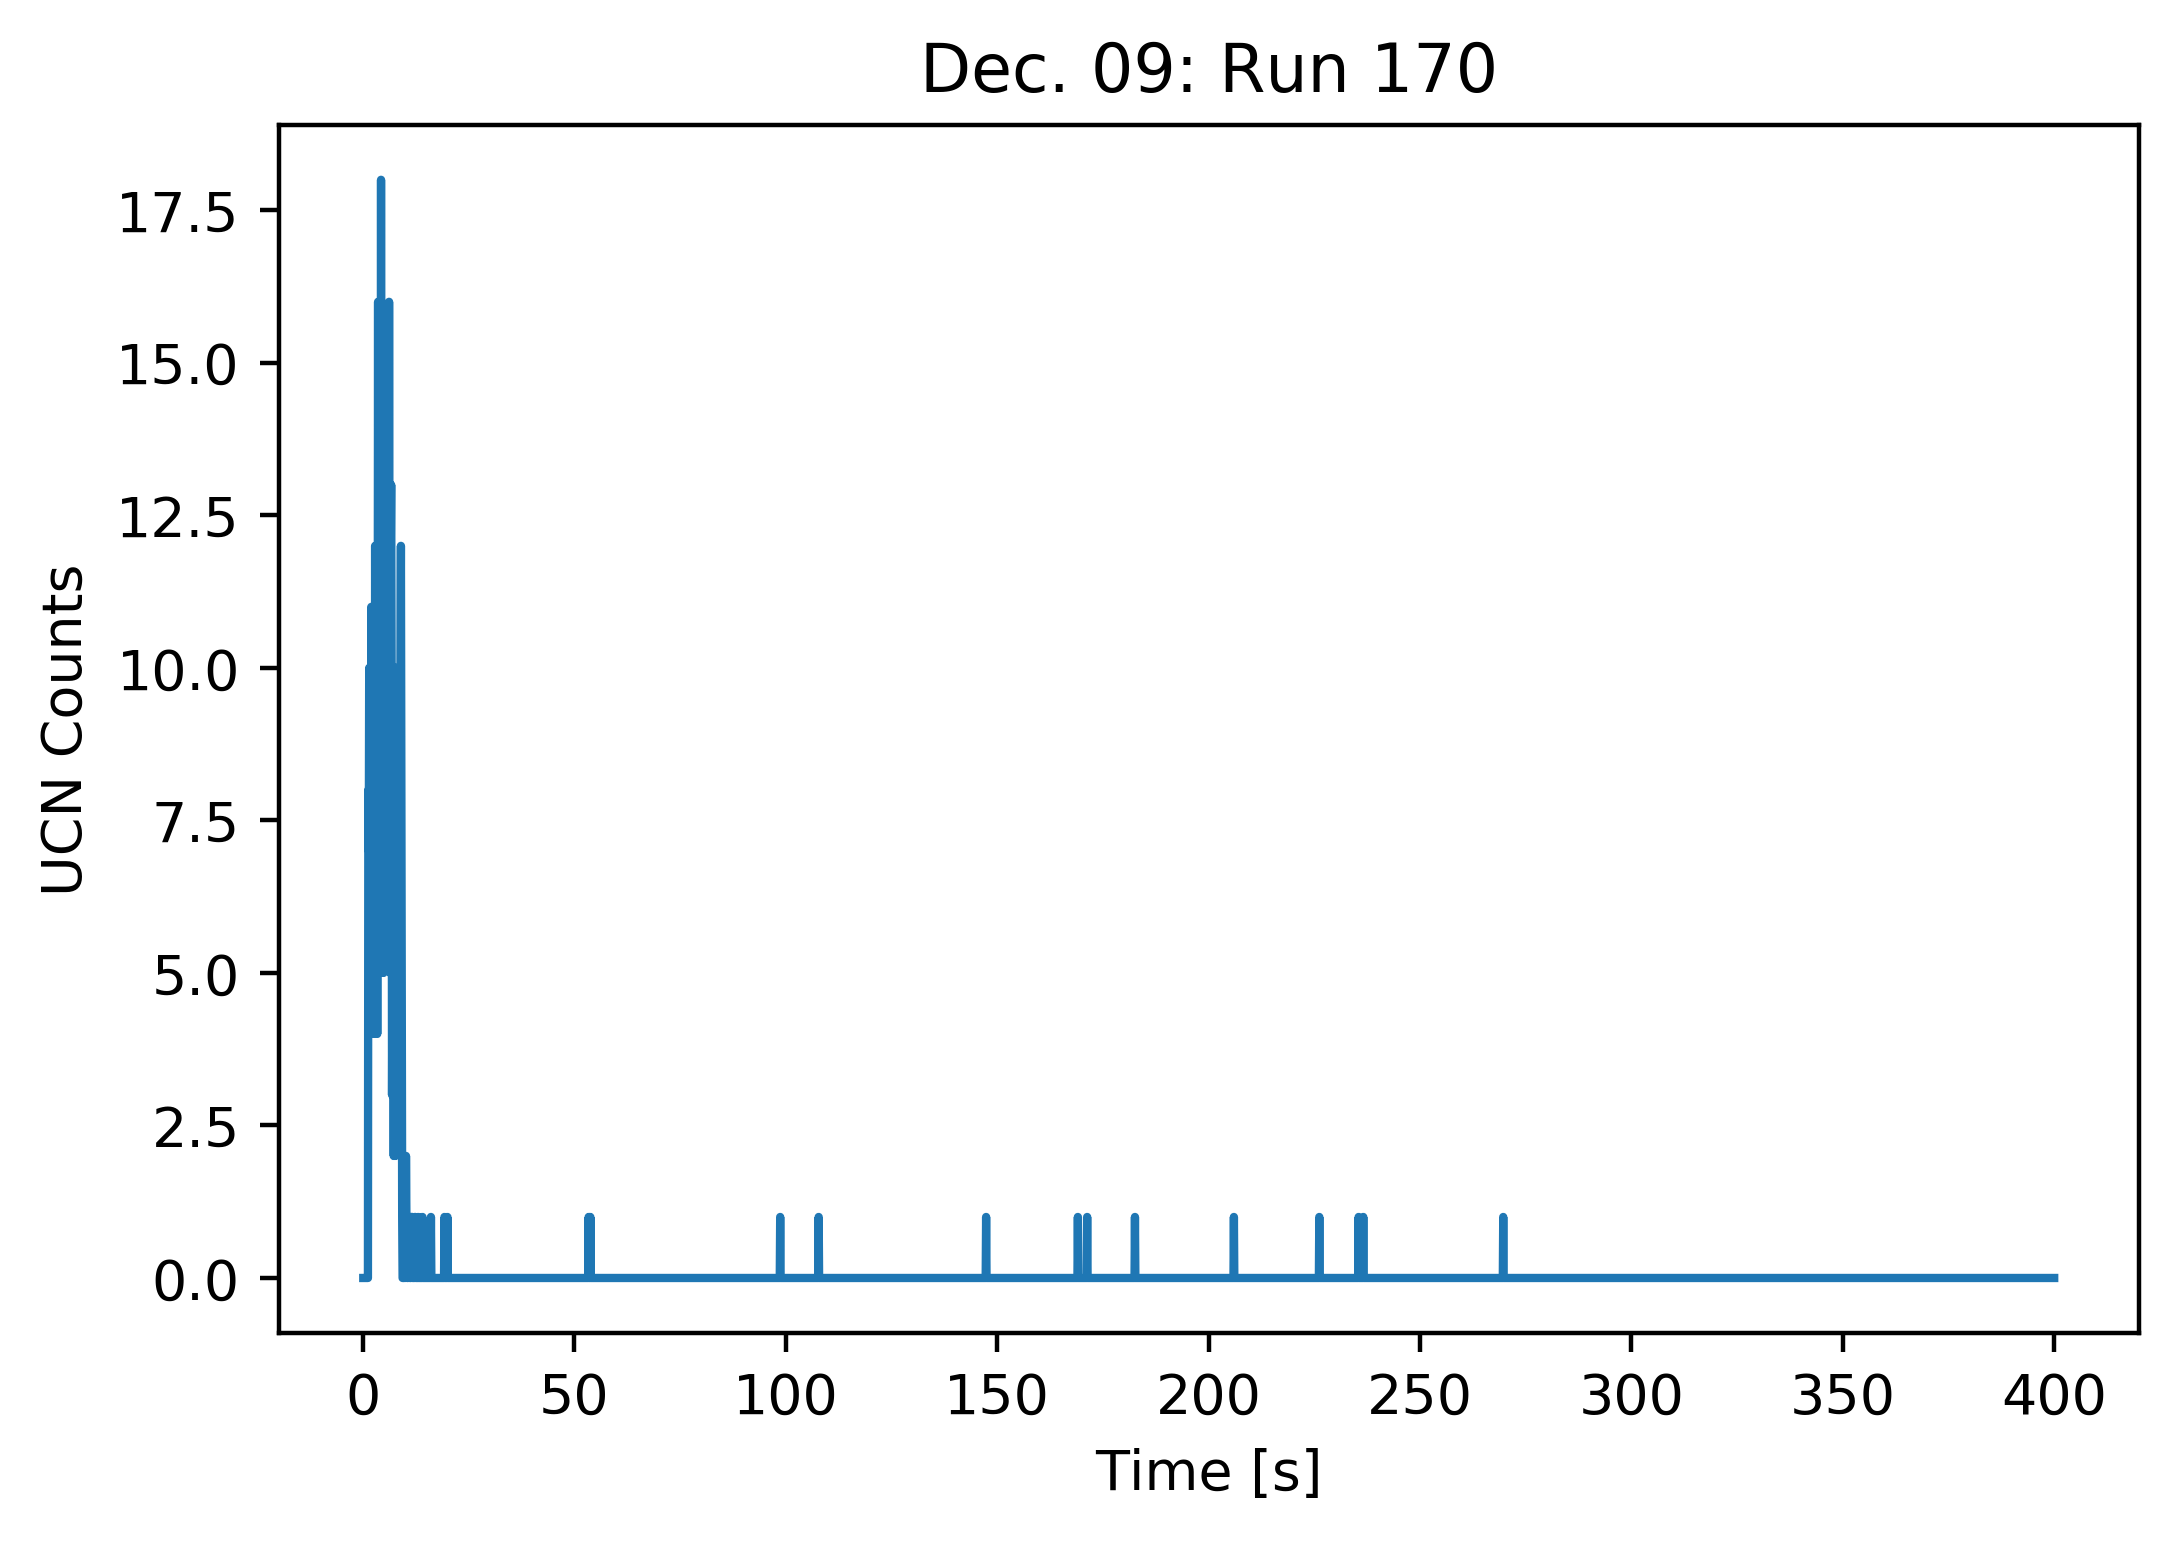

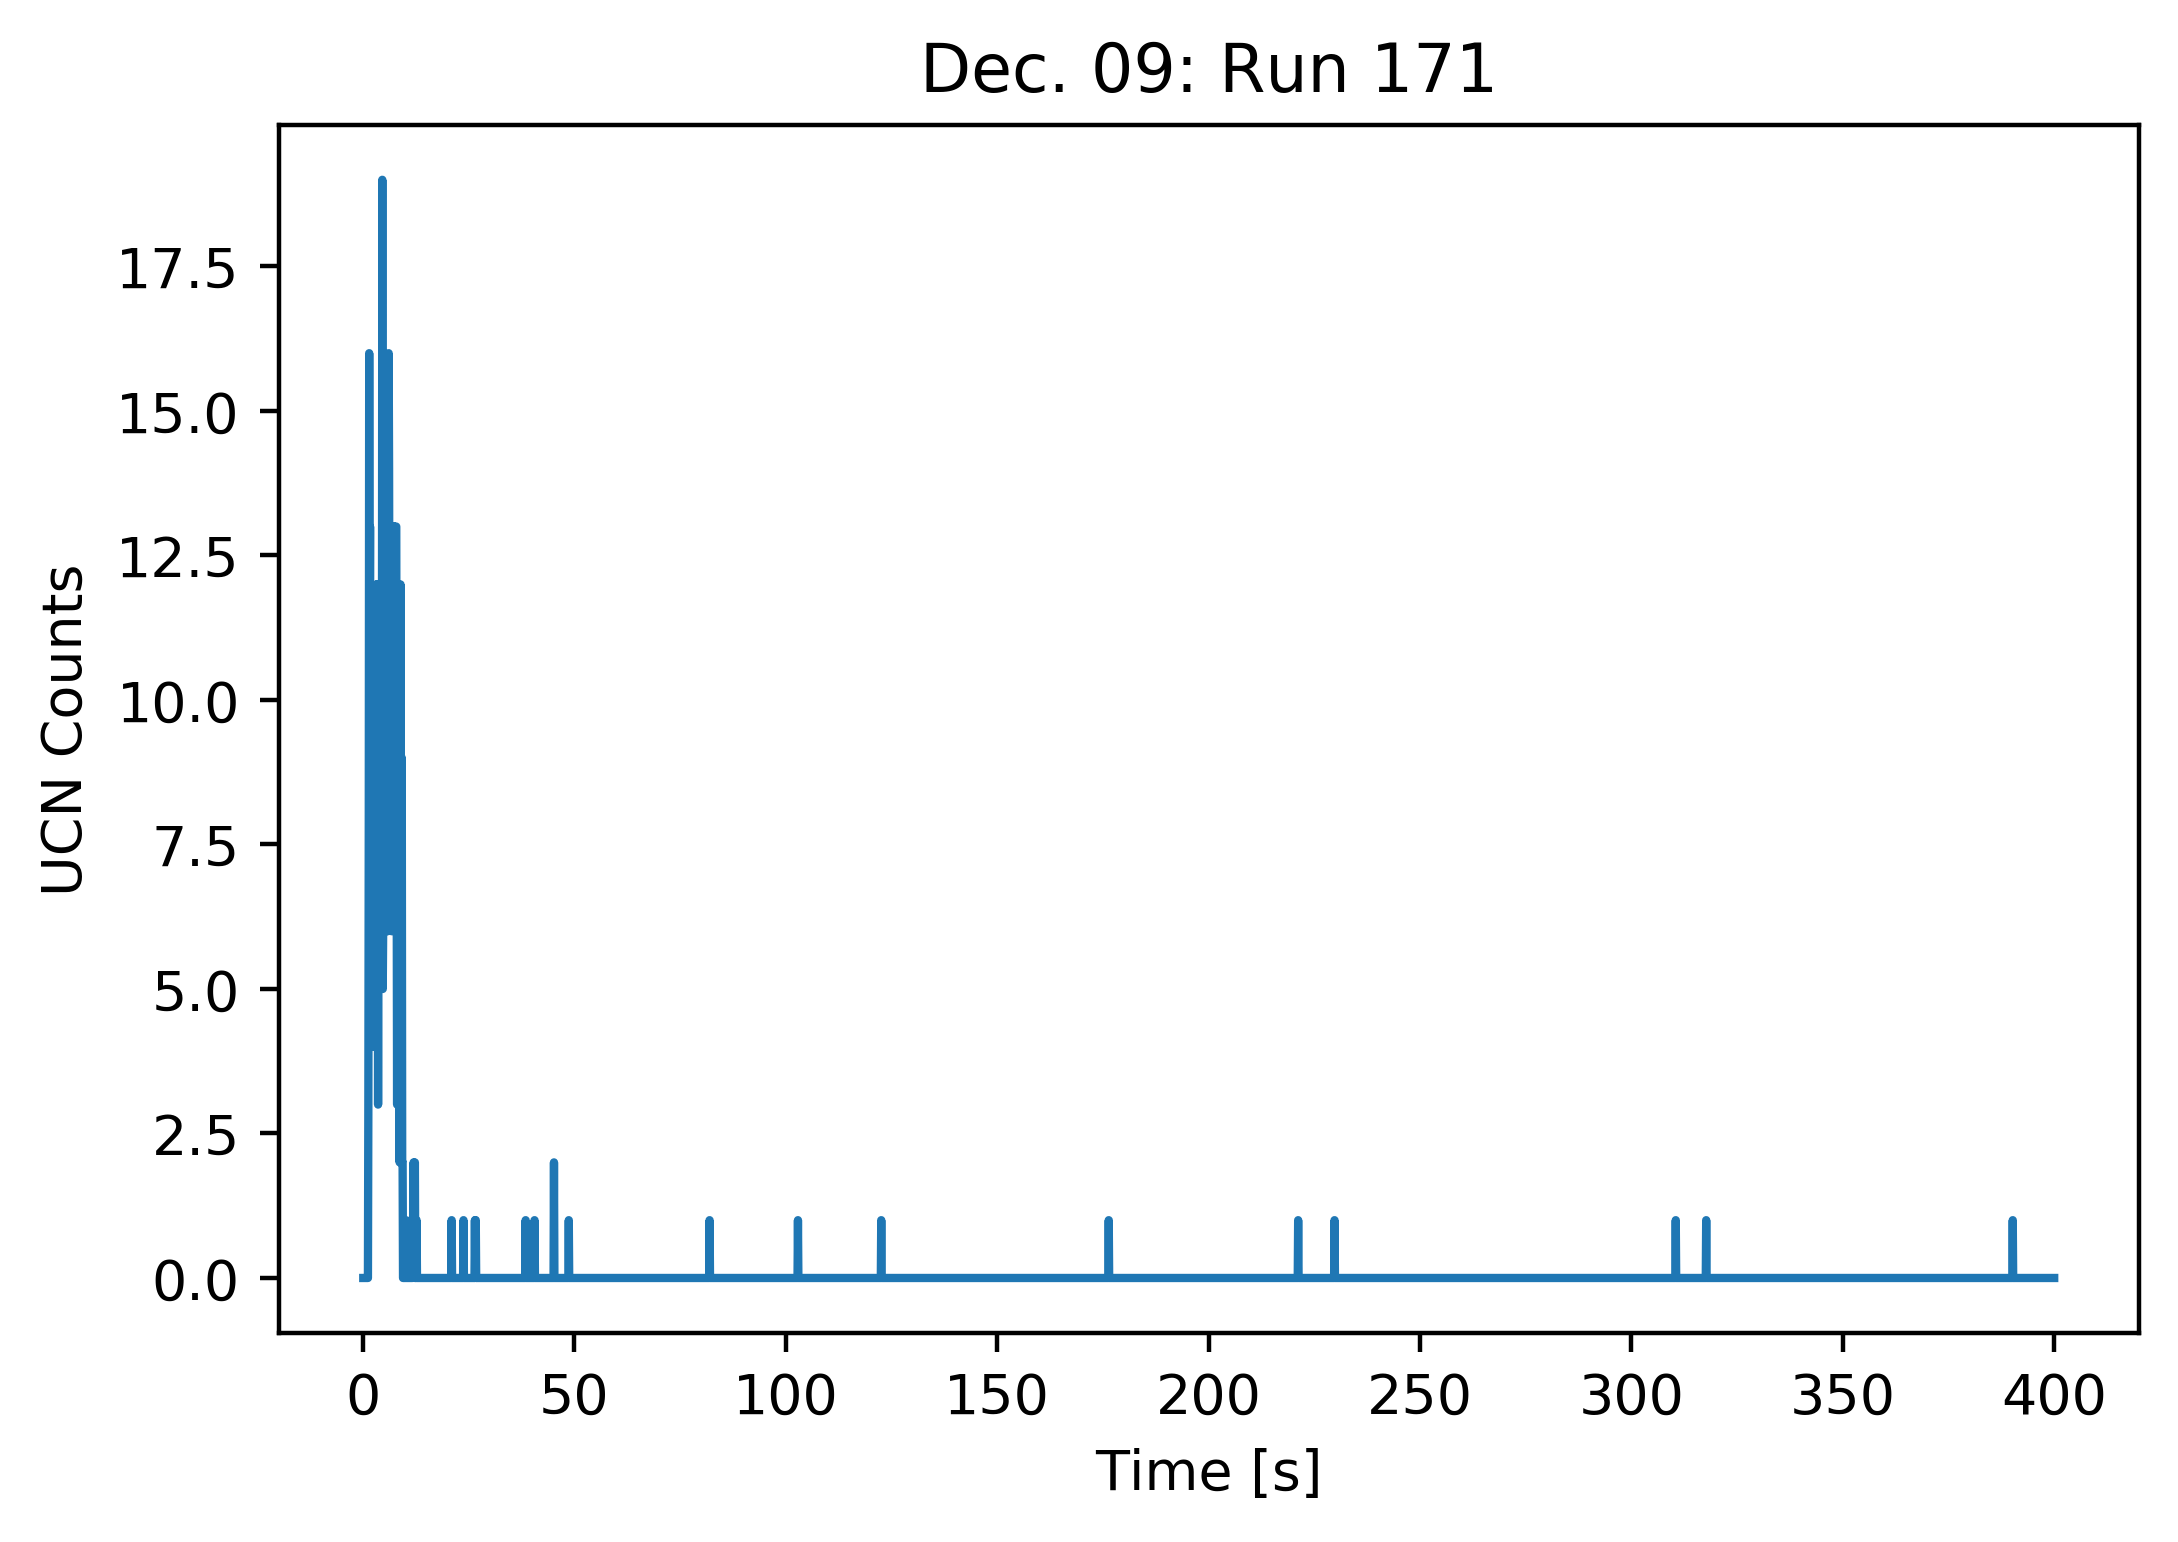

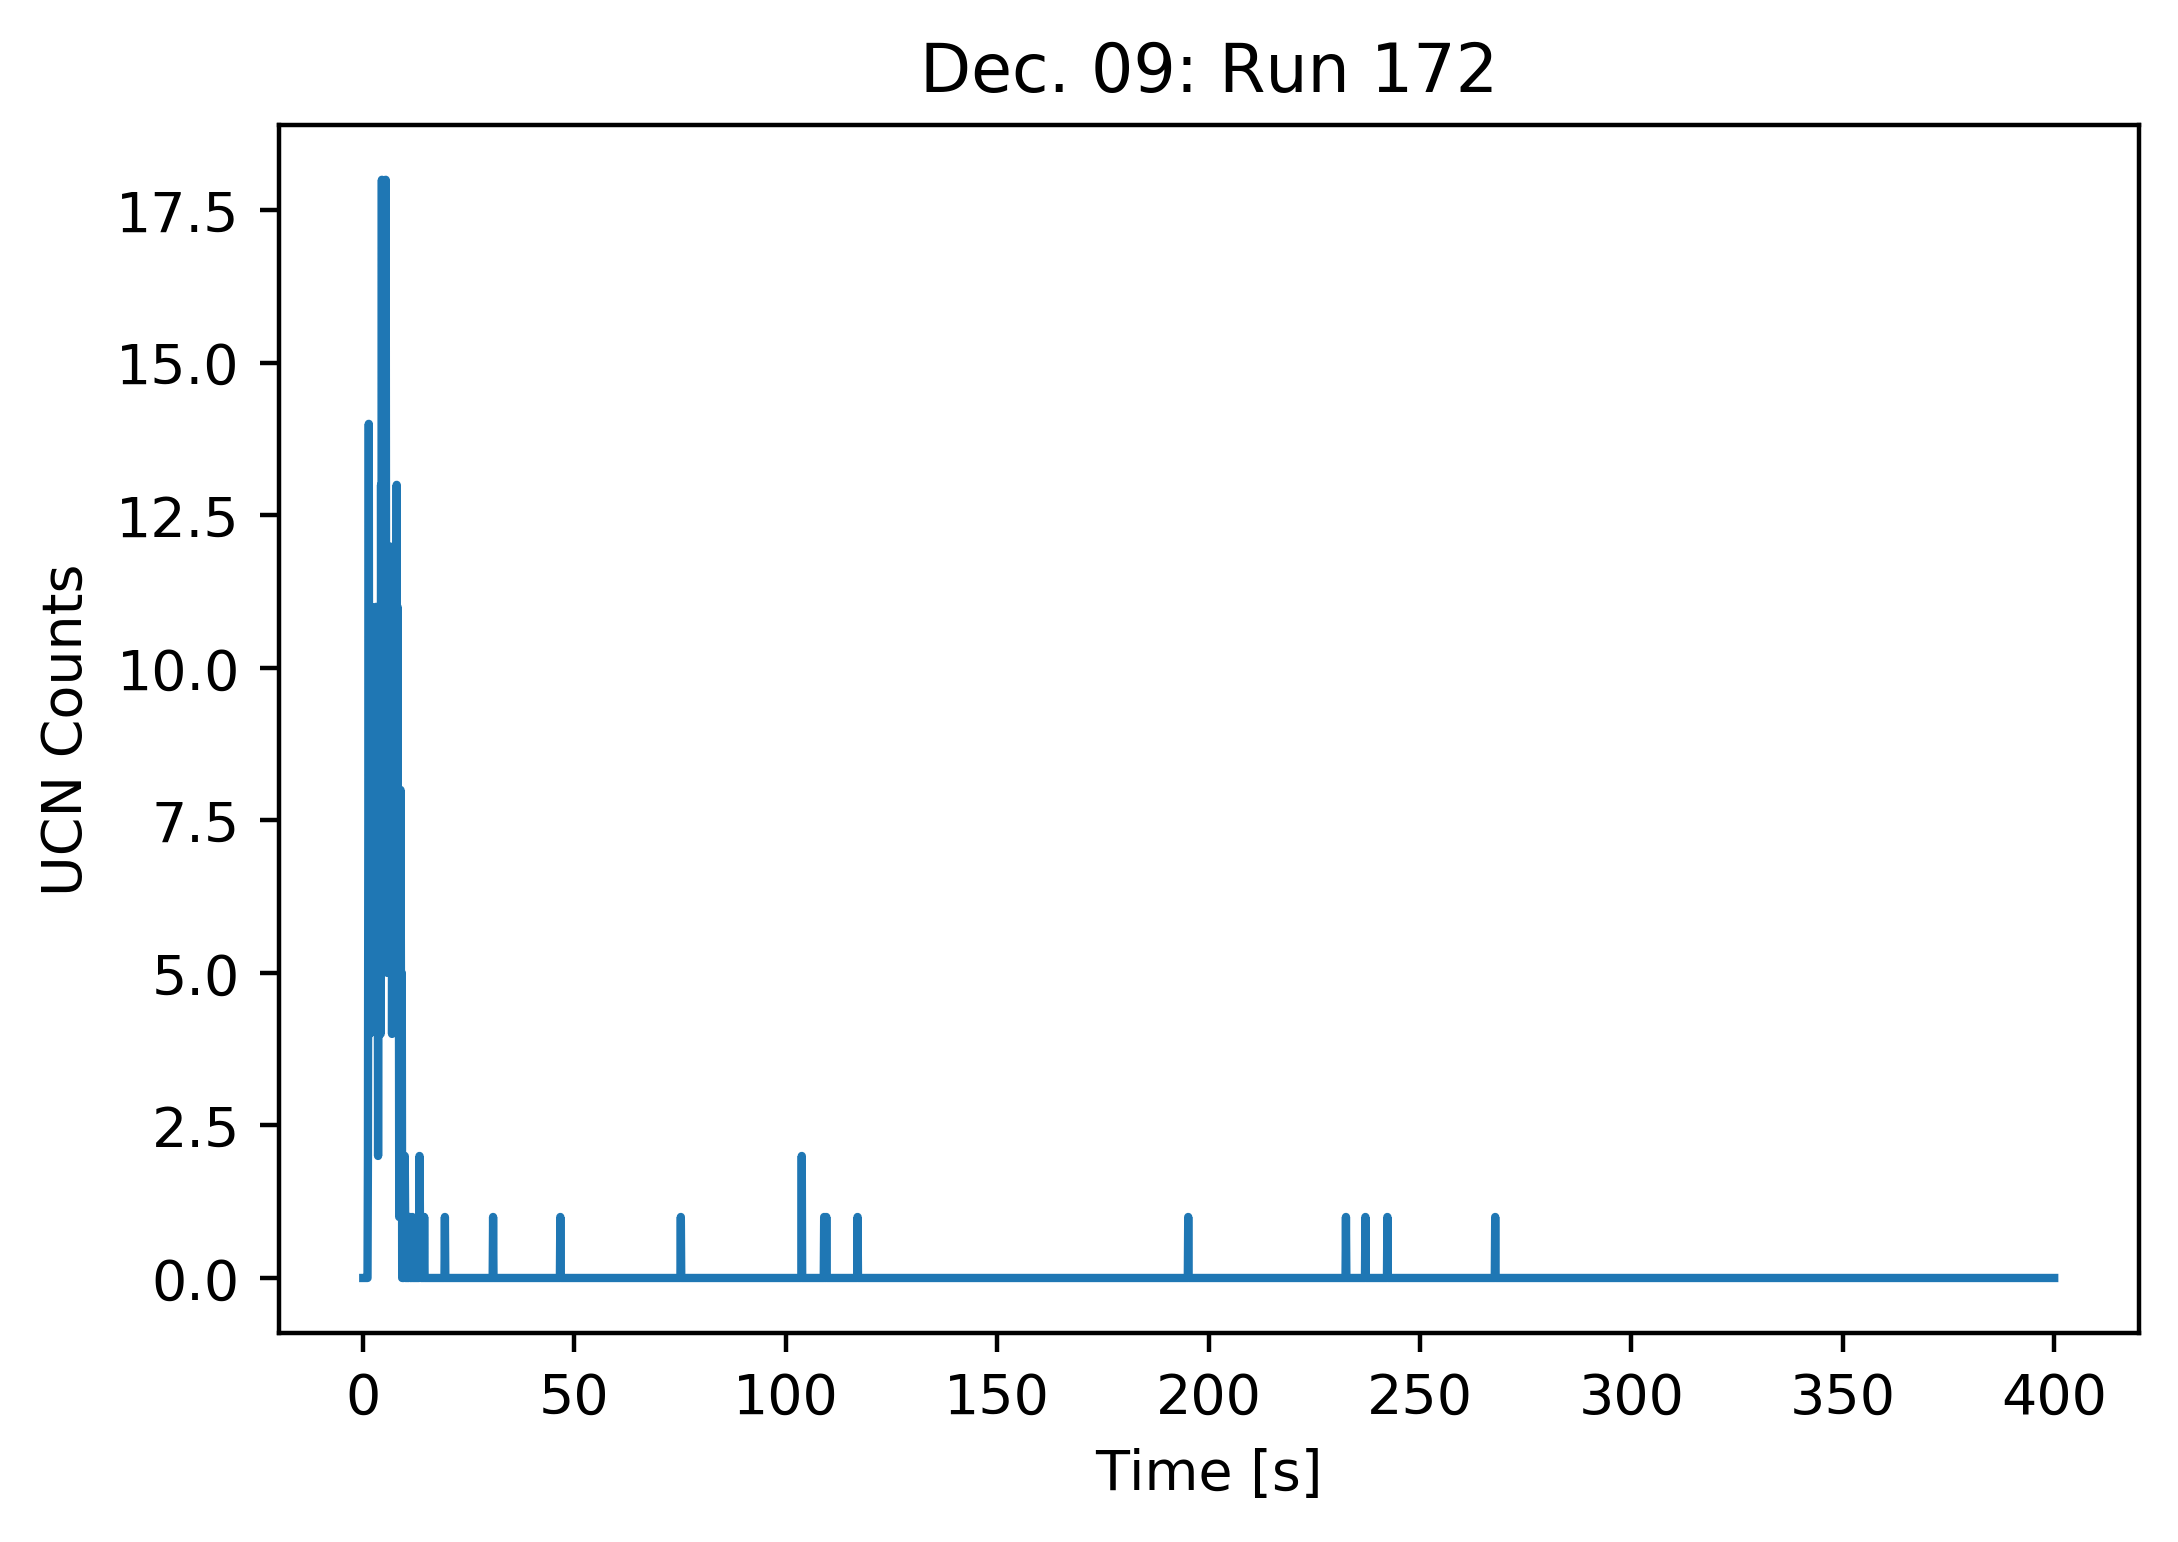

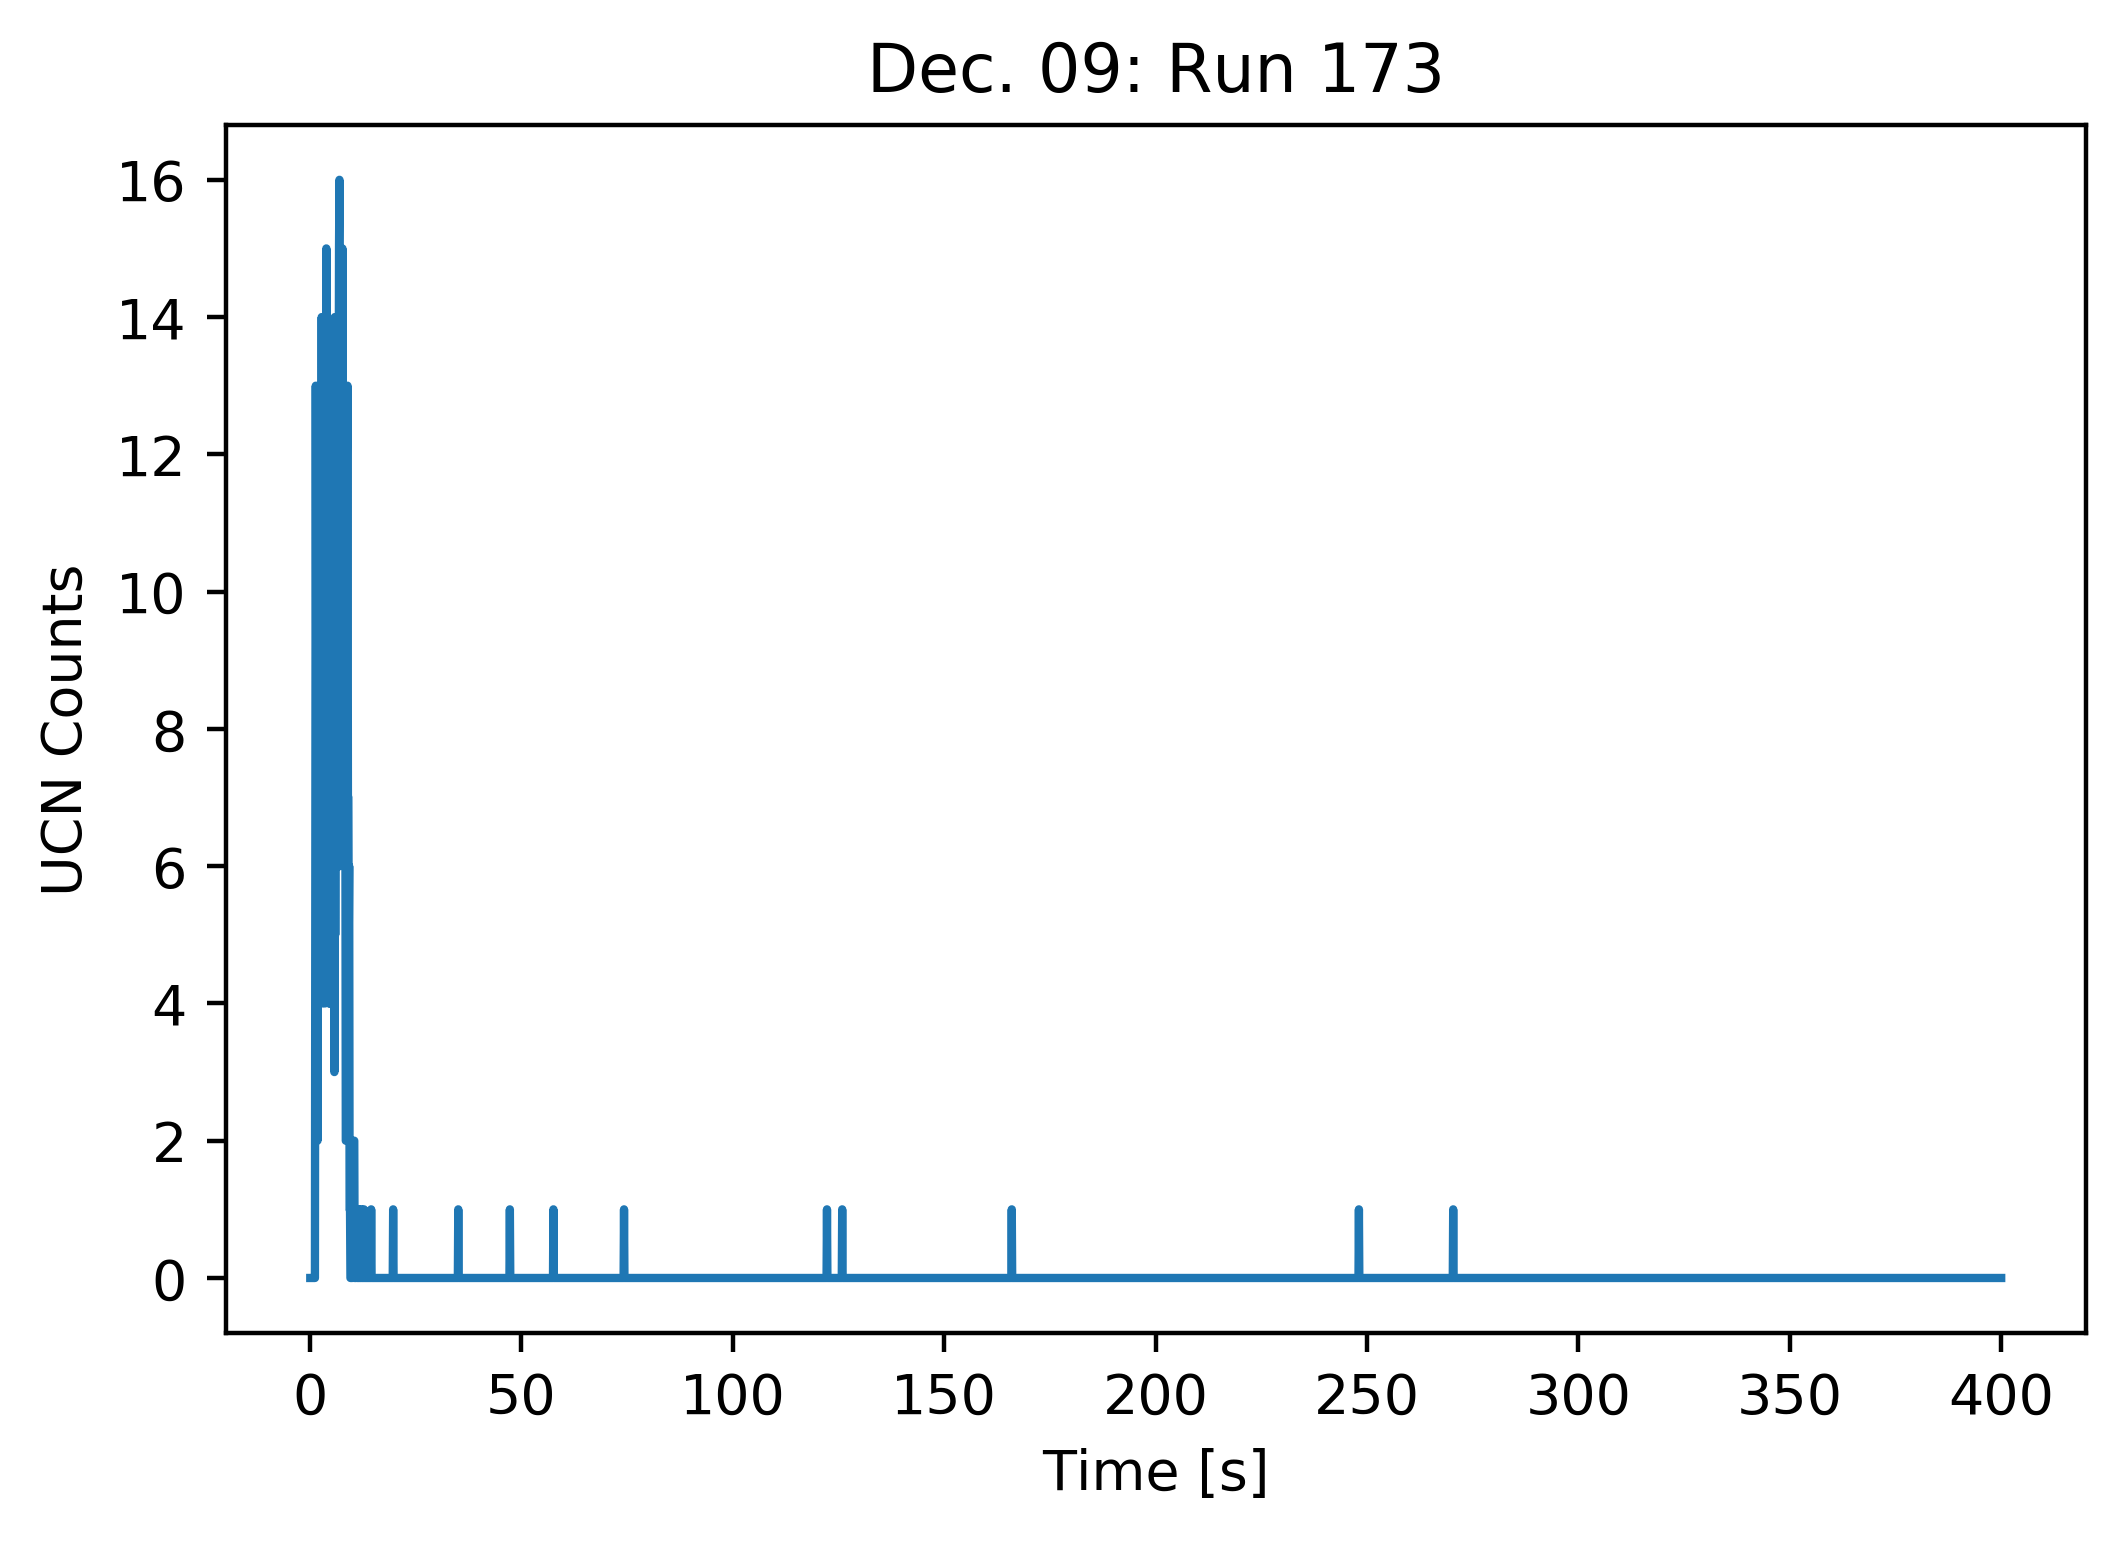

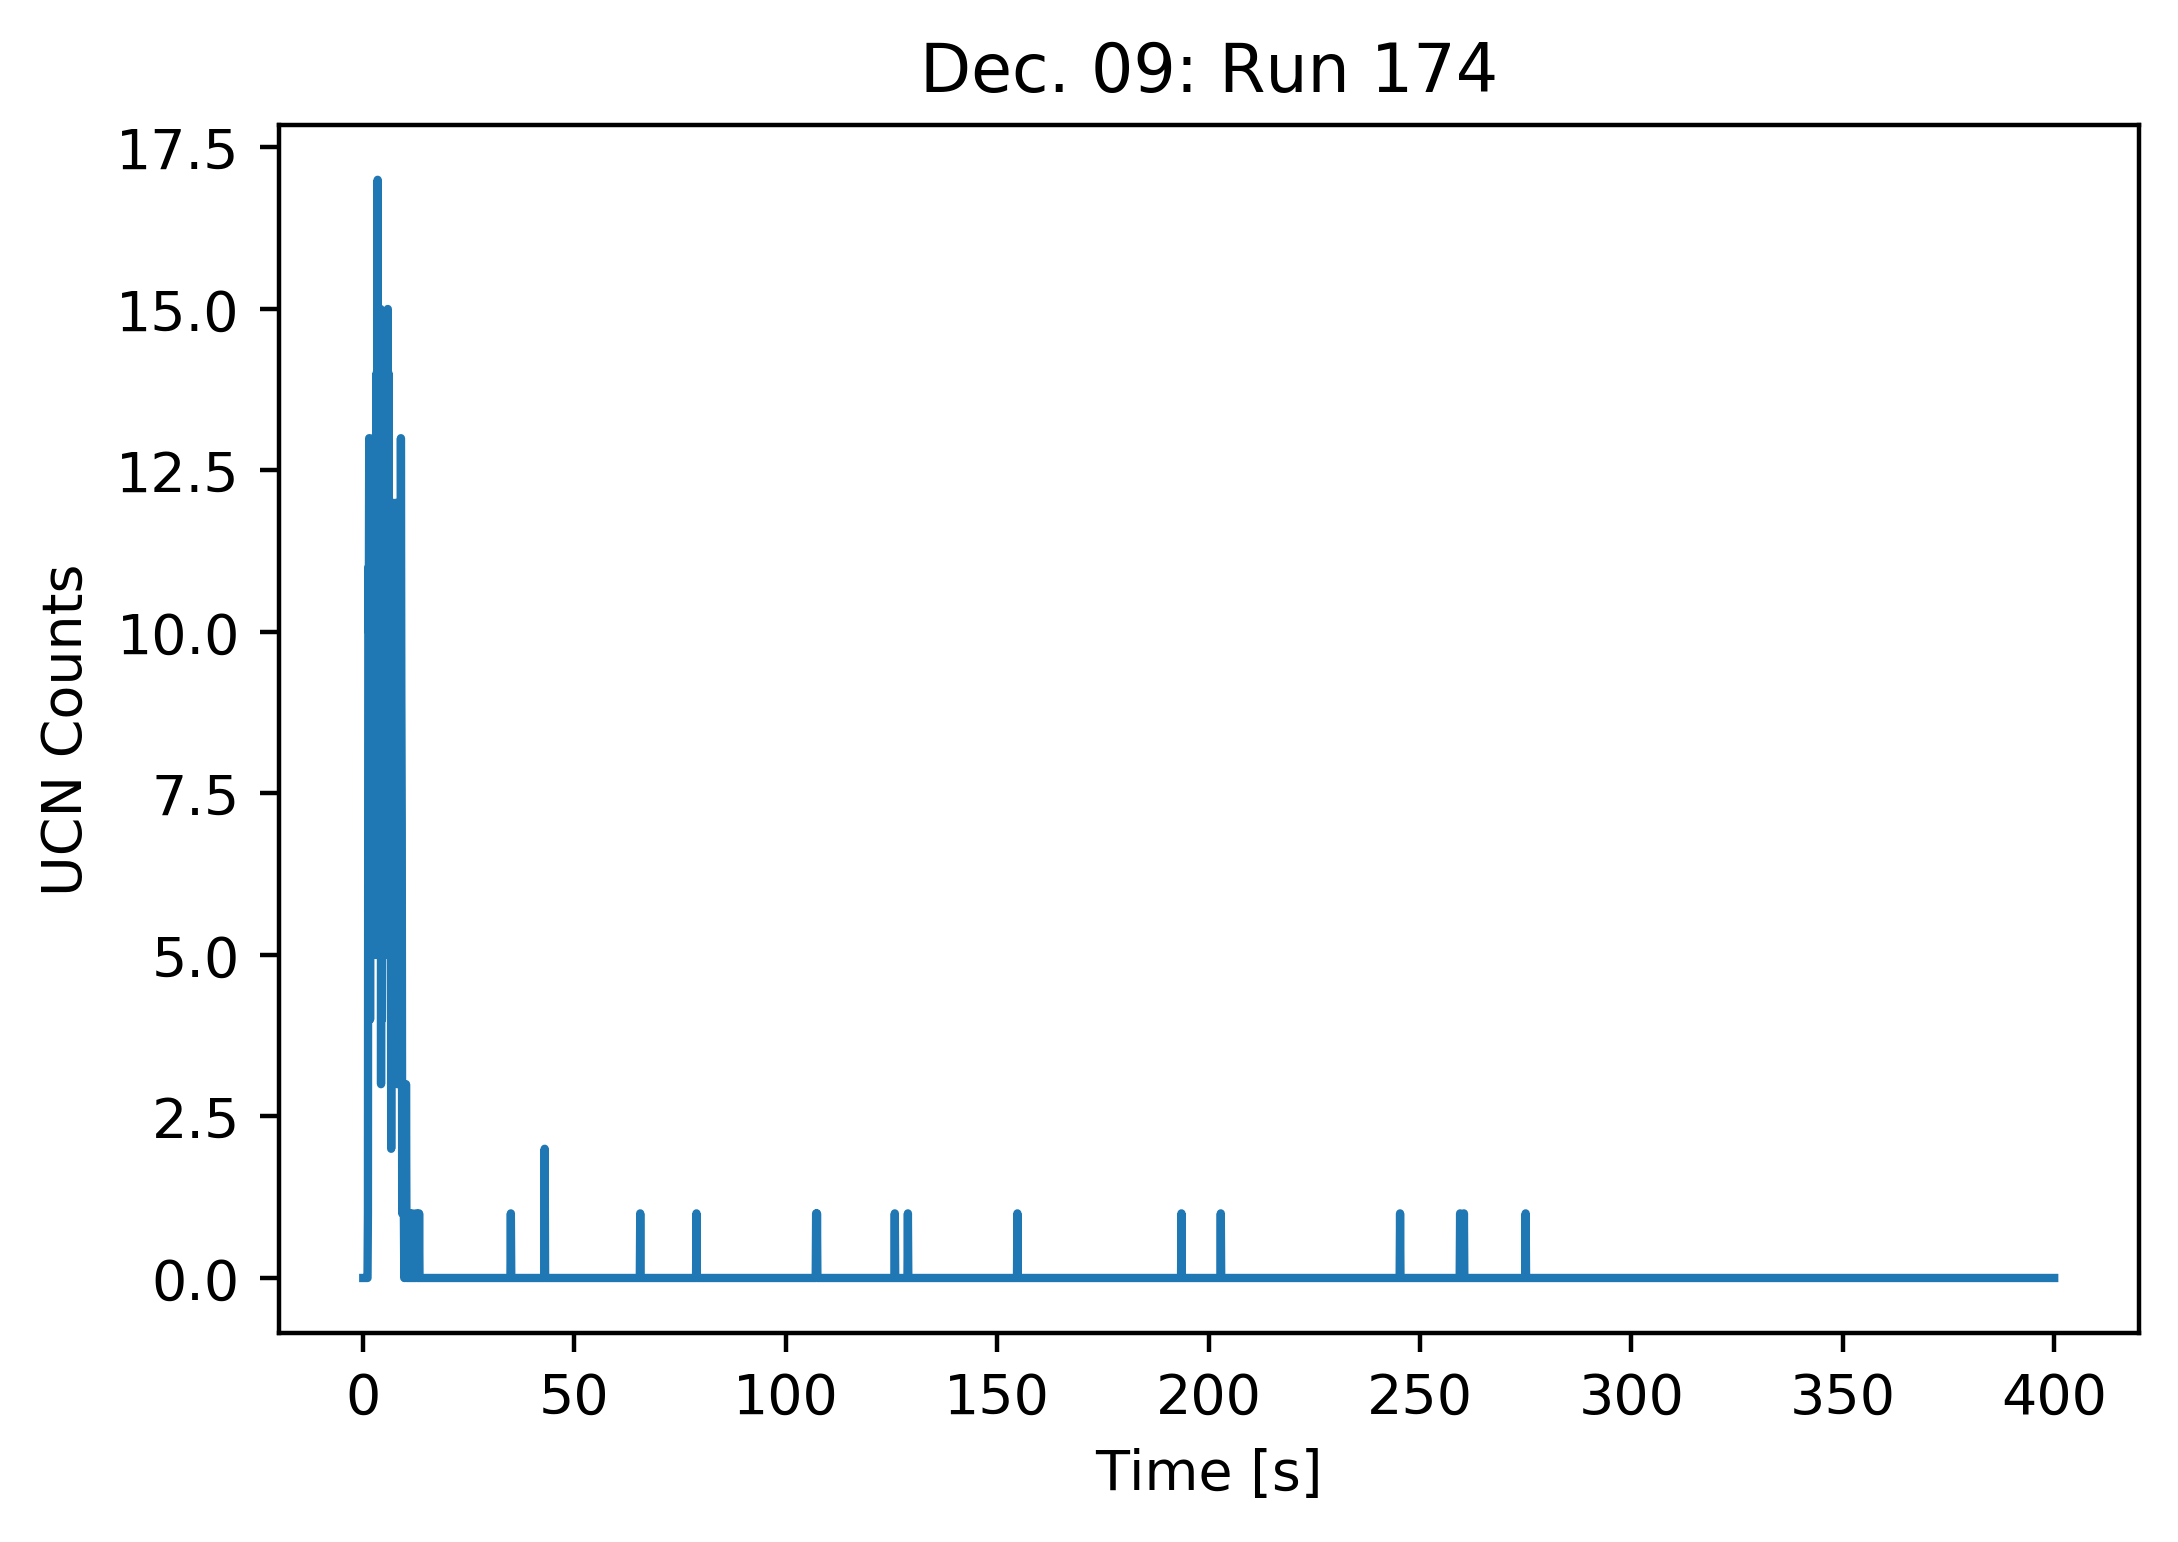

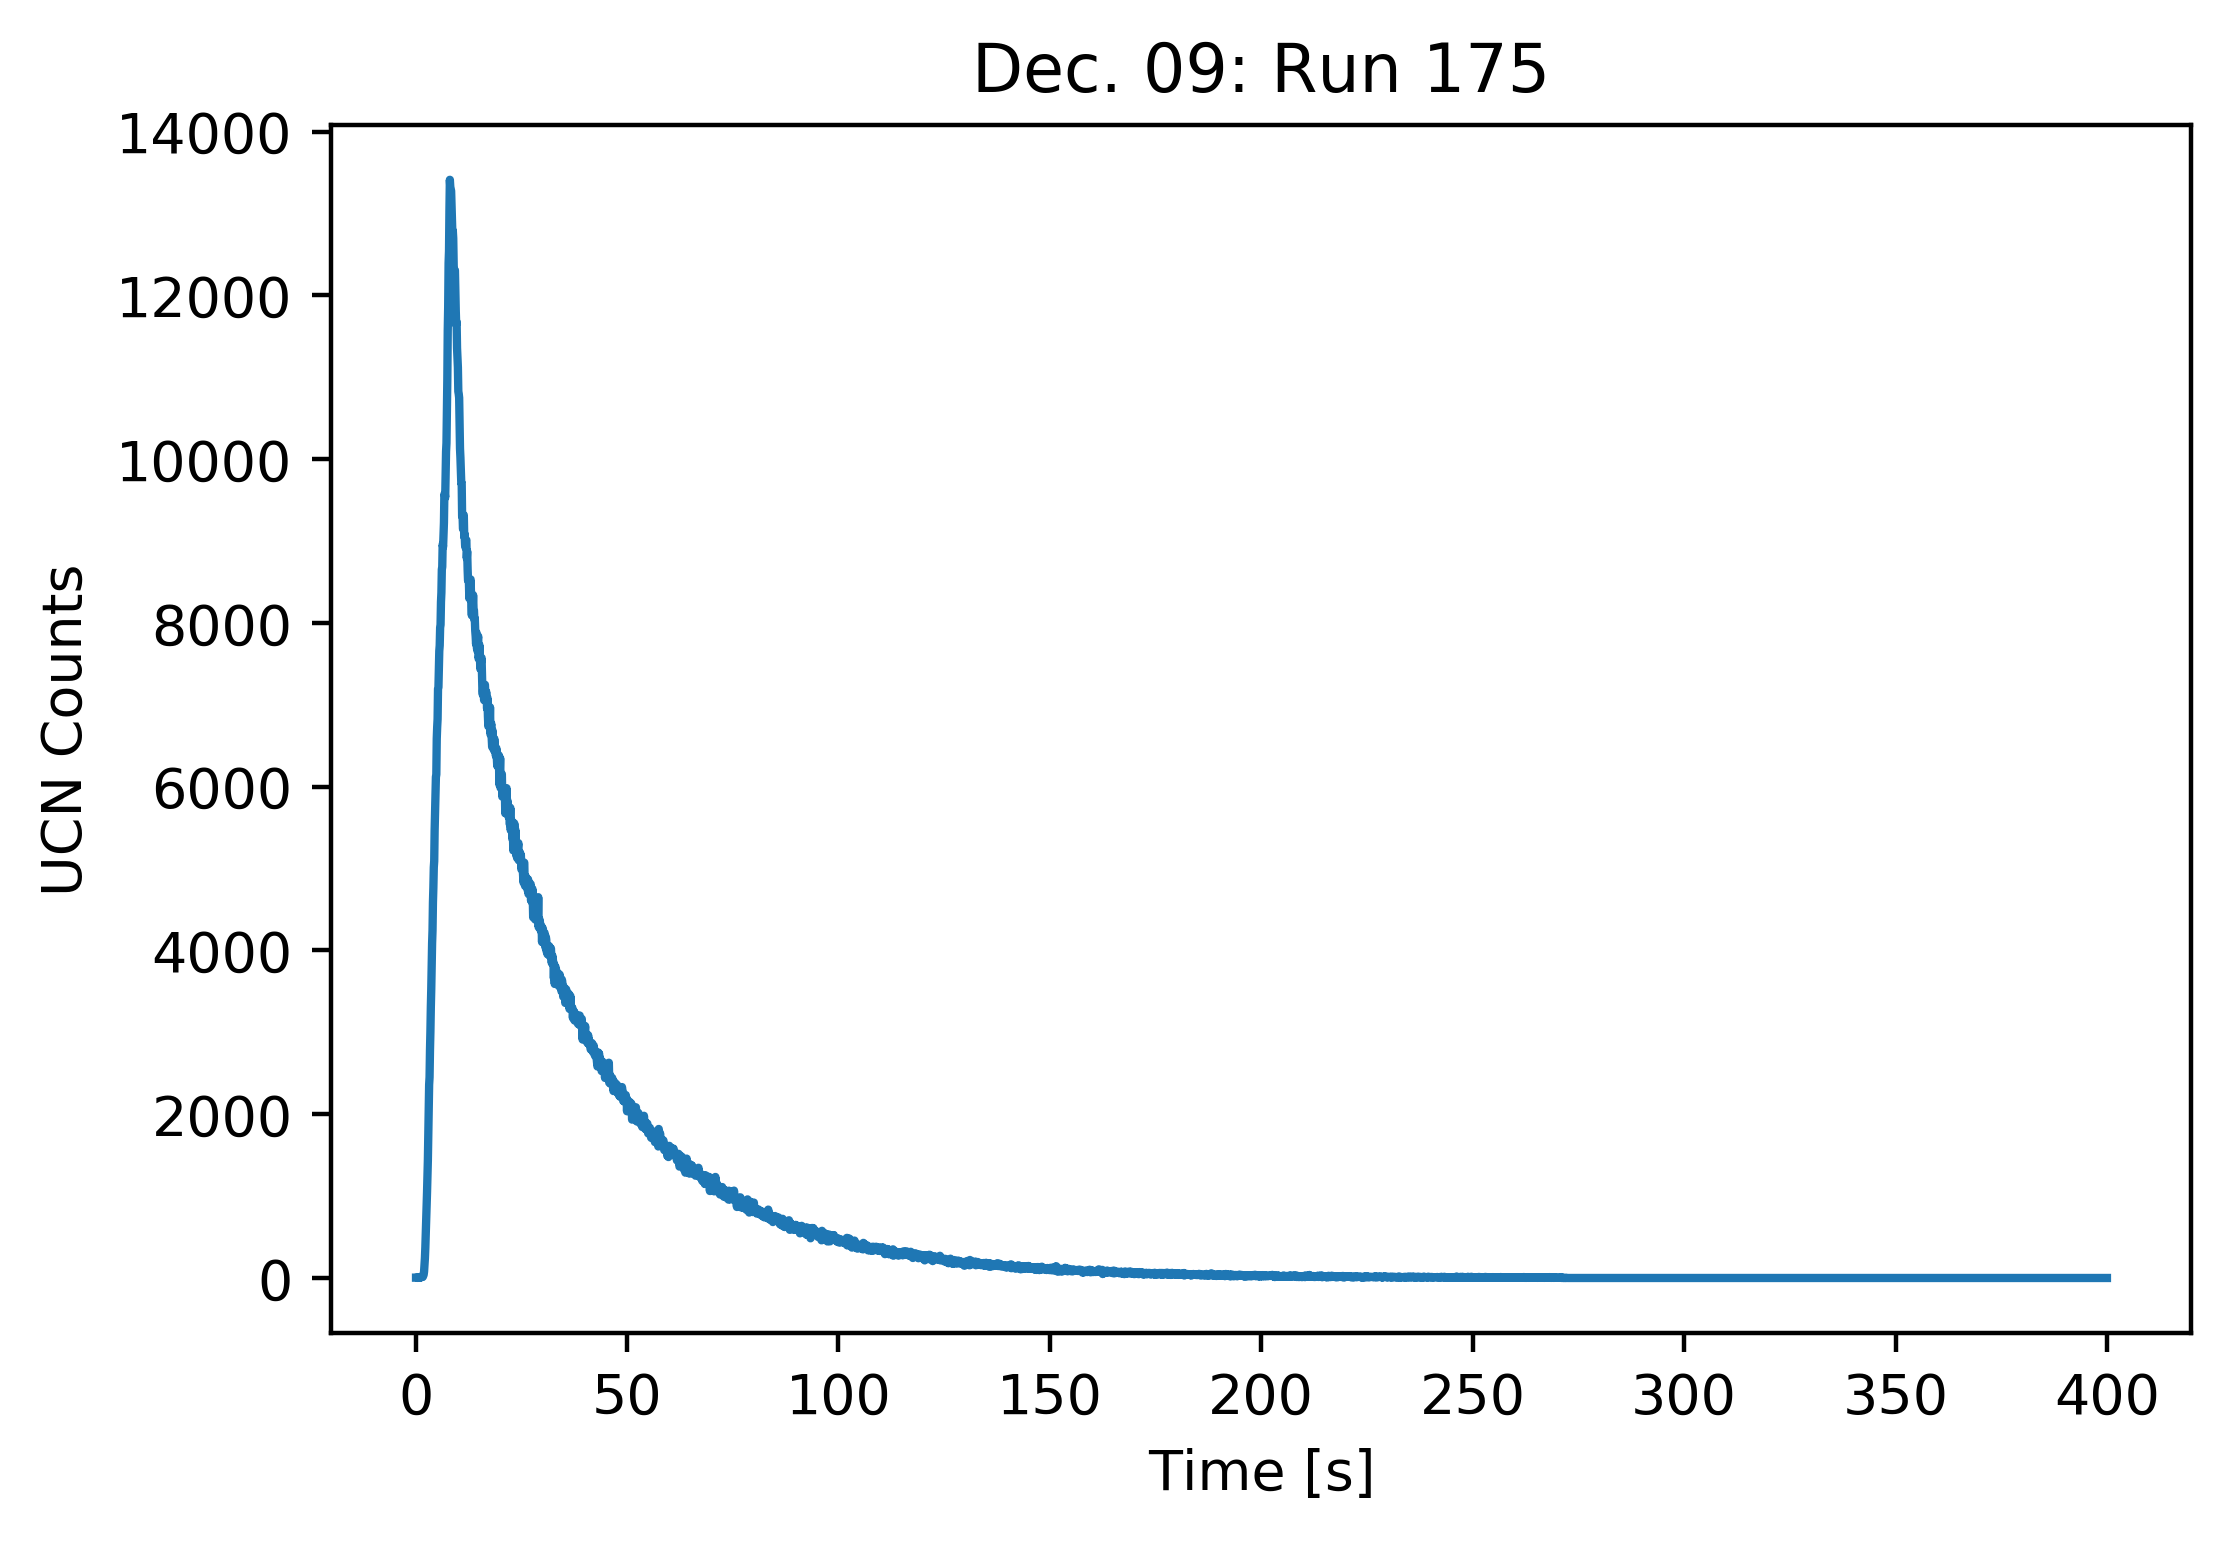

In [22]:
for i in range(158, 176): 

    data = np.loadtxt("../data_main/12/9/T091217_" + str(i).zfill(4) + ".tof", usecols = (0,1));
    plt.plot(data[:,0] * 0.1, data[:,1]);
    plt.xlabel('Time [s]');
    plt.ylabel('UCN Counts');
    plt.title('Dec. 09: Run ' + str(i))
    plt.show()

The beam is gone for run 160, comes back for 175. Something definitely changes between 169 and 170 though, perhaps some valve business from the experimenters?

Run 160 has timing information:

>Start Time   : 20:23:00<br/>
Nominal Time : 23:50:50<br/>
Real Time    : 00:05:01<br/>
Stop Time    : 20:28:01<br/>

Proton beam current measurements:

>.<br/>
.<br/>
.<br/>
2017-12-09 20:08:24 --- 0<br/>
2017-12-09 20:08:26 --- 0<br/>
2017-12-09 20:08:28 --- 0<br/>
2017-12-09 20:08:30 --- 1377.4<br/>
2017-12-09 20:08:32 --- 1382<br/>
2017-12-09 20:08:34 --- 1386.9<br/>
2017-12-09 20:08:36 --- 1100.3<br/>
2017-12-09 20:08:38 --- 0<br/>
2017-12-09 20:08:40 --- 0<br/>
2017-12-09 20:08:42 --- 0<br/>
.<br/>
.<br/>
.<br/>
2017-12-09 20:28:22 --- 0<br/>
2017-12-09 20:28:24 --- 0<br/>
2017-12-09 20:28:26 --- 0<br/>
2017-12-09 20:28:28 --- 1361.9<br/>
2017-12-09 20:28:30 --- 1369.1<br/>
2017-12-09 20:28:32 --- 1377.6<br/>
2017-12-09 20:28:34 --- 1336.6<br/>
2017-12-09 20:28:36 --- 0<br/>
2017-12-09 20:28:38 --- 0<br/>
2017-12-09 20:28:40 --- 0<br/>
.<br/>
.<br/>
.

That's almost exactly a 20 minute outtage. Run 159's timing info:

>Start Time   : 20:17:59<br/>
Nominal Time : 23:50:50<br/>
Real Time    : 00:05:00<br/>
Stop Time    : 20:22:59<br/>

Run 170's timing info:

>Start Time   : 21:28:06<br/>
Nominal Time : 23:50:50<br/>
Real Time    : 00:05:00<br/>
Stop Time    : 21:33:06<br/>

Run 175's timing info:

>Start Time   : 21:58:09<br/>
Nominal Time : 23:50:50<br/>
Real Time    : 00:05:00<br/>
Stop Time    : 22:03:10<br/>

Of course these aren't matching because the experimenters would have waited to see the beam was back up before actually opening up to perform a full run. These timings wouldn't have been exact. This approach won't work. 


## Looking at 100s data, and ~26 second adjusted proton beam data.

I want to look at this region specifically, where the same configuration, and pre-storage time, were held and run overnight for many runs. Maybe the fluctuation in the proton beam current can be seen to correlate strongly enough with this data such that the timing issue can be resolved.

![](../misc/100_s_region.png)
![](jonahberean/psi_transmission/misc/100_s_region.png)

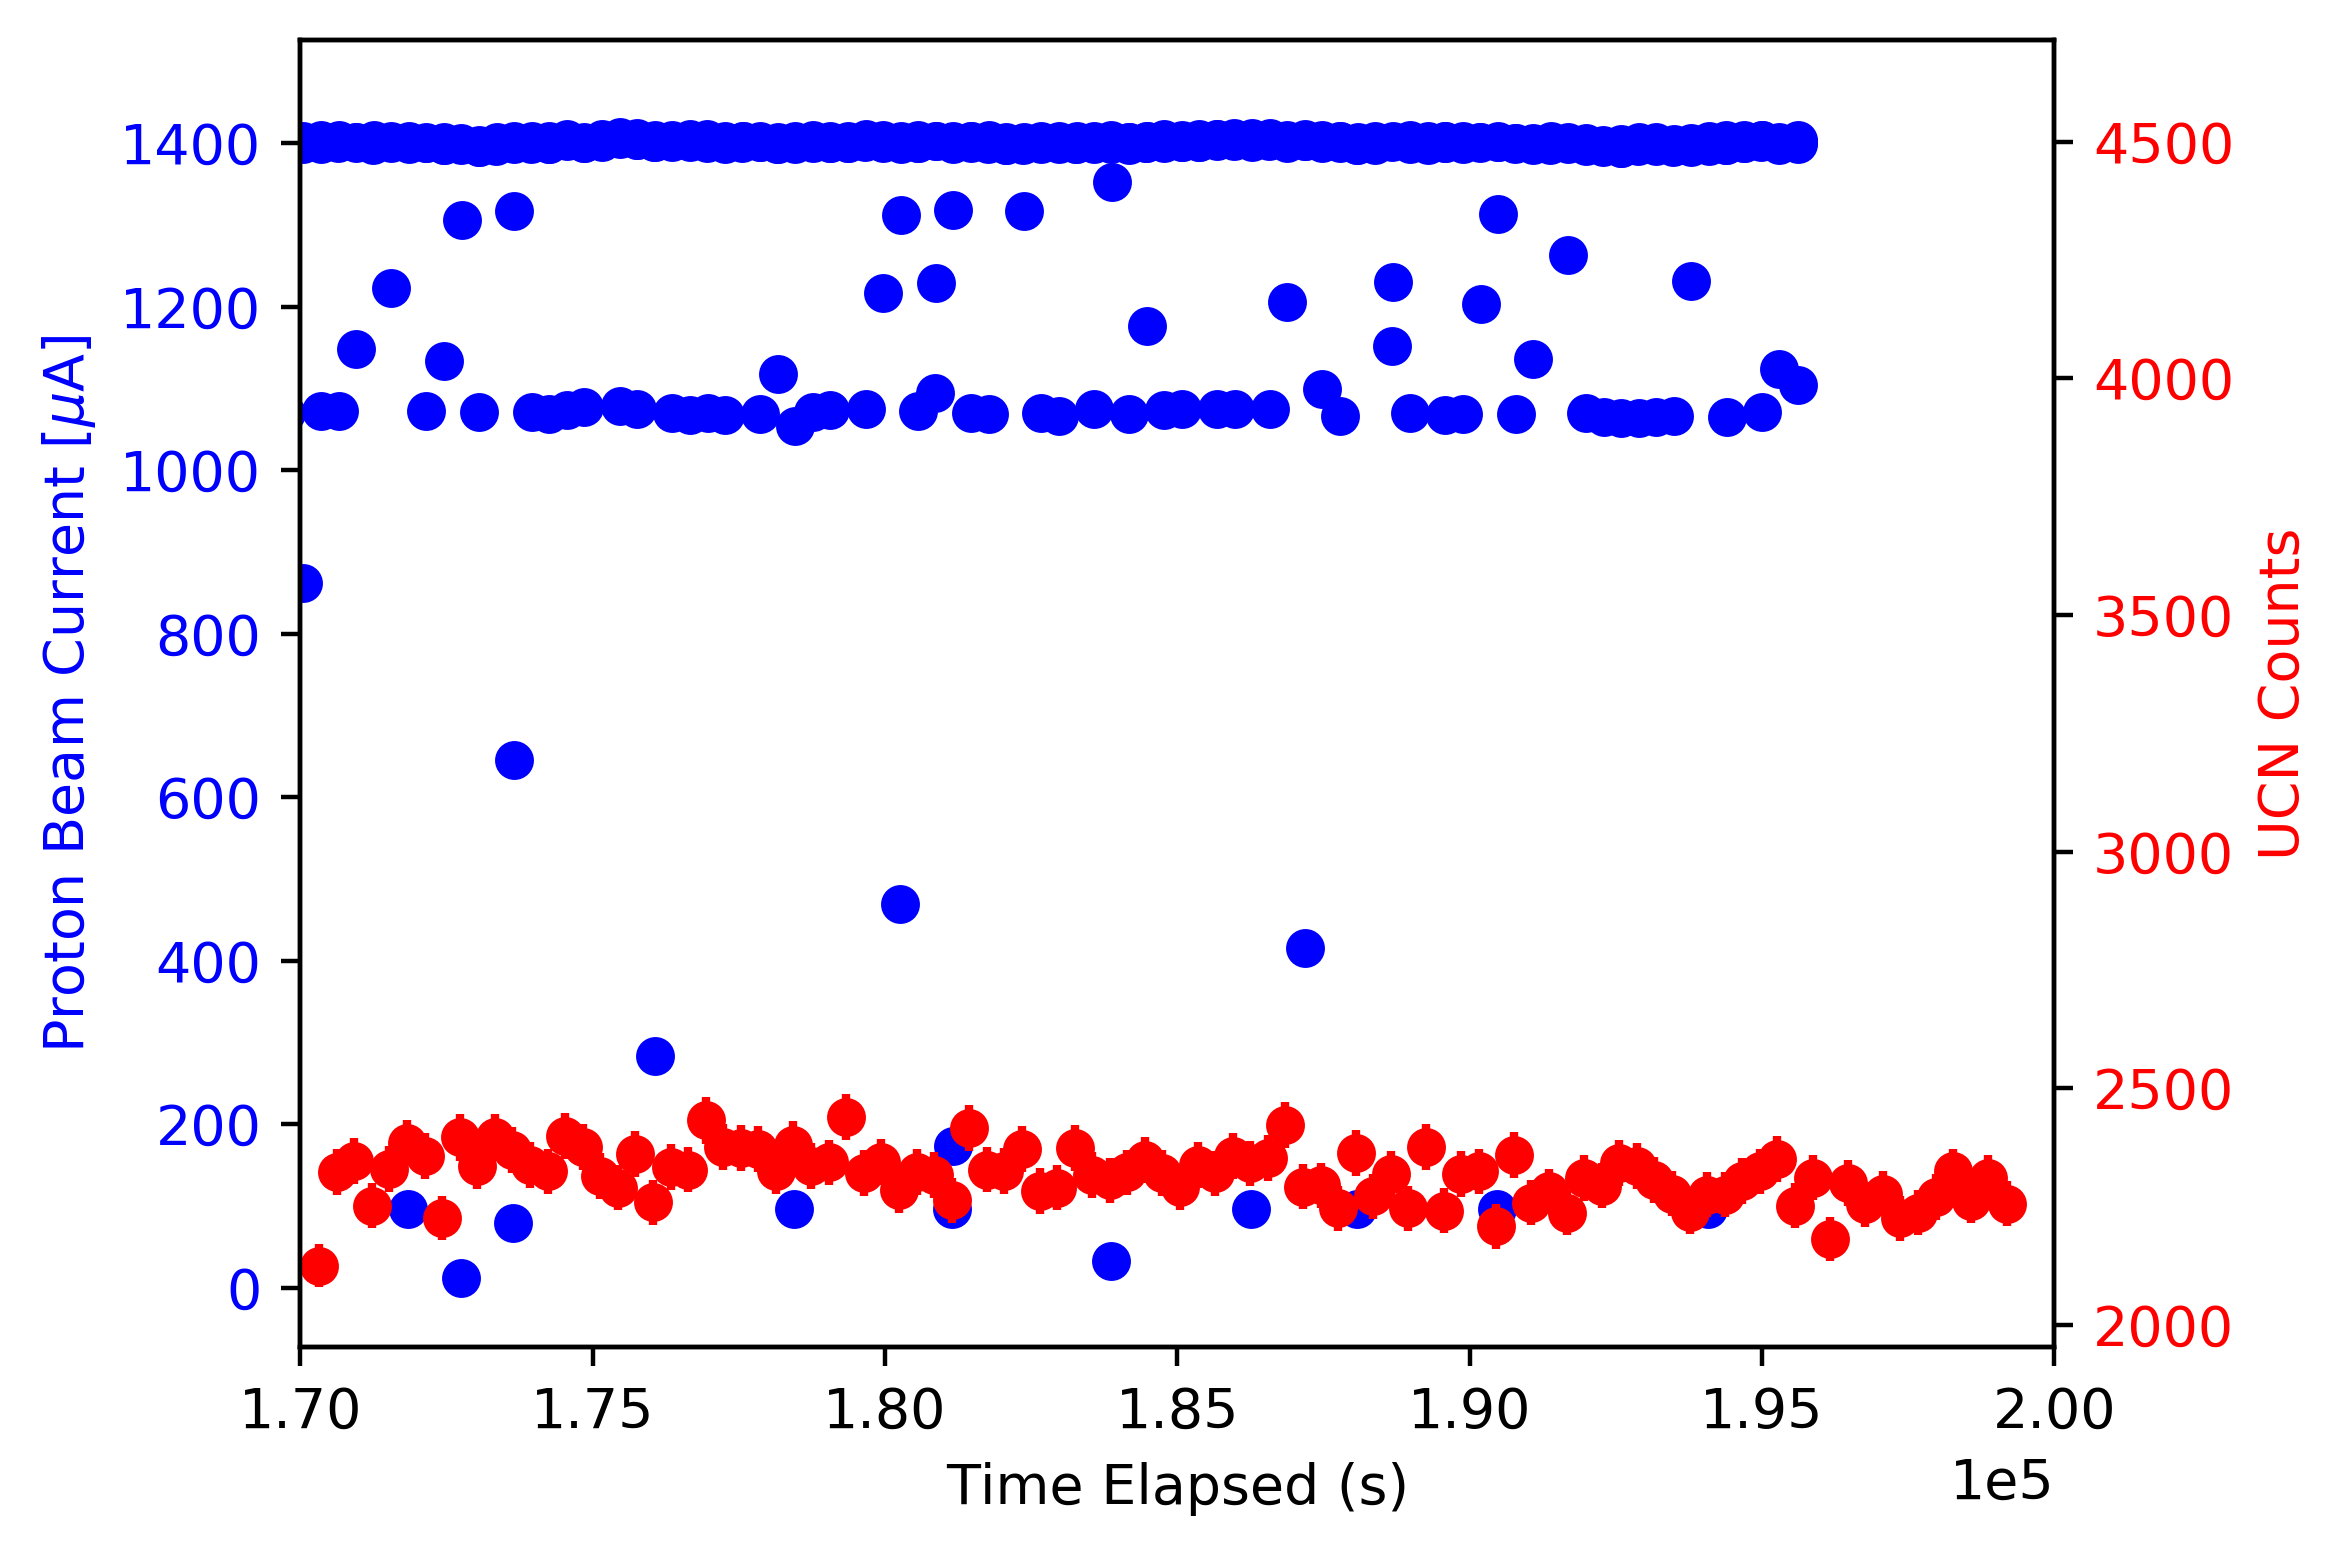

In [31]:
###############################################################################
# instantiate the subplots 
fig, ax1 = plt.subplots()

ax1.set_xlabel('Time Elapsed (s)')

# narrow the x range to where our main detector run data are
ax1.set_xlim([1.7e5,2.0e5])

ax1.set_ylabel(r'Proton Beam Current [$\mu$A]', color = 'b')

# plot all of bernhard's monitoring data
arr = p_beam_data_3
ax1.scatter(arr[:,0], arr[:,1], marker = 'o', color = 'b')
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax1.tick_params(axis='y', labelcolor='b')

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  

# plot every run of data, no normalization
arr = main_data_dict['all', 's100']

ax2.errorbar(arr[:,0], arr[:,2], yerr = arr[:,3], marker = 'o', fmt = '.', color = 'r')
ax2.tick_params(axis='y', labelcolor='r')

# we already handled the x-label with ax1
ax2.set_ylabel('UCN Counts', color = 'r')  

# otherwise the right y-label is slightly clipped
fig.tight_layout()  
###############################################################################

Here I've just rescaled and plotted that region of the data, looking at only the 100s runs.

first index: 24
last index: 120


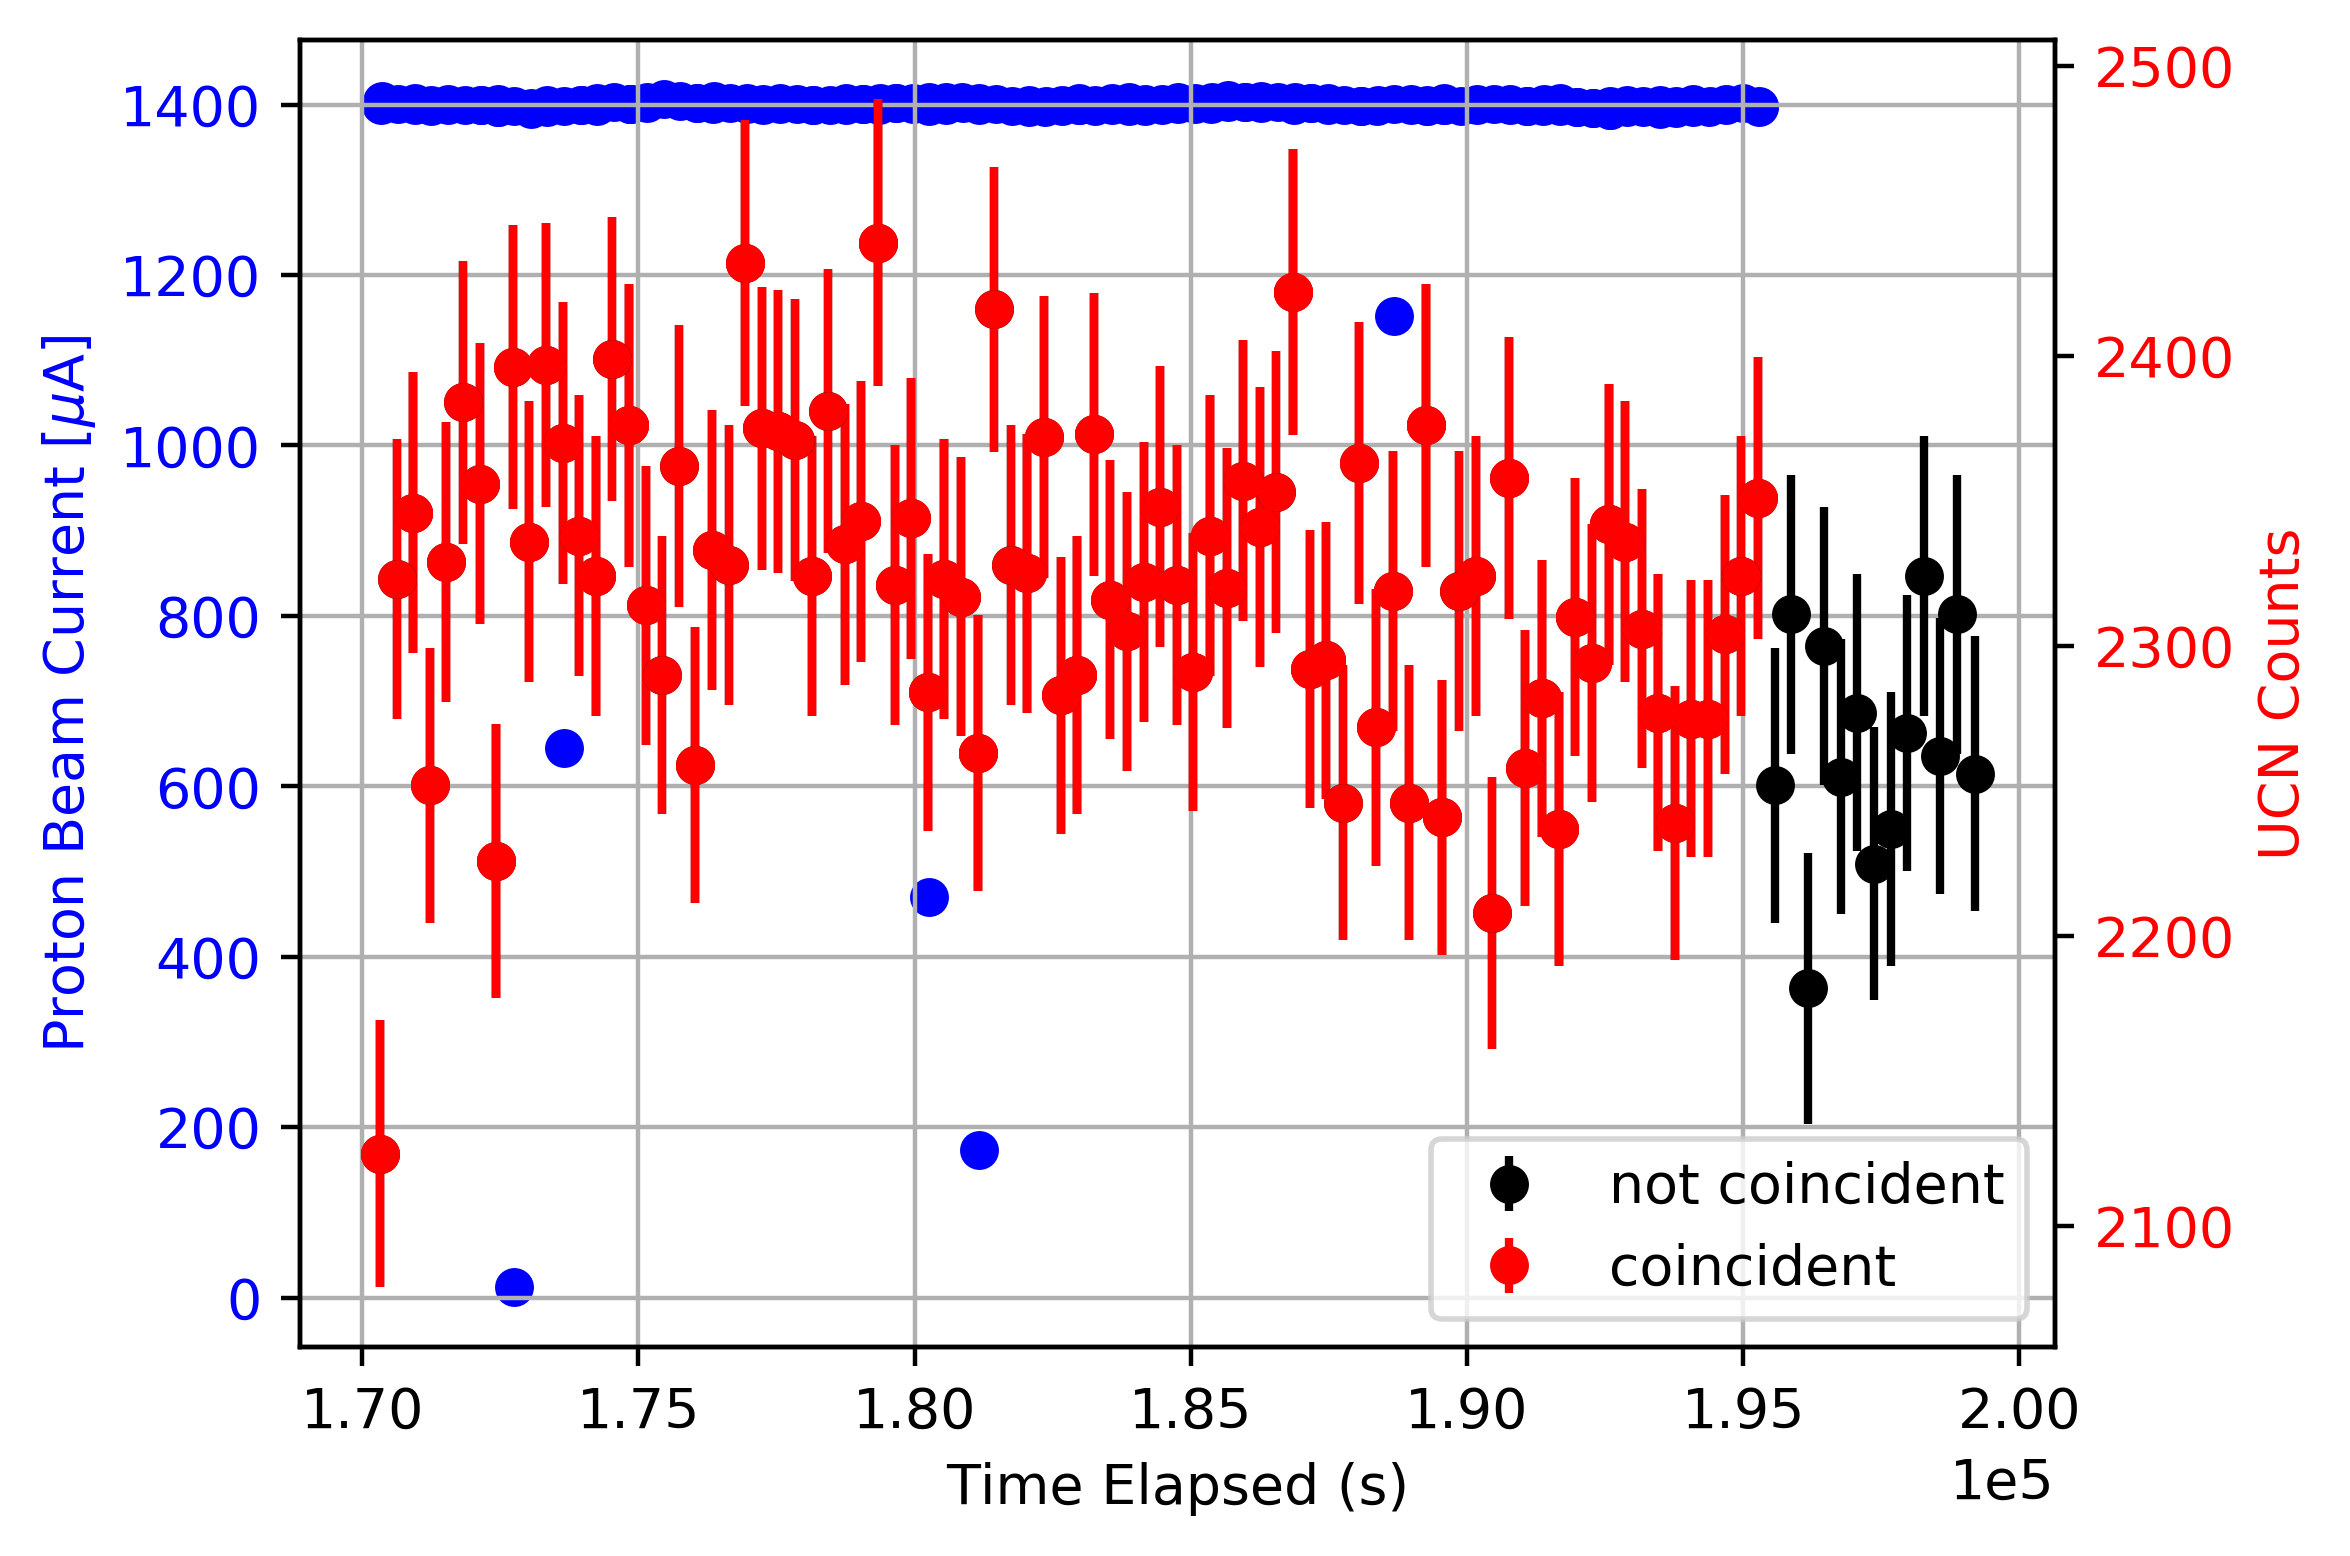

In [69]:
window = 3
run_type = 's100'

# grab the neutron data
arr = main_data_dict['all', 's100']
arr = arr[arr[:,0].argsort()]
start = np.argwhere(arr[:,0] > 1.7e5)[0][0]
print('first index: {}'.format(start))
stop = np.argwhere(arr[:,0] < 2e5)[-1][0]
print('last index: {}'.format(stop))
n_arr = arr[start:stop+1, :]

# grab and sort the proton beam data
p_arr = p_beam_data_3
p_arr = p_arr[p_arr[:,0].argsort()]

# arrays to keep track of indices
p_indices = np.empty((1,0), float)
n_indices = np.empty((1,0), float)

# arrays to hold the coincident points found
p_coincident = np.empty((0,2), float)
n_coincident = np.empty((0,5), float)

# iterating over every time stamp of the proton beam current 
# measurements
for i in range(0, np.size(p_arr[:,0])):

    # only where the proton beam current has non-nan values
    if np.isnan(p_arr[i,1]) == False:

        # get the index, in the neutron count data, that matches this
        # beam current measurement time stamp
        n_indices_to_add = np.argwhere(np.abs(n_arr[:,0] 
                                        - (p_arr[i,0] - 26)) < window)

        # if its not empty, then a coincidence was found
        if (np.size(n_indices_to_add) != 0):

            # keep track of indices
            p_indices = np.append(p_indices, i)
            n_indices = np.append(n_indices, n_indices_to_add)

            # add data to coincidence arrays
            p_coincident = np.append(p_coincident, 
                                    [p_arr[i,:]], axis = 0)
            n_coincident = np.append(n_coincident, 
                                    n_arr[n_indices_to_add[0], :], 
                                    axis = 0)
            
# instantiate the subplots 
fig, ax1 = plt.subplots()

# plot the proton beam current data
ax1.scatter(p_coincident[:,0], p_coincident[:,1], color = 'b')

# presentation stuff
ax1.set_xlabel('Time Elapsed (s)')
ax1.set_ylabel(r'Proton Beam Current [$\mu$A]', 
    color = 'b')
ax1.tick_params(axis='y', labelcolor = 'b')
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  

# plot the neutron count data for runs of this pre-storage
# time
ax2.errorbar(n_arr[:,0], n_arr[:,2], 
                yerr = n_arr[:,3], 
                marker = 'o',
                fmt = '.',
                color = 'k', 
                label = 'not coincident')

# plotting the coincident neutrond data afterwards in black
# to highlight these runs vs non-coincident runs
ax2.errorbar(n_coincident[:,0], n_coincident[:,2], 
                yerr = n_coincident[:,3],
                marker = 'o',
                fmt = '.', 
                color = 'r',
                label = 'coincident')

ax2.tick_params(axis='y', labelcolor = 'r')

# presentation stuff
ax2.set_ylabel('UCN Counts', color = 'r')  
ax2.legend(loc = 'lower right')
ax1.grid()
fig.tight_layout()  

This is a very tight time window, where I have subtracted 26 seconds from every proton beam current time stamp, and then allowed a 3 second window. It demonstrates that the measurements are spaced well, as fas as correspondence to the run frequency goes. We expected as much.

The 'not coincident' measurements occurring after 1.95e5 seconds are just in a region where proton beam current measurements weren't made. We can see this clearly by looking at one of the full plots earlier. 

Let's look at the data on a smaller range in time, and manually subtract the 26 seconds off from each proton beam current time stamp.

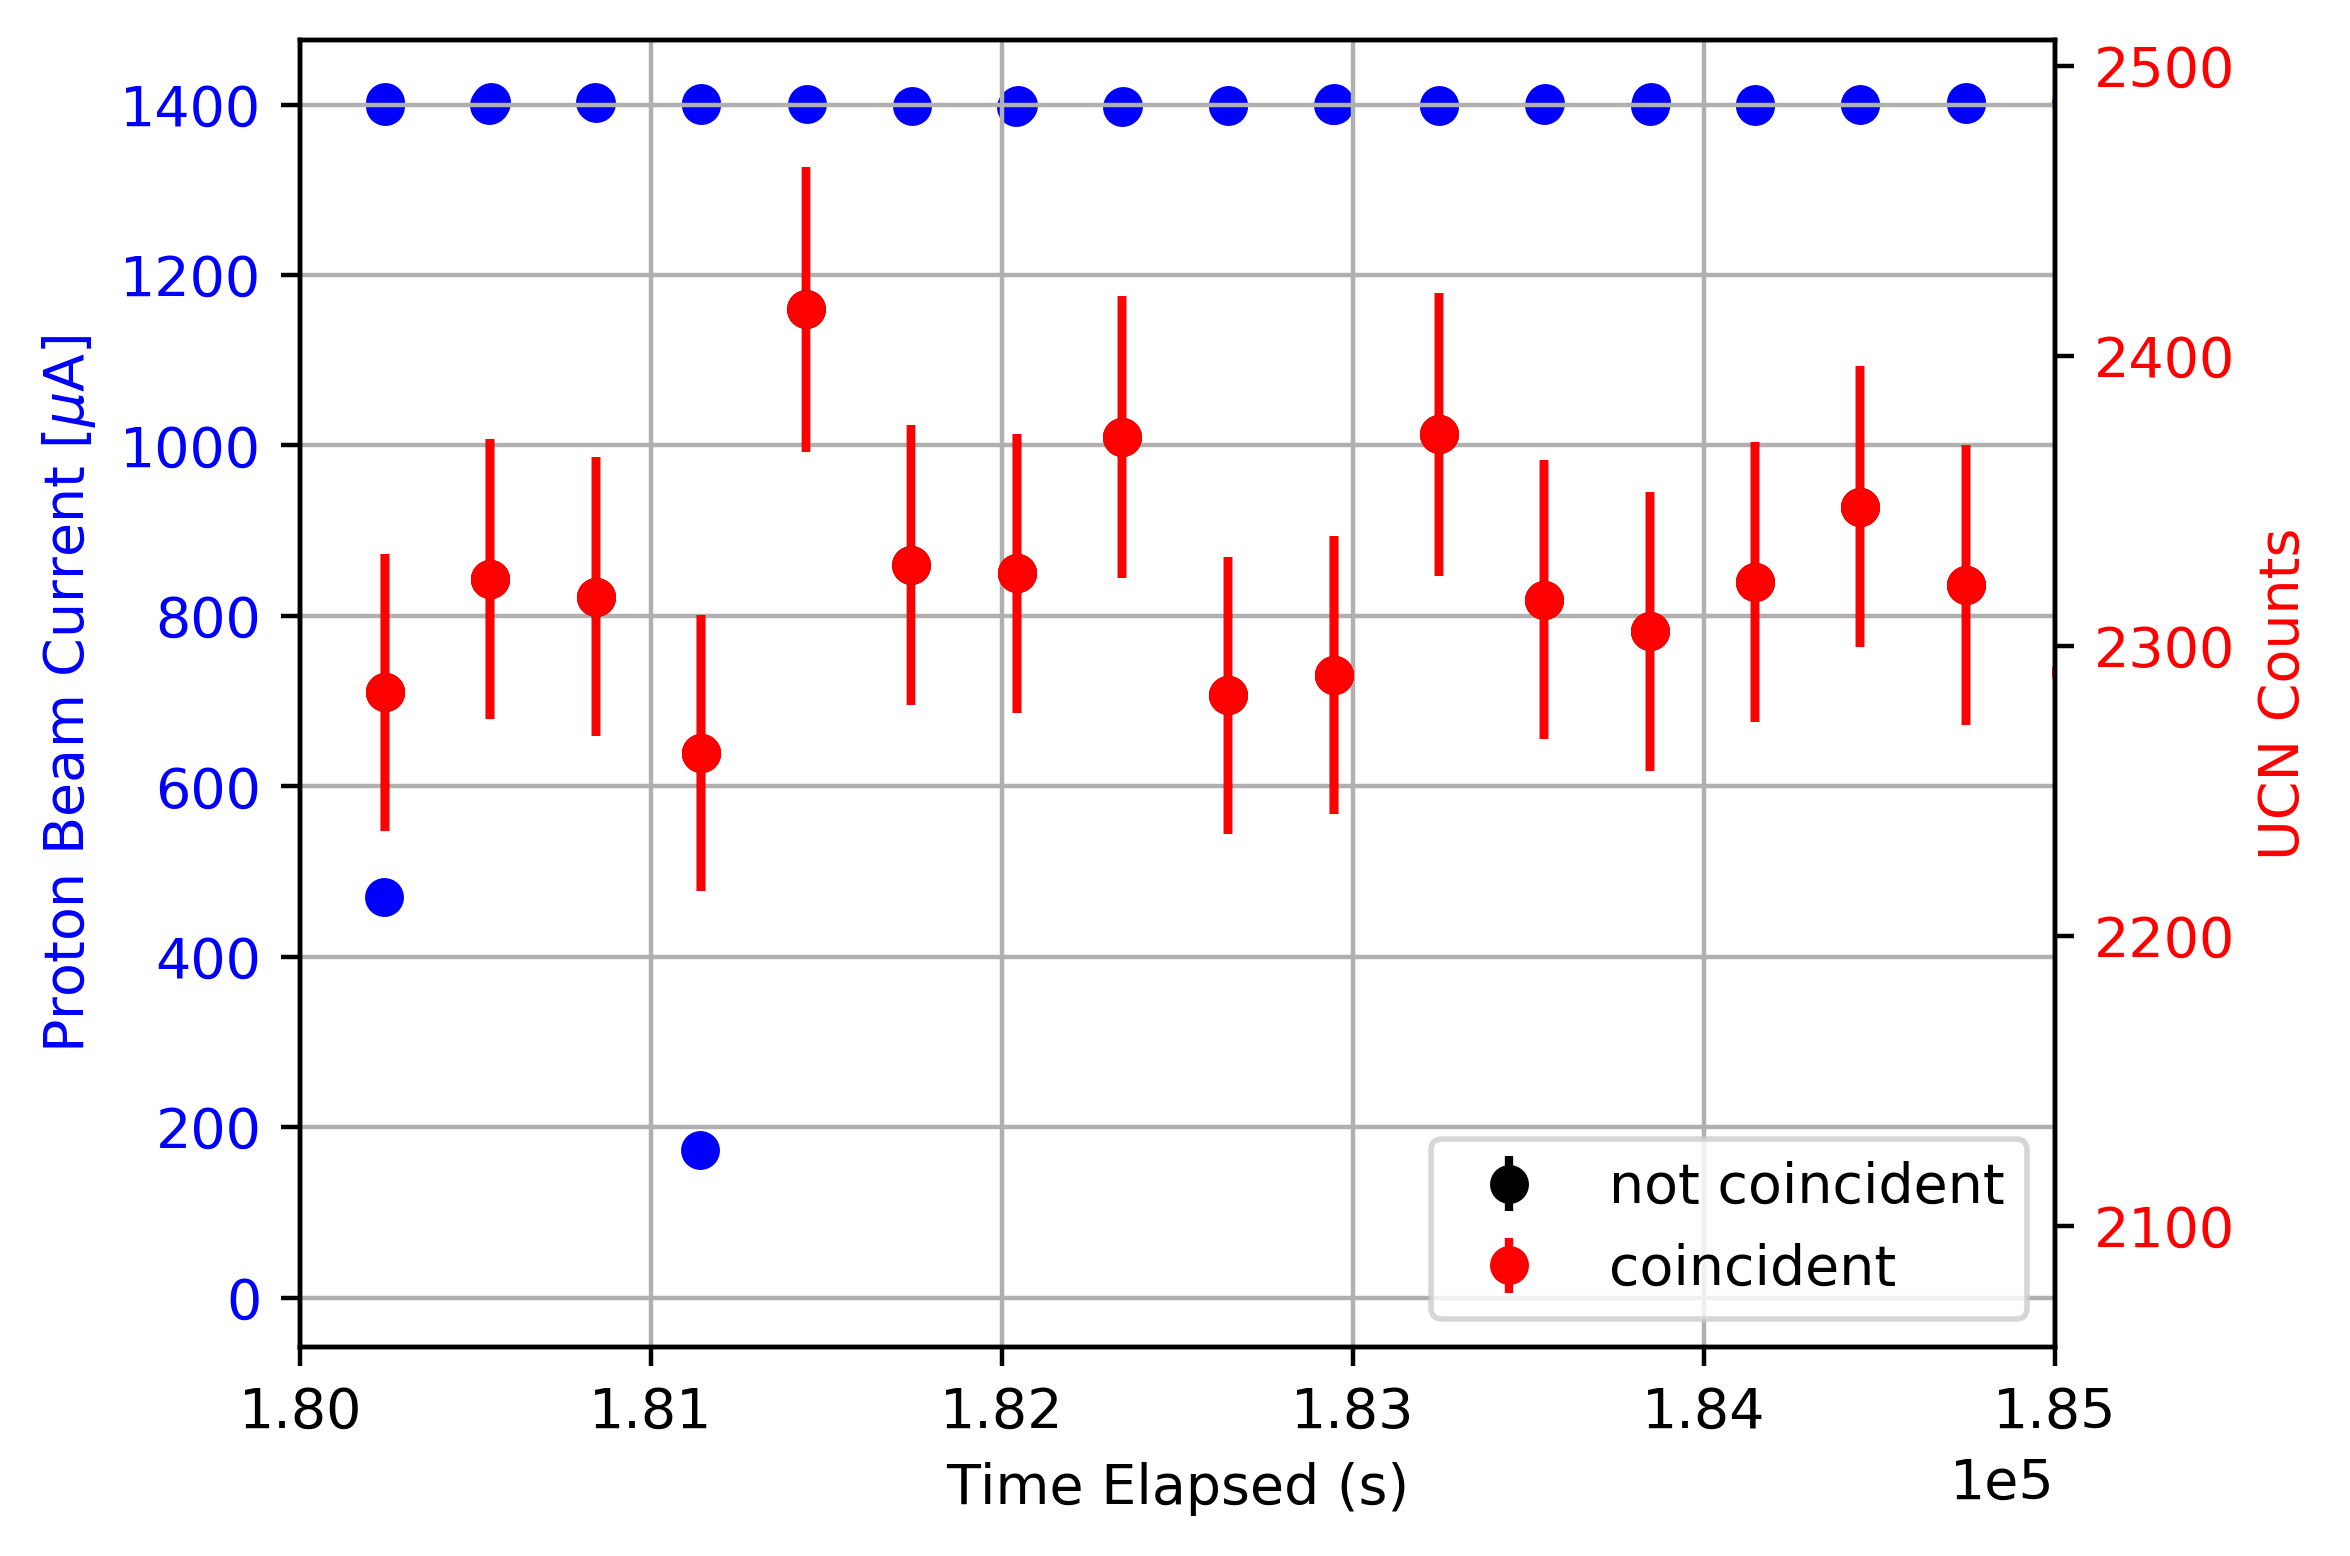

In [70]:
# instantiate the subplots 
fig, ax1 = plt.subplots()

# plot the proton beam current data
ax1.scatter(p_coincident[:,0] - 26, p_coincident[:,1], color = 'b')

# presentation stuff
ax1.set_xlabel('Time Elapsed (s)')
ax1.set_ylabel(r'Proton Beam Current [$\mu$A]', 
    color = 'b')
ax1.tick_params(axis='y', labelcolor = 'b')
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  

# plot the neutron count data for runs of this pre-storage
# time
ax2.errorbar(n_arr[:,0], n_arr[:,2], 
                yerr = n_arr[:,3], 
                marker = 'o',
                fmt = '.',
                color = 'k', 
                label = 'not coincident')

# plotting the coincident neutrond data afterwards in black
# to highlight these runs vs non-coincident runs
ax2.errorbar(n_coincident[:,0], n_coincident[:,2], 
                yerr = n_coincident[:,3],
                marker = 'o',
                fmt = '.', 
                color = 'r',
                label = 'coincident')

ax2.tick_params(axis='y', labelcolor = 'r')

# presentation stuff
ax2.set_ylabel('UCN Counts', color = 'r')  
ax2.legend(loc = 'lower right')
ax1.set_xlim([1.8e5, 1.85e5])
ax1.grid()
fig.tight_layout()  

I think the large fluctuations are just the measurement of proton beam current catching the ramping down that occurs at the end of irradiation. More interesting would be to narrow our range on the left.

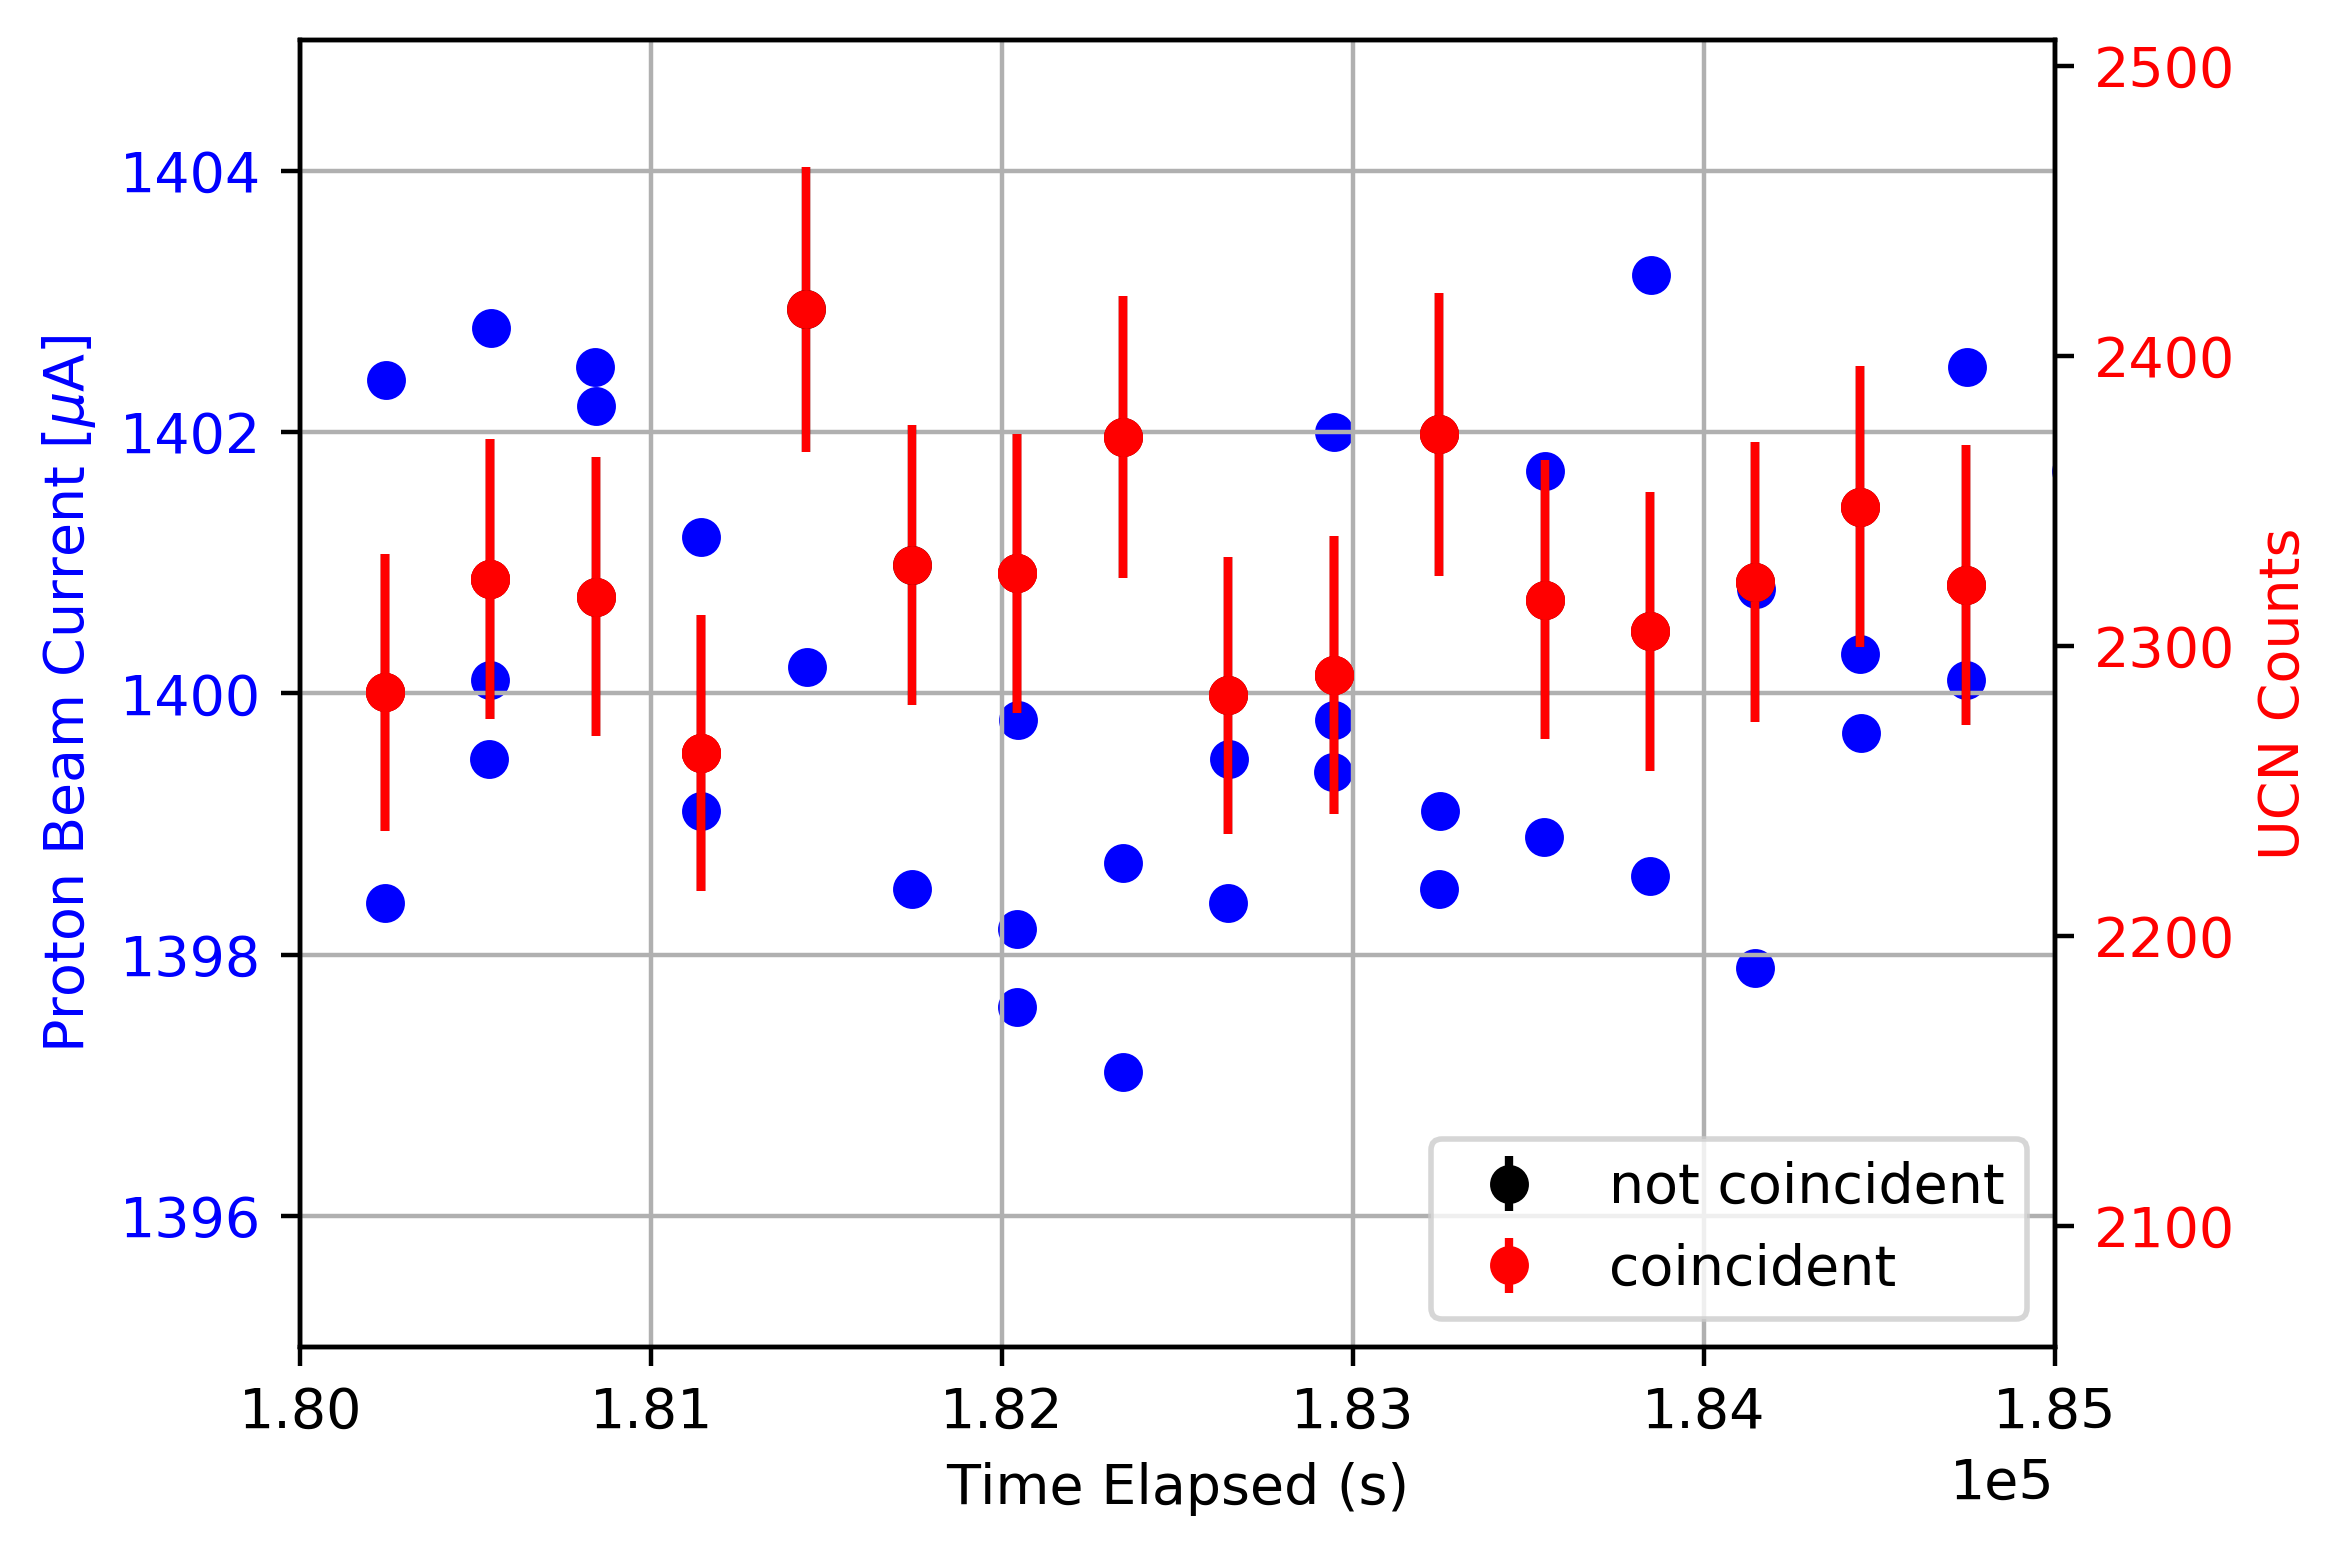

In [71]:
# instantiate the subplots 
fig, ax1 = plt.subplots()

# plot the proton beam current data
ax1.scatter(p_coincident[:,0] - 26, p_coincident[:,1], color = 'b')

# presentation stuff
ax1.set_xlabel('Time Elapsed (s)')
ax1.set_ylabel(r'Proton Beam Current [$\mu$A]', 
    color = 'b')
ax1.tick_params(axis='y', labelcolor = 'b')
ax1.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax1.set_ylim([1395, 1405])
# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  

# plot the neutron count data for runs of this pre-storage
# time
ax2.errorbar(n_arr[:,0], n_arr[:,2], 
                yerr = n_arr[:,3], 
                marker = 'o',
                fmt = '.',
                color = 'k', 
                label = 'not coincident')

# plotting the coincident neutrond data afterwards in black
# to highlight these runs vs non-coincident runs
ax2.errorbar(n_coincident[:,0], n_coincident[:,2], 
                yerr = n_coincident[:,3],
                marker = 'o',
                fmt = '.', 
                color = 'r',
                label = 'coincident')

ax2.tick_params(axis='y', labelcolor = 'r')

# presentation stuff
ax2.set_ylabel('UCN Counts', color = 'r')  
ax2.legend(loc = 'lower right')
ax1.set_xlim([1.8e5, 1.85e5])
ax1.grid()
fig.tight_layout()  

Even if you matched different measurements, i.e. assumed that the time offset between these two data sets was 4 minutes + 26 seconds instead of just 26 seconds, I don't see how this would lead anywhere. 

Every time there's a proton beam measurement, there are 4 successive measurements, within the 8s irradiation window. Even if you looked at the first of those measurements and dropped the last couple (or some trimming of this kind), it doesn't appear as if a strict correlation would present itself. This fact hardly suprises us since our characterization of the source is already weak!

My final idea for this proton beam current analysis would be the following, it perhaps makes more sense to try and analyze the background counts produced from the initial 8 seconds of irradiation. 

![](../misc/edgard_sequence.png)
![](jonahberean/psi_transmission/misc/edgard_sequence.png)

## !!! Q: What is this background from? It can't be neutrons, because the downstream valves are closed.

Maybe a fit of those counts would correspond to some reduced set of data from the monitor. 